In [1]:
from google.colab import drive
drive.mount('/content/drive')
# !pip install -U matplotlib

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/My Drive')

In [3]:
import TFM.TFM.tfmfuncs as tfmfuncs

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
#import tfmfuncs

import random

seed = 420
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
%matplotlib inline
plt.ion()

In [5]:
import numpy as np 
from tensorflow.keras import callbacks
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()
callbacks_list = [PlotLearning()]

# Loading and preprocessing data

Here we load the data from BTC and LTC to build the dataset as Davidson et al. did

In [6]:
df_BTC = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/BTC-paper1.csv',index_col=False)
# df_BTC = pd.read_csv('datasets/BTC-paper1.csv',index_col=False)
df_BTC.isna().sum()
# df_BTC[['Price','Open','High','Low']] =df_BTC[['Price','Open','High','Low']].applymap(lambda x: x.replace(".","a"))
# df_BTC[['Price','Open','High','Low']] =df_BTC[['Price','Open','High','Low']].applymap(lambda x: x.replace(",","."))
df_BTC[['Price','Open','High','Low']] = df_BTC[['Price','Open','High','Low']].applymap(lambda x: x.replace(",",""))
df_BTC[['Date']] = df_BTC[['Date']].applymap(lambda x: x.replace(",",""))
df_BTC[['Price','Open','High','Low']] = df_BTC[['Price','Open','High','Low']].astype('float')


price = df_BTC['Price'].to_numpy()
open = df_BTC['Open'].to_numpy()
dir = []
for i in range(len(price)):
    if price[i]>open[i]:
        dir.append(1)
    else:
        dir.append(-1)
df_BTC['Direction'] = np.array(dir)


In [7]:
df_BTC['Date'] = pd.to_datetime(df_BTC['Date'],format='%b %d %Y')
df_BTC.index = df_BTC['Date']
df_BTC = df_BTC.sort_index()

In [8]:
ds_path = '/content/drive/MyDrive/Colab Notebooks/datasets/LTC-paper1.csv'
df= pd.read_csv(ds_path,index_col=False)
df

Date    Price     Open     High      Low     Vol. Change %
0     May 26, 2021  198.791  183.812  203.898  179.817   28.17M    8.15%
1     May 25, 2021  183.805  184.120  194.322  167.720   28.10M   -0.22%
2     May 24, 2021  184.209  142.554  184.323  139.764    4.19M   29.23%
3     May 23, 2021  142.545  169.429  176.245  118.471   35.86M  -15.86%
4     May 22, 2021  169.416  179.920  184.367  162.309  101.97M   -5.92%
...            ...      ...      ...      ...      ...      ...      ...
1732  Aug 28, 2016    3.720    3.780    3.780    3.620    8.19K   -1.59%
1733  Aug 27, 2016    3.780    3.810    3.850    3.620    4.91K   -0.79%
1734  Aug 26, 2016    3.810    3.810    3.900    3.770   14.35K    0.00%
1735  Aug 25, 2016    3.810    3.840    3.880    3.750   21.87K   -0.78%
1736  Aug 24, 2016    3.840    3.950    3.960    3.610   21.86K   -2.78%

[1737 rows x 7 columns]

In [9]:
def load_df(ds_path):
    df= pd.read_csv(ds_path,index_col=False)
    # df[['Price','Open','High','Low']] =df[['Price','Open','High','Low']].applymap(lambda x: x.replace(",",""))
    df[['Date']] = df[['Date']].applymap(lambda x: x.replace(",",""))
    df[['Price','Open','High','Low']] =df[['Price','Open','High','Low']].astype('float')
    df['Date'] = pd.to_datetime(df['Date'],format='%b %d %Y')
    df.index = df['Date']
    df = df.sort_index()
    return df

def split_ds(X,y):
    return X[:1200],y[:1200],X[1200:],y[1200:]


In [10]:
df['Price'].isnull().sum()

0

## LTC data loading and preprocessing

In [11]:
def znormalise(X,y):
    all = []
    init = X[0,:,0]
    for value in init:
        all.append(value)
    for val in y:
        all.append(val)

    values = np.array(all)
    mean = values.mean()
    std = values.std()
    X[:,:,0] = (X[:,:,0]-mean)/std

    return X,(y-mean)/std



df_LTC = load_df('/content/drive/MyDrive/Colab Notebooks/datasets/LTC-paper1.csv')
df_LTC['Direction'] = df_BTC['Direction'].to_numpy()

# LTC_mean = df_LTC['Price'].mean()
# LTC_std = df_LTC['Price'].std()
# df_LTC['Price_n'] = (df_LTC['Price']-LTC_mean)/LTC_std

X1,y1 = tfmfuncs.df_to_X_y(df_LTC,columns=['Price','Direction'],window_size=1)
X3,y3 = tfmfuncs.df_to_X_y(df_LTC,columns=['Price','Direction'],window_size=3)
X7,y7 = tfmfuncs.df_to_X_y(df_LTC,columns=['Price','Direction'],window_size=7)
X30,y30 = tfmfuncs.df_to_X_y(df_LTC,columns=['Price','Direction'],window_size=30)

X1,y1 = znormalise(X1,y1)
X3,y3 = znormalise(X3,y3)
X7,y7 = znormalise(X7,y7)
X30,y30 = znormalise(X30,y30)

X1_train,y1_train,X1_test,y1_test = split_ds(X1,y1)
X3_train,y3_train,X3_test,y3_test = split_ds(X3,y3)
X7_train,y7_train,X7_test,y7_test = split_ds(X7,y7)
X30_train,y30_train,X30_test,y30_test = split_ds(X30,y30)


In [12]:
# plt.plot(df.index,y1)
y1.shape

(1736,)

In [13]:
# from tensorflow.keras.layers import *
# from tensorflow.keras.models import Sequential

# model = Sequential()
# model.add(Input(shape=(1,2),batch_size=16))
# model.add(LSTM(25,return_sequences=True))
# model.add(GRU(40))
# model.add(Dense(5,activation='relu'))
# model.add(Dense(20,activation='relu'))
# model.add(Dense(1,activation='linear'))



In [14]:
# nb_epochs = 50  
# window_size = len(X1_train[0,:])
# resize1 = (len(X1_test)//16)*16
# X1_test = X1_test[:resize1]
# y1_test = y1_test[:resize1]
# model.compile(optimizer='adam',loss='mse',metrics=['MeanSquaredError'])
# # for i in range(nb_epochs):
# model.fit(X1_train,y1_train,validation_data=(X1_test,y1_test),epochs=nb_epochs,batch_size=16)
#     # model.reset_states()

In [15]:
# preds = model.predict(X1_train,batch_size=16)

In [16]:
# plt.plot(y1_train)
# plt.plot(preds[:,0,0])

# Defining the model

Here we define the model in the same way that Davidson et al. did

In [17]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model

def build_model(X,batch_size):
    window_size = len(X[0,:])

    left_leg_input = Input(shape=(window_size,1), name="left",batch_size=batch_size)
    middle_leg_input = Input(shape=(window_size,1), name="middle",batch_size=batch_size)
    right_leg_input = Input(shape=(window_size,1), name="right",batch_size=batch_size)


    left_leg = LSTM(25,return_sequences=True,stateful=True)(left_leg_input)
    # left_leg = LSTM(25,return_sequences=True)(left_leg_input)
    left_leg = Dropout(0.25)(left_leg)
    left_leg = GRU(40,stateful=True)(left_leg)
    # left_leg = GRU(40)(left_leg)
    left_leg = Flatten()(left_leg)
    # left_leg = Reshape(())
    left_leg = Dense(5,activation='relu')(left_leg)

    middle_leg = LSTM(50,return_sequences=True,stateful=True)(middle_leg_input)
    # middle_leg = LSTM(50,return_sequences=True)(middle_leg_input)
    middle_leg = Dropout(0.25)(middle_leg)
    middle_leg = Flatten()(middle_leg)
    middle_leg = Dense(5,activation='relu')(middle_leg)
    
    right_leg = Flatten()(right_leg_input)
    right_leg = Dense(20,activation='relu')(right_leg)
    right_leg = Dense(10,activation='relu')(right_leg)

    x = concatenate([left_leg,middle_leg,right_leg])
    x = Dense(20,activation='relu')(x)
    x = Dense(1,activation='linear',name='target')(x)

    inputs = [left_leg_input,middle_leg_input,right_leg_input]
    output = x

    model = Model(inputs=inputs,outputs=output)

    return model


# Training

Here we train the model

In [18]:
# from tensorflow.keras.callbacks import CSVLogger
def adapt_ds(X):
    window_size = len(X[0,:])
    prices = X[:,:,0].reshape(len(X),window_size,1)
    directions = X[:,:,1].reshape(len(X),window_size,1)
    return prices, directions

def resize_ds(X,y):
    resize = (len(X)//16)*16
    X = X[:resize]
    y = y[:resize]

    return X,y

datasets = [(X1_train,y1_train,X1_test,y1_test),(X3_train,y3_train,X3_test,y3_test),(X7_train,y7_train,X7_test,y7_test),(X30_train,y30_train,X30_test,y30_test)]
nb_epochs = 50
models = []
j=0
for dataset in datasets:
    print(f'Training {j}')
    X_train = dataset[0]
    y_train = dataset[1]
    X_test = dataset[2]
    y_test = dataset[3]

    X_test,y_test = resize_ds(X_test,y_test)

    print(f'X_train & y_train: {X_train.shape},{y_train.shape}\nX_test & y_test: {X_test.shape},{y_test.shape}')

    model = build_model(X_train,batch_size=16)
    window_size = len(X_train[0,:])
    p_train1, dirs_train1 = adapt_ds(X_train)
    p_test1, dirs_test1 = adapt_ds(X_test)
    loss = []
    val_loss = []
    model.compile(optimizer='adam',loss='mse',metrics=['MeanSquaredError'])
    for i in range(nb_epochs):
        print(f'Epoch {i}')
        history = model.fit({'left':p_train1,'middle':p_train1,'right':dirs_train1},{'target':y_train},validation_data=({'left':p_test1,'middle':p_test1,'right':dirs_test1},{'target':y_test}),epochs=1,batch_size=16)
        loss.append(history.history['loss'][0])
        val_loss.append(history.history['val_loss'][0])
        model.reset_states()

    models.append((model,p_train1,dirs_train1,p_test1,dirs_test1,y_test,window_size,loss,val_loss))
    model.save(f'models/tfm-{window_size}.h5')
    tf.keras.backend.clear_session()
    j+=1
    print(f'Done training\n')

Training 0
X_train & y_train: (1200, 1, 2),(1200,)
X_test & y_test: (528, 1, 2),(528,)
Epoch 0
75/75 [==============================] - 5s 15ms/step - loss: 0.6893 - mean_squared_error: 0.6893 - val_loss: 0.6946 - val_mean_squared_error: 0.6946
Epoch 1
75/75 [==============================] - 0s 3ms/step - loss: 0.1356 - mean_squared_error: 0.1356 - val_loss: 0.0821 - val_mean_squared_error: 0.0821
Epoch 2
75/75 [==============================] - 0s 4ms/step - loss: 0.0396 - mean_squared_error: 0.0396 - val_loss: 0.0346 - val_mean_squared_error: 0.0346
Epoch 3
75/75 [==============================] - 0s 4ms/step - loss: 0.0338 - mean_squared_error: 0.0338 - val_loss: 0.0244 - val_mean_squared_error: 0.0244
Epoch 4
75/75 [==============================] - 0s 3ms/step - loss: 0.0321 - mean_squared_error: 0.0321 - val_loss: 0.0236 - val_mean_squared_error: 0.0236
Epoch 5
75/75 [==============================] - 0s 3ms/step - loss: 0.0292 - mean_squared_error: 0.0292 - val_loss: 0.0144 - v

In [19]:
import matplotlib.transforms as mtransforms
# model_num = 2

# loss, val_loss = models[model_num][6],models[model_num][7]

# plt.plot(loss)
# plt.plot(val_loss)

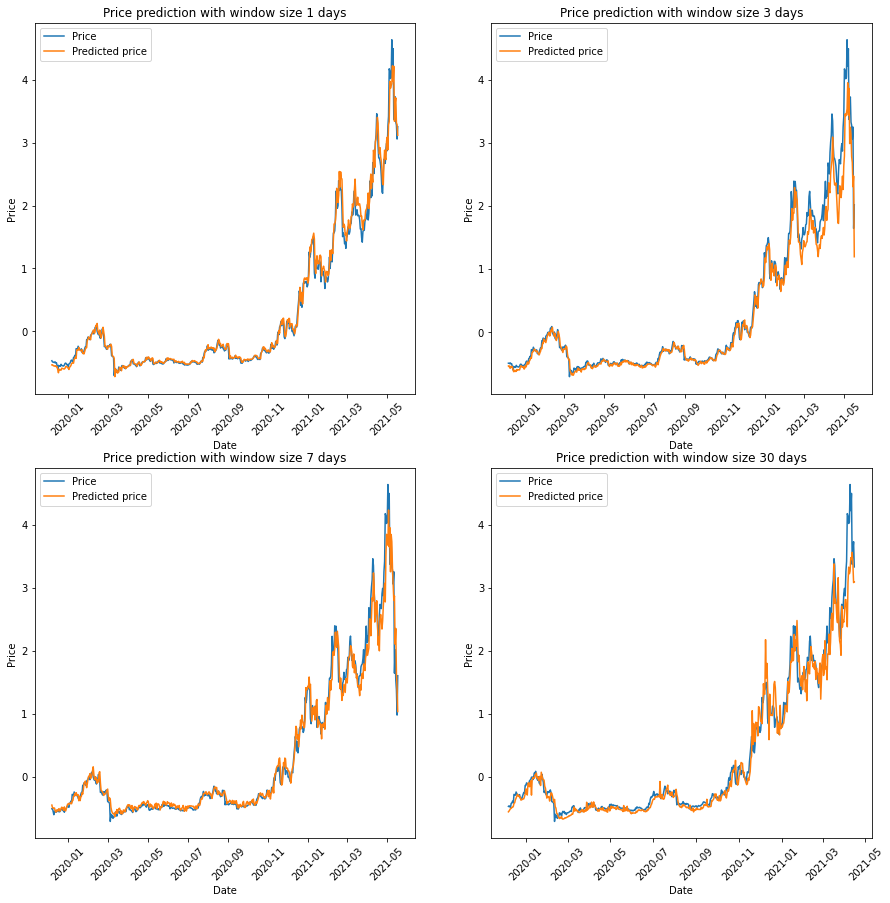

In [23]:
fig, axs = plt.subplots(2, 2)
# fig, axs = plt.subplot_mosaic([['a)', 'c)'], ['b)', 'c)'], ['d)', 'd)']],
#                               constrained_layout=True)

# for label, ax in axs.items():
#     # label physical distance in and down:
#     trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
#     ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
#             fontsize='medium', verticalalignment='top', fontfamily='serif',
#             bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
for ax in axs.flatten():
    plt.sca(ax)
    plt.xticks(rotation = 45)
# fig.suptitle('Price prediction')
plt.rcParams['figure.figsize'] = [15, 15]
# name = model_names[k]
i = 0
j = 0
for model_num in range(4):
    if model_num == 0:
      i,j=0,0
      w_size=1
    elif model_num == 1:
      i,j=0,1
      w_size=3
    elif model_num == 2:
      i,j=1,0
      w_size=7
    elif model_num == 3:
      i,j=1,1
      w_size=30
    model = models[model_num]
    m,loss, val_loss,y_test,prices,dirs = model[0],model[-2],model[-1],model[5],model[3],model[4]
    stop = -abs(len(df_LTC['Date'][1200:])-len(y_test))
    dates = df_LTC['Date'][1200:stop]
    preds = m.predict({'left':prices,'middle':prices,'right':dirs},batch_size=16)
    # w_size = model[-3]
    axs[i, j].plot(dates,y_test)
    axs[i, j].plot(dates,preds.flatten())
    axs[i,j].legend(['Price','Predicted price'])
    axs[i, j].set_xlabel('Date')
    axs[i, j].set_ylabel('Price')
    axs[i, j].set_title(f'Price prediction with window size '+str(w_size)+' days')
    m.reset_states()

In [24]:
k = 0
losses1 = []
val_losses1 = []
losses3 = []
val_losses3 = []
losses7 = []
val_losses7 = []
losses30 = []
val_losses30 = []

for model_num in range(4):
  model = models[model_num]
  loss, val_loss = np.array(model[-2]),np.array(model[-1])
  min_loss,min_loss_arg,min_val_loss,min_val_loss_arg = np.min(loss), np.argmin(loss),np.min(val_loss), np.argmin(val_loss)
  if model_num == 0:
    losses1.append(min_loss)
    val_losses1.append(min_val_loss)
    w_size=1
  elif model_num == 1:
    losses3.append(min_loss)
    val_losses3.append(min_val_loss)
    w_size=3
  elif model_num == 2:
    losses7.append(min_loss)
    val_losses7.append(min_val_loss)
    w_size=7
  elif model_num == 3:
    losses30.append(min_loss)
    val_losses30.append(min_val_loss)
    w_size=30
    
    
losses1 = np.array(losses1)
val_losses1 = np.array(val_losses1)

losses3 = np.array(losses3)
val_losses3 = np.array(val_losses3)

losses7 = np.array(losses7)
val_losses7 = np.array(val_losses7)

losses30 = np.array(losses30)
val_losses30 = np.array(val_losses30)

[Text(0, 0, 'Davidson')]

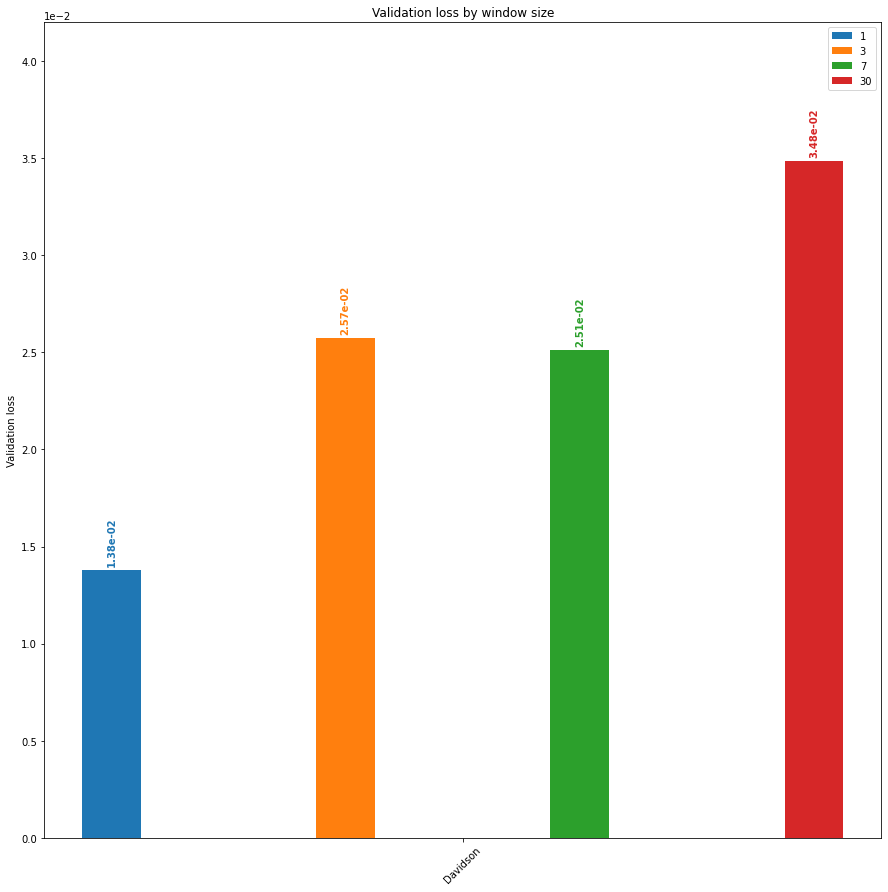

In [25]:
def addlabels(x,bars):
    bar_color = bars[0].get_facecolor()
    for bar in bars:
      ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.0003,
        # round(bar.get_height(), 1),
        '{:.2e}'.format(bar.get_height()),
        horizontalalignment='center',
        color=bar_color,
        weight='bold',
        rotation=90
    )

labels = ['Davidson']
# labels = ['Davidson','Davidson+Livieris','Custom model+DeFI','Davidson+Livieris WBTC','Davidson+Livieris LTC','Davidson modified+Livieris LTC','Davidson+Livieris+DeFI LTC']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.01  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 6*width, val_losses1, width, label='1')
rects2 = ax.bar(2*(x - width), val_losses3, width, label='3')
rects3 = ax.bar(2*(x + width), val_losses7, width, label='7')
rects4 = ax.bar(x + 6*width, val_losses30, width, label='30')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Validation loss')
ax.set_title('Validation loss by window size')
ax.ticklabel_format(scilimits=[0,0])
ax.set_xticks(x)
ax.set_ylim(top=0.042)
plt.xticks(rotation=45)
addlabels(x,rects1)
addlabels(x,rects2)
addlabels(x,rects3)
addlabels(x,rects4)
ax.legend()

ax.set_xticklabels(labels)

RESULTS!

* w1: loss: 0.0144 - mean_squared_error: 0.0144 - val_loss: 0.0394 - val_mean_squared_error: 0.0394
* w3: loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0420 - val_mean_squared_error: 0.0420
* w7: loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0264 - val_mean_squared_error: 0.0264
* w30: loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0299 - val_mean_squared_error: 0.0299

TODO:
* Generate graphs of forecast in window and write results. Nothing more to be done tbh
* Redo comparison but using log returns instead of zscoring (does not remove outliers).
* Redo comparison, but using DeFI data for Bitcoin, using market activity to do the prediction instead of using the +1. Unusual positive activity should be a +1, regular activity within a period should be a 0, and unusual negative activity should be a -1.
* Try to do a comparison for a Boosted model, but using 

In [26]:
m1 = models[0][0]
prices,dirs,w_size,loss,val_loss = models[0][3], models[0][4],models[0][5],models[0][6],models[0][7]
m1.reset_states()
preds = m1.predict({'left':prices,'middle':prices,'right':dirs},batch_size=16)
# print(preds)

In [27]:
# df_BTC.iloc[2]

d = pd.to_datetime(df_BTC.iloc[-1]['Date'],format='%b %d %Y')
# plt.scatter([d],(preds[-1]*LTC_std)+LTC_mean)
# plt.scatter([d],(y1_test[-1]*LTC_std)+LTC_mean)
d
# df_BTC.iloc[2:3]


Timestamp('2021-05-26 00:00:00')

In [28]:
df_LTC

Date    Price     Open     High      Low     Vol. Change %  \
Date                                                                          
2016-08-24 2016-08-24    3.840    3.950    3.960    3.610   21.86K   -2.78%   
2016-08-25 2016-08-25    3.810    3.840    3.880    3.750   21.87K   -0.78%   
2016-08-26 2016-08-26    3.810    3.810    3.900    3.770   14.35K    0.00%   
2016-08-27 2016-08-27    3.780    3.810    3.850    3.620    4.91K   -0.79%   
2016-08-28 2016-08-28    3.720    3.780    3.780    3.620    8.19K   -1.59%   
...               ...      ...      ...      ...      ...      ...      ...   
2021-05-22 2021-05-22  169.416  179.920  184.367  162.309  101.97M   -5.92%   
2021-05-23 2021-05-23  142.545  169.429  176.245  118.471   35.86M  -15.86%   
2021-05-24 2021-05-24  184.209  142.554  184.323  139.764    4.19M   29.23%   
2021-05-25 2021-05-25  183.805  184.120  194.322  167.720   28.10M   -0.22%   
2021-05-26 2021-05-26  198.791  183.812  203.898  179.817   28.17M    8.15%   

            Direction  
Date                   
2016-08-24         -1  
2016-08-25         -1  
2016-08-26          1  
2016-08-27         -1  
2016-08-28          1  
...               ...  
2021-05-22          1  
2021-05-23         -1  
2021-05-24          1  
2021-05-25         -1  
2021-05-26          1  

[1737 rows x 8 columns]

# Applying Livieris framework to the dataset

Here we calculate returns and log-returns. The "TEST" column is a column normalised between -1 and 1

In [29]:
# df_LTC['T'] = pd.to_datetime(df_LTC['Date'],format='%b %d %Y')
df_LTC['diffs_ptc'] = df_LTC['Price'].pct_change()
df_LTC['diffs'] = df_LTC['Price'].diff()
df_LTC['log-price'] = np.log(df_LTC['Price'])
df_LTC['log_returns'] = np.log(df_LTC['Price']/df_LTC['Price'].shift(1))
first_row = df_LTC.iloc[0]
df_LTC = df_LTC.dropna()
df_LTC['Price'][0]*np.exp(df_LTC['log_returns'].mean())

df_LTC_Z = df_LTC[['Date','log_returns','Direction']]
log_rets = df_LTC_Z['log_returns'].to_numpy()
df_LTC_Z['log_returns_Z'] = (log_rets-log_rets.mean())/log_rets.std()

# df_LTC

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [30]:
df_LTC

Date    Price     Open     High      Low     Vol. Change %  \
Date                                                                          
2016-08-25 2016-08-25    3.810    3.840    3.880    3.750   21.87K   -0.78%   
2016-08-26 2016-08-26    3.810    3.810    3.900    3.770   14.35K    0.00%   
2016-08-27 2016-08-27    3.780    3.810    3.850    3.620    4.91K   -0.79%   
2016-08-28 2016-08-28    3.720    3.780    3.780    3.620    8.19K   -1.59%   
2016-08-29 2016-08-29    3.770    3.720    3.840    3.700    3.67K    1.34%   
...               ...      ...      ...      ...      ...      ...      ...   
2021-05-22 2021-05-22  169.416  179.920  184.367  162.309  101.97M   -5.92%   
2021-05-23 2021-05-23  142.545  169.429  176.245  118.471   35.86M  -15.86%   
2021-05-24 2021-05-24  184.209  142.554  184.323  139.764    4.19M   29.23%   
2021-05-25 2021-05-25  183.805  184.120  194.322  167.720   28.10M   -0.22%   
2021-05-26 2021-05-26  198.791  183.812  203.898  179.817   28.17M    8.15%   

            Direction  diffs_ptc   diffs  log-price  log_returns  
Date                                                              
2016-08-25         -1  -0.007812  -0.030   1.337629    -0.007843  
2016-08-26          1   0.000000   0.000   1.337629     0.000000  
2016-08-27         -1  -0.007874  -0.030   1.329724    -0.007905  
2016-08-28          1  -0.015873  -0.060   1.313724    -0.016000  
2016-08-29         -1   0.013441   0.050   1.327075     0.013351  
...               ...        ...     ...        ...          ...  
2021-05-22          1  -0.059192 -10.659   5.132357    -0.061016  
2021-05-23         -1  -0.158610 -26.871   4.959658    -0.172699  
2021-05-24          1   0.292287  41.664   5.216071     0.256413  
2021-05-25         -1  -0.002193  -0.404   5.213875    -0.002196  
2021-05-26          1   0.081532  14.986   5.292254     0.078379  

[1736 rows x 12 columns]

In [31]:
df_LTC['log-price-diff'] = df_LTC['log-price'].diff()
df_LTC = df_LTC.dropna()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
df_LTC = df_LTC[df_LTC['log_returns']!= 0]
df_LTC['test'] = 2*(df_LTC['log_returns']-df_LTC['log_returns'].min())/(df_LTC['log_returns'].max()-df_LTC['log_returns'].min())-1
df_LTC['test-nolog'] = 2*(df_LTC['diffs_ptc']-df_LTC['diffs_ptc'].min())/(df_LTC['diffs_ptc'].max()-df_LTC['diffs_ptc'].min())-1

In [33]:
df_LTC['Price'][-493]
# 521,519,515,492

57.2

In [34]:
df_LTC.iloc[1699:]

Date    Price     Open     High      Low     Vol. Change %  \
Date                                                                          
2021-05-04 2021-05-04  305.328  294.540  324.327  271.934  264.49M    3.70%   
2021-05-05 2021-05-05  355.957  311.607  359.565  311.607  321.62M   16.58%   
2021-05-06 2021-05-06  353.380  356.136  364.758  318.986    2.75M   -0.72%   
2021-05-07 2021-05-07  345.537  353.380  372.264  333.893  329.82M   -2.22%   
2021-05-08 2021-05-08  347.030  345.199  356.507  334.242  325.56M    0.43%   
2021-05-09 2021-05-09  386.820  347.129  388.956  334.673    2.29M   11.47%   
2021-05-10 2021-05-10  359.106  387.812  412.802  335.177  356.90M   -7.16%   
2021-05-11 2021-05-11  377.369  359.183  379.478  345.199  333.25M    5.09%   
2021-05-12 2021-05-12  302.330  377.380  393.938  302.330    2.52M  -19.88%   
2021-05-13 2021-05-13  317.510  312.560  332.488  291.625  258.38M    5.02%   
2021-05-14 2021-05-14  326.210  317.710  338.828  308.445  287.96M    2.74%   
2021-05-15 2021-05-15  299.500  326.359  331.683  296.966  262.08M   -8.19%   
2021-05-16 2021-05-16  296.201  299.781  323.780  279.880  258.54M   -1.10%   
2021-05-17 2021-05-17  281.264  296.310  296.310  262.362  225.05M   -5.04%   
2021-05-18 2021-05-18  294.385  281.428  317.706  279.000  254.45M    4.67%   
2021-05-19 2021-05-19  186.896  294.224  300.240  145.878  189.18M  -36.51%   
2021-05-20 2021-05-20  211.770  186.390  224.669  166.696    4.27M   13.31%   
2021-05-21 2021-05-21  180.075  211.770  218.596  156.734  169.66M  -14.97%   
2021-05-22 2021-05-22  169.416  179.920  184.367  162.309  101.97M   -5.92%   
2021-05-23 2021-05-23  142.545  169.429  176.245  118.471   35.86M  -15.86%   
2021-05-24 2021-05-24  184.209  142.554  184.323  139.764    4.19M   29.23%   
2021-05-25 2021-05-25  183.805  184.120  194.322  167.720   28.10M   -0.22%   
2021-05-26 2021-05-26  198.791  183.812  203.898  179.817   28.17M    8.15%   

            Direction  diffs_ptc    diffs  log-price  log_returns  \
Date                                                                
2021-05-04         -1   0.037010   10.897   5.721387     0.036342   
2021-05-05          1   0.165818   50.629   5.874810     0.153423   
2021-05-06         -1  -0.007240   -2.577   5.867544    -0.007266   
2021-05-07          1  -0.022194   -7.843   5.845100    -0.022444   
2021-05-08          1   0.004321    1.493   5.849411     0.004312   
2021-05-09         -1   0.114659   39.790   5.957959     0.108548   
2021-05-10         -1  -0.071646  -27.714   5.883618    -0.074342   
2021-05-11          1   0.050857   18.263   5.933223     0.049606   
2021-05-12         -1  -0.198848  -75.039   5.711519    -0.221704   
2021-05-13          1   0.050210   15.180   5.760509     0.048990   
2021-05-14          1   0.027401    8.700   5.787541     0.027032   
2021-05-15         -1  -0.081880  -26.710   5.702114    -0.085427   
2021-05-16         -1  -0.011015   -3.299   5.691038    -0.011076   
2021-05-17         -1  -0.050429  -14.937   5.639294    -0.051745   
2021-05-18         -1   0.046650   13.121   5.684888     0.045595   
2021-05-19         -1  -0.365131 -107.489   5.230552    -0.454336   
2021-05-20          1   0.133090   24.874   5.355501     0.124948   
2021-05-21         -1  -0.149667  -31.695   5.193373    -0.162127   
2021-05-22          1  -0.059192  -10.659   5.132357    -0.061016   
2021-05-23         -1  -0.158610  -26.871   4.959658    -0.172699   
2021-05-24          1   0.292287   41.664   5.216071     0.256413   
2021-05-25         -1  -0.002193   -0.404   5.213875    -0.002196   
2021-05-26          1   0.081532   14.986   5.292254     0.078379   

            log-price-diff      test  test-nolog  
Date                                              
2021-05-04        0.036342 -0.043446   -0.307689  
2021-05-05        0.153423  0.170644   -0.096577  
2021-05-06       -0.007266 -0.123185   -0.380213  
2021-05-07       -0.022444 -0.150940   -0.404723  
2021-05-0

In [124]:
# X1_log,y1_log = tfmfuncs.df_to_X_y(df_LTC,columns=['diffs_ptc','Direction'],window_size=1)
# X3_log,y3_log = tfmfuncs.df_to_X_y(df_LTC,columns=['diffs_ptc','Direction'],window_size=3)
# X7_log,y7_log = tfmfuncs.df_to_X_y(df_LTC,columns=['diffs_ptc','Direction'],window_size=7)
# X30_log,y30_log = tfmfuncs.df_to_X_y(df_LTC,columns=['diffs_ptc','Direction'],window_size=30)
X1_log,y1_log = tfmfuncs.df_to_X_y(df_LTC,columns=['test','Direction'],window_size=1)
X3_log,y3_log = tfmfuncs.df_to_X_y(df_LTC,columns=['test','Direction'],window_size=3)
X7_log,y7_log = tfmfuncs.df_to_X_y(df_LTC,columns=['test','Direction'],window_size=7)
X30_log,y30_log = tfmfuncs.df_to_X_y(df_LTC,columns=['test','Direction'],window_size=30)

# X1_log,y1_log = tfmfuncs.df_to_X_y(df_LTC,columns=['log_returns','Direction'],window_size=1)
# X3_log,y3_log = tfmfuncs.df_to_X_y(df_LTC,columns=['log_returns','Direction'],window_size=3)
# X7_log,y7_log = tfmfuncs.df_to_X_y(df_LTC,columns=['log_returns','Direction'],window_size=7)
# X30_log,y30_log = tfmfuncs.df_to_X_y(df_LTC,columns=['log_returns','Direction'],window_size=30)

X1_log_train,y1_log_train,X1_log_test,y1_log_test = split_ds(X1_log,y1_log)
X3_log_train,y3_log_train,X3_log_test,y3_log_test = split_ds(X3_log,y3_log)
X7_log_train,y7_log_train,X7_log_test,y7_log_test = split_ds(X7_log,y7_log)
X30_log_train,y30_log_train,X30_log_test,y30_log_test = split_ds(X30_log,y30_log)

# Applying Advanced Dickey-Fuller test to data

In [36]:
from statsmodels.tsa.stattools import adfuller

def perform_adf_test(series):
    result = adfuller(series)
    crit_values = np.array(list(result[4].values()))
    print(f'ADF statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical points: {list(result[4].values())}')
    print(f'p-value > 0.05? {result[1]>0.05}')
    print(f'Statistic > critical values? {result[0]>np.max(crit_values)}')

perform_adf_test(df_LTC['Open'])
# plt.plot(df_LTC2['Price'][-37:-5])

# if p-value is less than confidence level (0.05), we assume series is stationary.
# if Test statistic ≤ critical value, we assume series is stationary


ADF statistic: -2.059125109620777
p-value: 0.26126489013130694
Critical points: [-3.4342115713566796, -2.863245666499036, -2.567678052034198]
p-value > 0.05? True
Statistic > critical values? True


In [128]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed)

Data is stationary for log-returns

In [129]:
datasets = [(X1_log_train,y1_log_train,X1_log_test,y1_log_test),(X3_log_train,y3_log_train,X3_log_test,y3_log_test),(X7_log_train,y7_log_train,X7_log_test,y7_log_test),(X30_log_train,y30_log_train,X30_log_test,y30_log_test)]
nb_epochs = 50
models_log = []
j=0
for dataset in datasets:
    print(f'Training {j}')
    X_train = dataset[0]
    y_train = dataset[1]
    X_test = dataset[2]
    y_test = dataset[3]

    X_train,y_train = resize_ds(X_train,y_train)
    X_test,y_test = resize_ds(X_test,y_test)

    print(f'X_train & y_train: {X_train.shape},{y_train.shape}\nX_test & y_test: {X_test.shape},{y_test.shape}')

    model = build_model(X_train,batch_size=16)
    window_size = len(X_train[0,:])
    p_train1, dirs_train1 = adapt_ds(X_train)
    p_test1, dirs_test1 = adapt_ds(X_test)
    model.compile(optimizer='adam',loss='mse',metrics=['MeanSquaredError'])
    loss = []
    val_loss = []
    for i in range(nb_epochs):
        print(f'Epoch {i}')
        history = model.fit({'left':p_train1,'middle':p_train1,'right':dirs_train1},{'target':y_train},validation_data=({'left':p_test1,'middle':p_test1,'right':dirs_test1},{'target':y_test}),epochs=1,batch_size=16)
        loss.append(history.history['loss'][0])
        val_loss.append(history.history['val_loss'][0])
        model.reset_states()
        
    models_log.append((model,p_train1,dirs_train1,p_test1,dirs_test1,window_size,y_test,y_train,loss,val_loss))
    model.save(f'models/tfm-log-{window_size}.h5')
    tf.keras.backend.clear_session()
    j+=1
    print(f'Done training\n')

Training 0
X_train & y_train: (1200, 1, 2),(1200,)
X_test & y_test: (512, 1, 2),(512,)
Epoch 0
75/75 [==============================] - 4s 14ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 1
75/75 [==============================] - 0s 3ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 2
75/75 [==============================] - 0s 3ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 3
75/75 [==============================] - 0s 4ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 4
75/75 [==============================] - 0s 4ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 5
75/75 [==============================] - 0s 3ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0111 - v

(512, 3, 1) (512, 3, 1)


Text(0.5, 1.0, 'Actual price vs predicted price for window size of 3 days and for simple returns')

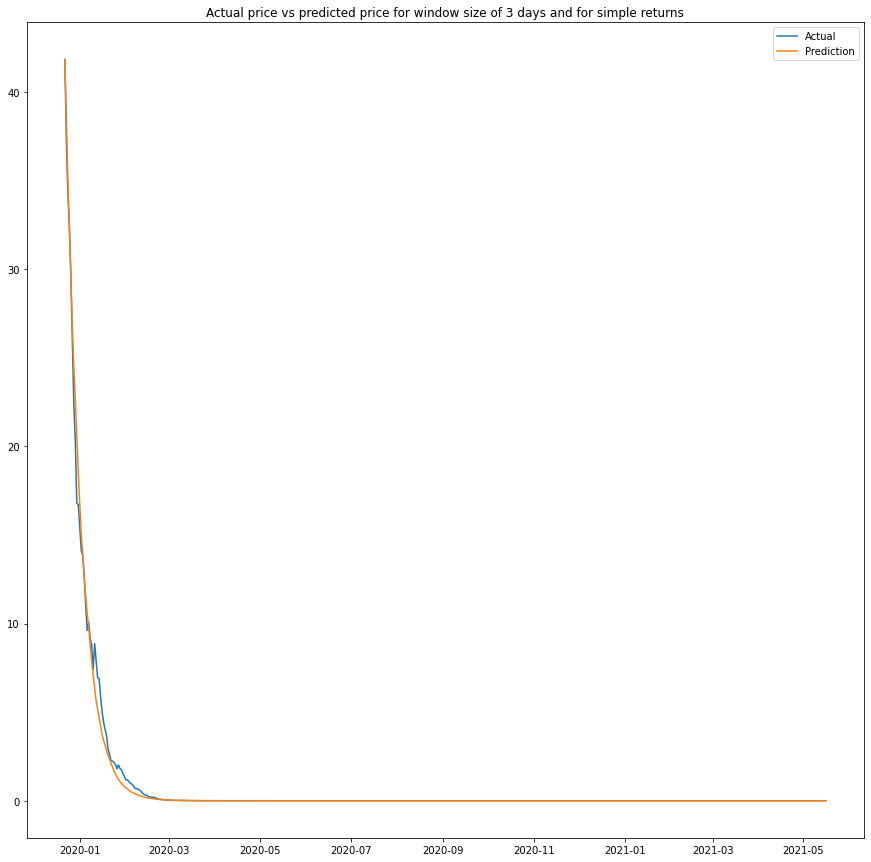

In [117]:
def unnormalize(x):
    xmin = df_LTC['test'].min()
    xmax = df_LTC['test'].max()
    x_new = xmin+(xmax-xmin)*(x+1)/2
    return x_new


def recover_price(y):
  x0 = 41.834
  # x0 = 40.381
  # x0 = 42.751
  # x0 = 57.2
  true_price = []
  for price in y:
    r = price*x0+x0
    x0 = r
    true_price.append(r)
  return np.array(true_price)   
def descale(y):
    
    return y*log_rets.std()+log_rets.mean()

def get_price_from_log_returns(log_returns):
    # t is time
    t = np.arange(len(log_returns))
    # stop = -abs(len(df_LTC['Date'][1200:])-len(log_returns))
    means = np.cumsum(log_returns)/(np.arange(len(log_returns))+1)
    init_value = df_LTC['Price'][1200]
    return init_value*np.exp(means*t)

# models_log té 4 tuples que es corresponen al model en qüestió. Cada tuple té [model,[train_data],[test_data],window_size]
# model,p_train1,dirs_train1,p_test1,dirs_test1,window_size,y_test

model_num = 1
m1 = models_log[model_num][0]
prices,dirs,w_size,y_true = models_log[model_num][3], models_log[model_num][4],models_log[model_num][5],models_log[model_num][6]
m1.reset_states()
print(prices.shape,dirs.shape)
preds = m1.predict({'left':prices,'middle':prices,'right':dirs},batch_size=16)
stop = -abs(len(df_LTC['Date'][1200:])-len(y_true))
dates = df_LTC['Date'][1200:stop]
plt.rcParams['figure.figsize'] = [15, 15]
# plt.plot(dates,y_true)
# plt.plot(dates,preds.flatten())
# plt.legend(['Actual','Prediction'])
# plt.title('Log returns vs predicted returns for window size of '+str(w_size)+' days')

y_true_u = unnormalize(y_true)
y_preds_u = unnormalize(preds.flatten())

# y_true_u = y_true
# y_preds_u = preds.flatten()

price_true = get_price_from_log_returns(y_true_u)
price_pred = get_price_from_log_returns(y_preds_u)

# price_true = recover_price(y_true_u)
# price_pred = recover_price(y_preds_u)

num_points = 512

plt.plot(dates[:num_points],price_true[:num_points])
plt.plot(dates[:num_points],price_pred[:num_points])
plt.legend(['Actual','Prediction'])
plt.title('Actual price vs predicted price for window size of '+str(w_size)+' days and for simple returns')
# preds_d = descale(preds)

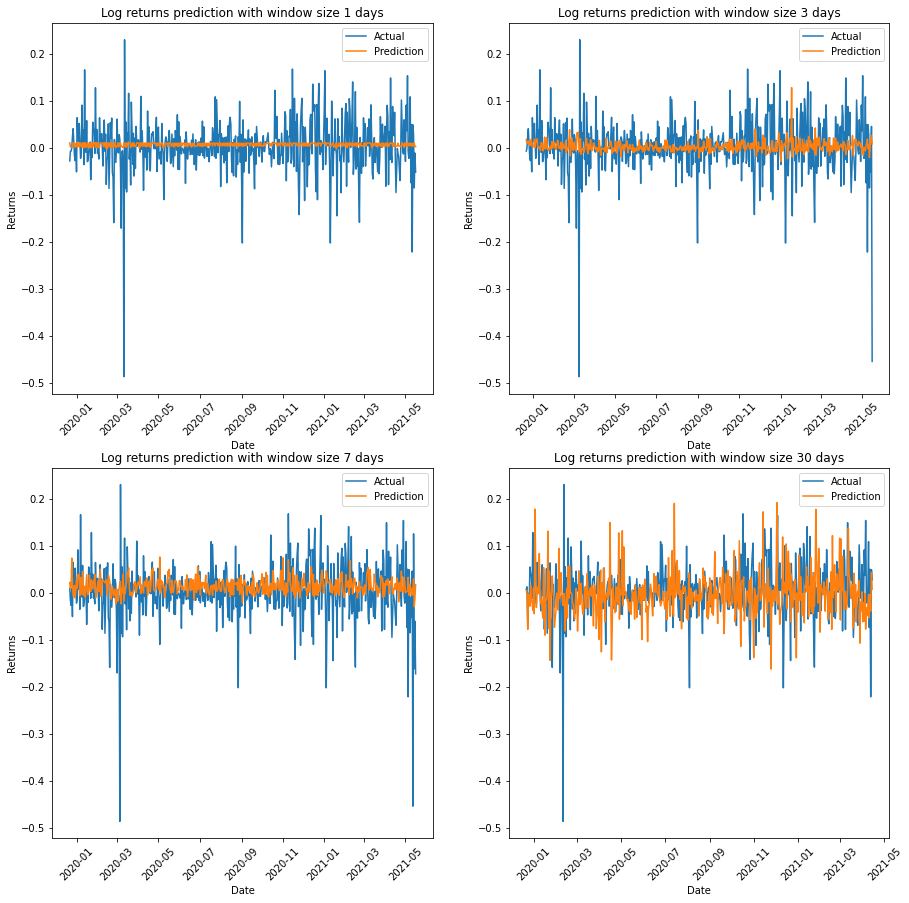

In [130]:
fig, axs = plt.subplots(2, 2)
for ax in axs.flatten():
    plt.sca(ax)
    plt.xticks(rotation = 45)
plt.rcParams['figure.figsize'] = [15, 15]
# name = model_names[k]
i = 0
j = 0
for model_num in range(4):
    if model_num == 0:
      i,j=0,0
      w_size=1
    elif model_num == 1:
      i,j=0,1
      w_size=3
    elif model_num == 2:
      i,j=1,0
      w_size=7
    elif model_num == 3:
      i,j=1,1
      w_size=30
    model = models_log[model_num]
    m,loss, val_loss,y_test,prices,dirs = model[0],model[-2],model[-1],model[6],model[3],model[4]
    stop = -abs(len(df_LTC['Date'][1200:])-len(y_test))
    dates = df_LTC['Date'][1200:stop]
    preds = m.predict({'left':prices,'middle':prices,'right':dirs},batch_size=16)

    # y_true_u = unnormalize(y_test)
    # y_preds_u = unnormalize(preds.flatten())

    # w_size = model[-3]
    axs[i, j].plot(dates,unnormalize2(y_test,df_LTC))
    axs[i, j].plot(dates,unnormalize2(preds.flatten(),df_LTC))
    axs[i,j].legend(['Actual','Prediction'])
    axs[i, j].set_xlabel('Date')
    axs[i, j].set_ylabel('Returns')
    axs[i, j].set_title(f'Log returns prediction with window size '+str(w_size)+' days')
    m.reset_states()

In [41]:
def get_init_value(log_returns,df):
    init_record = df[df['test'] == log_returns[0]]
    init_value = init_record['log_returns'].to_numpy()[0]

    return init_value

def get_price_from_log_returns2(log_returns,df,init_value):
    normal = unnormalize2(log_returns,df)
    t = np.arange(len(normal))
    means = np.cumsum(normal)/(np.arange(len(normal))+1)

    # init_value = df['Price'][stop]
    # print(init_value)
    return init_value*np.exp(means*t)

def unnormalize2(x,df):
    xmin = df['log_returns'].min()
    xmax = df['log_returns'].max()
    x_new = xmin+(xmax-xmin)*(x+1)/2
    # print(x_new.shape,x.shape)
    return x_new

def ttt(log_returns,preds,df):

  def get_price_from_preds(preds,prev_p):
    pred_prices = []
    for i in range(len(preds)):
      
      p = prev_p*np.exp(preds[i])
      pred_prices.append(p)
      prev_p = p

    return np.array(pred_prices)
  indxs = np.arange(len(df))
  df_t = df 
  df_t.index= np.arange(len(df))
  first_log = log_returns[0]


  ind = df_t[df_t['test'] == first_log].index
  prices = df_t.iloc[ind[0]:]['Price'].to_numpy()
  dates = df_t.iloc[ind[0]:]['Date'].to_numpy()
  prev_p = df_t.iloc[ind[0]-1]['Price']

  pred_prices = get_price_from_preds(preds,prev_p)
  prices = prices[:len(pred_prices)]
  dates = dates[:len(pred_prices)]

  
  return prices,pred_prices,dates

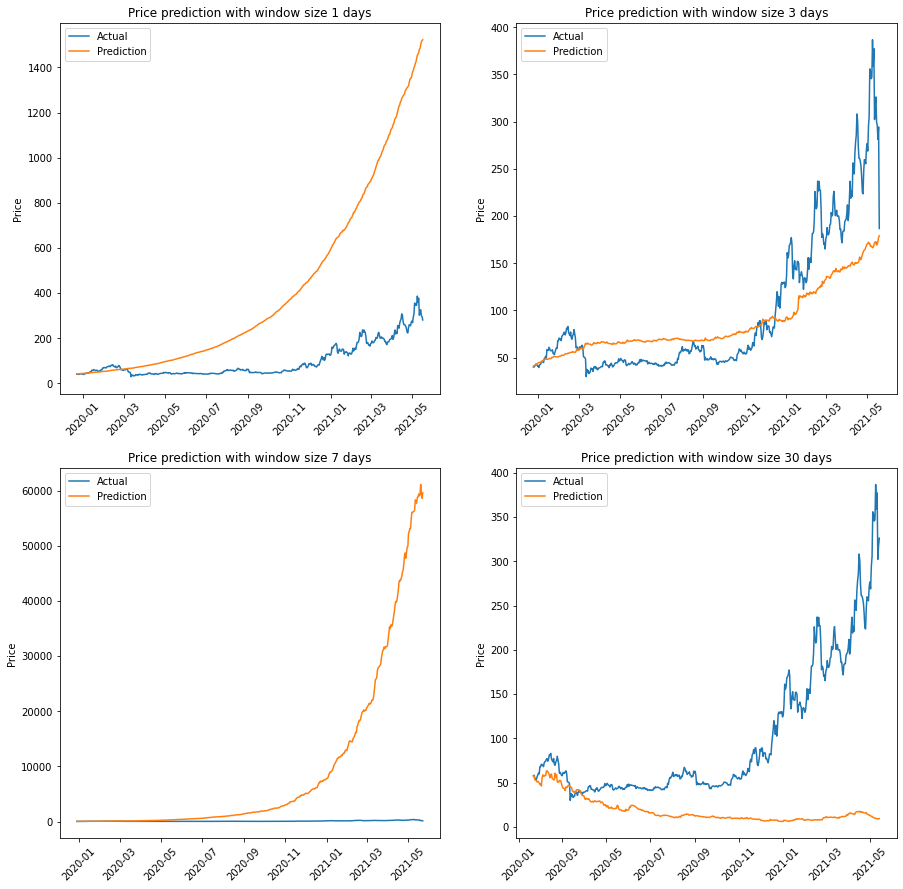

In [123]:
fig, axs = plt.subplots(2, 2)
# models_log.append((model,p_train1,dirs_train1,p_test1,dirs_test1,window_size,y_test,y_train,loss,val_loss))
# fig.suptitle('Price prediction')
for ax in axs.flatten():
    plt.sca(ax)
    plt.xticks(rotation = 45)
plt.rcParams['figure.figsize'] = [15, 15]
# name = model_names[k]
i = 0
j = 0
for model_num in range(4):
    if model_num == 0:
      i,j=0,0
      w_size=1
      y = y1
    elif model_num == 1:
      i,j=0,1
      w_size=3
      y = y3
    elif model_num == 2:
      i,j=1,0
      w_size=7
      y = y7
    elif model_num == 3:
      i,j=1,1
      w_size=30
      y = y30
      
    model = models_log[model_num]
    m,loss, val_loss,y_test,prices,dirs = model[0],model[-2],model[-1],model[6],model[3],model[4]
    # stop = -abs(len(y_test))
    # dates = df_LTC['Date'][stop:]
    preds = m.predict({'left':prices,'middle':prices,'right':dirs},batch_size=16)


    # init_value = get_init_value(y_test,df_LTC)
    # if model_num ==3:
      # print(unnormalize2(preds.flatten(),df_LTC))
      # 4.63026762e-03 -4.73624468e-03 -7.82028139e-02 -3.06835771e-03 -1.08898580e-02 -2.90377140e-02  1.56973898e-02 -1.52794421e-02

    price_true,price_pred,dates = ttt(y_test,unnormalize2(preds.flatten(),df_LTC),df_LTC)

    axs[i, j].plot(dates,price_true)
    axs[i, j].plot(dates,price_pred)
    axs[i,j].legend(['Actual','Prediction'])

    axs[i, j].set_ylabel('Price')
    axs[i, j].set_title(f'Price prediction with window size '+str(w_size)+' days')
    m.reset_states()

In [43]:
# y_true_u

In [44]:
%matplotlib inline

In [45]:
X_train.shape

(1200, 30, 2)

## LSTM models

In [46]:
model_num = 3
window_size = models_log[model_num][5]
tf.keras.backend.clear_session()
tf.random.set_seed(seed)
m2 = Sequential()
m2.add(Input(shape=(window_size,1),batch_size=16))
m2.add(LSTM(50,stateful=True))
m2.add(Dense(1,activation='linear'))

X_train=models_log[model_num][1]
y_train=models_log[model_num][7]
X_test=models_log[model_num][3]
y_test=models_log[model_num][6]

m2.compile(optimizer='adam',loss='mse',metrics=['MeanSquaredError'])
for i in range(nb_epochs):
  m2.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=16,epochs=1)
  m2.reset_states()

75/75 [==============================] - 1s 7ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0110 - val_mean_squared_error: 0.0110


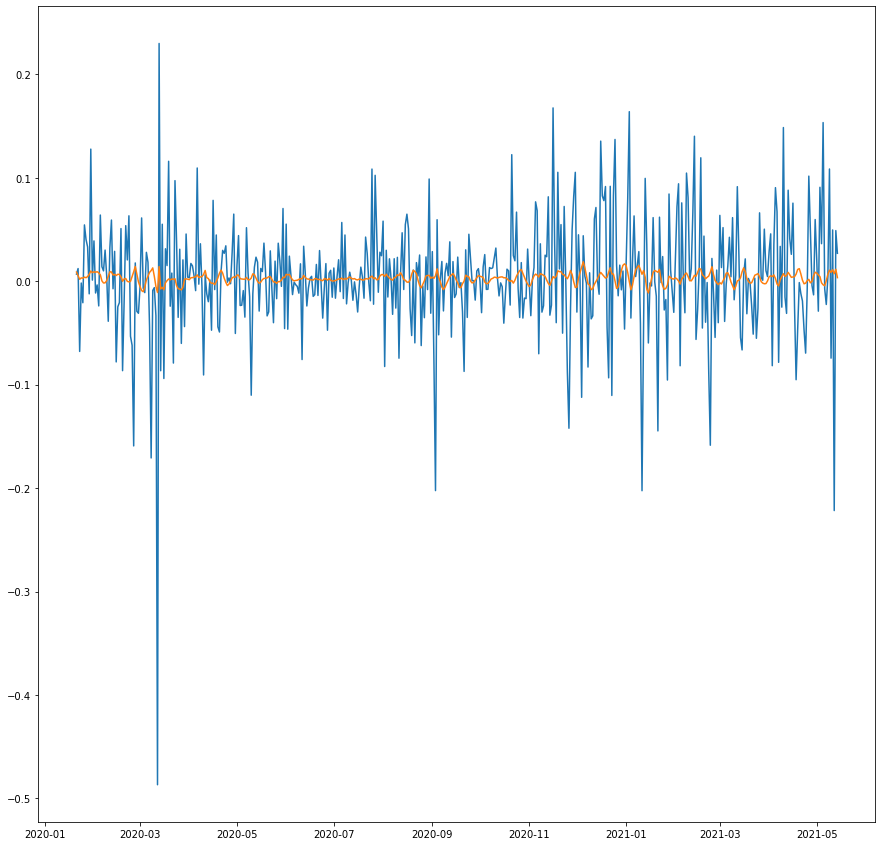

In [47]:
preds = m2.predict(X_test,batch_size=16)
num_points = 480
y_true = models_log[model_num][6]
y_true_u = unnormalize(y_true)
y_preds_u = unnormalize(preds.flatten())

price_true = recover_price(y_true_u)
price_pred = recover_price(y_preds_u)

plt.rcParams['figure.figsize'] = [15, 15]
plt.plot(dates[:num_points],y_true_u[:num_points])
plt.plot(dates[:num_points],y_preds_u[:num_points])

In [48]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed)
model_num = 3
window_size = models_log[model_num][5]
m3 = Sequential()
m3.add(Input(shape=(window_size,1),batch_size=16))
m3.add(Conv1D(filters=16,kernel_size=2))
m3.add(Conv1D(filters=32,kernel_size=2))
m3.add(LSTM(50,stateful=True))
m3.add(Dense(1,activation='linear'))


X_train=models_log[model_num][1]
y_train=models_log[model_num][7]
X_test=models_log[model_num][3]
y_test=models_log[model_num][6]

m3.compile(optimizer='adam',loss='mse',metrics=['MeanSquaredError'])
for i in range(nb_epochs):
  m3.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=16,epochs=1)
  m3.reset_states()

75/75 [==============================] - 1s 8ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0118 - val_mean_squared_error: 0.0118


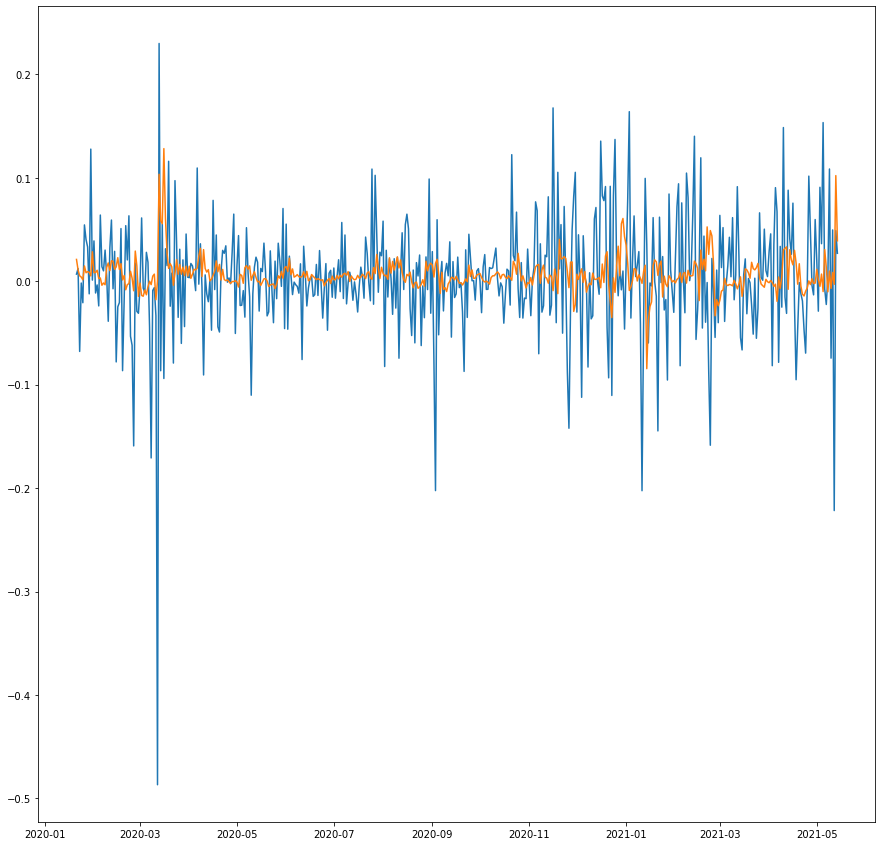

In [49]:
preds = m3.predict(X_test,batch_size=16)
num_points = 480
y_true = models_log[model_num][6]
y_true_u = unnormalize(y_true)
y_preds_u = unnormalize(preds.flatten())

price_true = recover_price(y_true_u)
price_pred = recover_price(y_preds_u)

plt.rcParams['figure.figsize'] = [15, 15]
plt.plot(dates[:num_points],y_true_u[:num_points])
plt.plot(dates[:num_points],y_preds_u[:num_points])

In [50]:
X_train.shape

(1200, 30, 1)

# Using defi info to predict WBTC price

In [51]:
df_defi = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/defi_transf.csv',index_col=0)
# df_defi

In [52]:
df_defi['wbtc_log_returns'] = np.log(df_defi['close']/df_defi['close'].shift(1))
df_defi['wbtc_test'] = 2*(df_defi['wbtc_log_returns']-df_defi['wbtc_log_returns'].min())/(df_defi['wbtc_log_returns'].max()-df_defi['wbtc_log_returns'].min())-1
df_defi = df_defi.dropna()

In [53]:
df_defi

time.1          open          high           low  \
time                                                               
2021-05-06  2021-05-06  57349.226542  58046.240184  55602.797024   
2021-05-07  2021-05-07  56330.055565  58438.947509  55114.135939   
2021-05-08  2021-05-08  57385.190458  59761.469619  57295.293558   
2021-05-09  2021-05-09  58922.044819  59081.992956  56533.630931   
2021-05-10  2021-05-10  58258.593575  59522.203613  53617.680518   
...                ...           ...           ...           ...   
2022-04-30  2022-04-30  38513.666884  38692.105932  37637.017805   
2022-05-01  2022-05-01  37639.364560  38651.408536  37639.364560   
2022-05-02  2022-05-02  38614.473465  39053.967180  38222.918247   
2022-05-03  2022-05-03  38511.633642  38590.164663  37647.645060   
2022-05-04  2022-05-04  37798.657279  39873.715476  37798.657279   

                   close  positive  negative  wbtc_log_returns  wbtc_test  
time                                                                       
2021-05-06  56330.055565         0         0         -0.017931  -0.055440  
2021-05-07  57385.190458         0         0          0.018558   0.190949  
2021-05-08  58922.044819         0         1          0.026429   0.244097  
2021-05-09  58258.593575         0         0         -0.011324  -0.010824  
2021-05-10  55891.031609         0         1         -0.041488  -0.214504  
...                  ...       ...       ...               ...        ...  
2022-04-30  37639.364560         1         0         -0.022963  -0.089416  
2022-05-01  38614.473465         1         0          0.025577   0.238342  
2022-05-02  38511.633642         0         3         -0.002667   0.047630  
2022-05-03  37798.657279         1         0         -0.018687  -0.060543  
2022-05-04  39720.961684         1         1          0.049605   0.400594  

[364 rows x 9 columns]

## This is a repeated cell

In [54]:
df_LTC2 = load_df('/content/drive/MyDrive/Colab Notebooks/datasets/ltc-investing-may.csv')

df_BTC3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/btc-investing-may.csv',index_col=False)
# df_BTC = pd.read_csv('datasets/BTC-paper1.csv',index_col=False)
df_BTC3.isna().sum()
# df_BTC[['Price','Open','High','Low']] =df_BTC[['Price','Open','High','Low']].applymap(lambda x: x.replace(".","a"))
# df_BTC[['Price','Open','High','Low']] =df_BTC[['Price','Open','High','Low']].applymap(lambda x: x.replace(",","."))
df_BTC3[['Price','Open','High','Low']] = df_BTC3[['Price','Open','High','Low']].applymap(lambda x: x.replace(",",""))
df_BTC3[['Date']] = df_BTC3[['Date']].applymap(lambda x: x.replace(",",""))
df_BTC3[['Price','Open','High','Low']] = df_BTC3[['Price','Open','High','Low']].astype('float')


price = df_BTC3['Price'].to_numpy()
open = df_BTC3['Open'].to_numpy()
dir = []
for i in range(len(price)):
    if price[i]>open[i]:
        dir.append(1)
    else:
        dir.append(-1)
df_BTC3['Direction'] = np.array(dir)

df_LTC2['directions'] = np.array(dir)

df_LTC2['log_returns'] = np.log(df_LTC2['Price']/df_LTC2['Price'].shift(1))
df_LTC2['test'] = 2*(df_LTC2['log_returns']-df_LTC2['log_returns'].min())/(df_LTC2['log_returns'].max()-df_LTC2['log_returns'].min())-1
df_LTC2 = df_LTC2.dropna()
df_LTC2 = df_LTC2.iloc[:-1]
df_LTC2['positive'] = df_defi['positive'].to_numpy()
df_LTC2['negative'] = df_defi['negative'].to_numpy()

df_LTC2

Date    Price     Open     High      Low     Vol. Change %  \
Date                                                                          
2021-05-06 2021-05-06  353.380  356.136  364.758  318.986    2.75M   -0.72%   
2021-05-07 2021-05-07  345.537  353.380  372.264  333.893  329.82M   -2.22%   
2021-05-08 2021-05-08  347.030  345.199  356.507  334.242  325.56M    0.43%   
2021-05-09 2021-05-09  386.820  347.129  388.956  334.673    2.29M   11.47%   
2021-05-10 2021-05-10  359.106  387.812  412.802  335.177  356.90M   -7.16%   
...               ...      ...      ...      ...      ...      ...      ...   
2022-04-30 2022-04-30   95.900  100.400  101.500   94.000  344.04K   -4.39%   
2022-05-01 2022-05-01   99.200   95.900  100.000   94.600  295.50K    3.44%   
2022-05-02 2022-05-02  100.700   99.200  101.700   98.300  330.39K    1.51%   
2022-05-03 2022-05-03   99.400  100.700  101.400   97.500  307.96K   -1.29%   
2022-05-04 2022-05-04  106.300   99.400  107.100   99.000  475.28K    6.94%   

            directions  log_returns      test  positive  negative  
Date                                                               
2021-05-06           1    -0.007266  0.258025         0         0  
2021-05-07          -1    -0.022444  0.215314         0         0  
2021-05-08           1     0.004312  0.290603         0         1  
2021-05-09           1     0.108548  0.583918         0         0  
2021-05-10          -1    -0.074342  0.069278         0         1  
...                ...          ...       ...       ...       ...  
2022-04-30          -1    -0.044860  0.152239         1         0  
2022-05-01          -1     0.033832  0.373672         1         0  
2022-05-02           1     0.015008  0.320702         0         3  
2022-05-03           1    -0.012994  0.241907         1         0  
2022-05-04          -1     0.067113  0.467323         1         1  

[364 rows x 12 columns]

In [55]:
df_defi2 = df_defi[['close','wbtc_log_returns','wbtc_test','positive','negative']]
df_defi2['test'] = df_LTC2['test'].to_numpy()
df_defi2['log_returns'] = df_LTC2['log_returns'].to_numpy()
df_defi2['Price'] = df_LTC2['Price'].to_numpy()
df_defi2['Date'] = df_LTC2['Date'].to_numpy()
df_defi2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

close  wbtc_log_returns  wbtc_test  positive  negative  \
time                                                                        
2021-05-06  56330.055565         -0.017931  -0.055440         0         0   
2021-05-07  57385.190458          0.018558   0.190949         0         0   
2021-05-08  58922.044819          0.026429   0.244097         0         1   
2021-05-09  58258.593575         -0.011324  -0.010824         0         0   
2021-05-10  55891.031609         -0.041488  -0.214504         0         1   
...                  ...               ...        ...       ...       ...   
2022-04-30  37639.364560         -0.022963  -0.089416         1         0   
2022-05-01  38614.473465          0.025577   0.238342         1         0   
2022-05-02  38511.633642         -0.002667   0.047630         0         3   
2022-05-03  37798.657279         -0.018687  -0.060543         1         0   
2022-05-04  39720.961684          0.049605   0.400594         1         1   

                test  log_returns    Price       Date  
time                                                   
2021-05-06  0.258025    -0.007266  353.380 2021-05-06  
2021-05-07  0.215314    -0.022444  345.537 2021-05-07  
2021-05-08  0.290603     0.004312  347.030 2021-05-08  
2021-05-09  0.583918     0.108548  386.820 2021-05-09  
2021-05-10  0.069278    -0.074342  359.106 2021-05-10  
...              ...          ...      ...        ...  
2022-04-30  0.152239    -0.044860   95.900 2022-04-30  
2022-05-01  0.373672     0.033832   99.200 2022-05-01  
2022-05-02  0.320702     0.015008  100.700 2022-05-02  
2022-05-03  0.241907    -0.012994   99.400 2022-05-03  
2022-05-04  0.467323     0.067113  106.300 2022-05-04  

[364 rows x 9 columns]

In [56]:
# close = df_defi['close']
# positives = df_defi['positive']
# negatives = df_defi['negative']

# X1,y1 = tfmfuncs.df_to_X_y(df_defi,columns=['log_returns','positive','negative'],window_size=1)
# X3,y3 = tfmfuncs.df_to_X_y(df_defi,columns=['log_returns','positive','negative'],window_size=3)
# X7,y7 = tfmfuncs.df_to_X_y(df_defi,columns=['log_returns','positive','negative'],window_size=7)
# X30,y30 = tfmfuncs.df_to_X_y(df_defi,columns=['log_returns','positive','negative'],window_size=30)

X1,y1 = tfmfuncs.df_to_X_y(df_defi2,columns=['test','positive','negative'],window_size=1)
X3,y3 = tfmfuncs.df_to_X_y(df_defi2,columns=['test','positive','negative'],window_size=3)
X7,y7 = tfmfuncs.df_to_X_y(df_defi2,columns=['test','positive','negative'],window_size=7)
X30,y30 = tfmfuncs.df_to_X_y(df_defi2,columns=['test','positive','negative'],window_size=30)


In [57]:
X1_prices = X1[:,0,0]
X1_poss = X1[:,0,1]
X1_negs = X1[:,0,2]

X3_prices = X3[:,:,0]
X3_poss = X3[:,:,1]
X3_negs = X3[:,:,2]

X7_prices = X7[:,:,0]
X7_poss = X7[:,:,1]
X7_negs = X7[:,:,2]

X30_prices = X30[:,:,0]
X30_poss = X30[:,:,1]
X30_negs = X30[:,:,2]

In [58]:
def split_ds2(X,pct=0.9):
  target = int(len(X)*pct)
  X_train = X[:target]
  X_test = X[target:]
  
  return (X_train,X_test)

def adapt_ds2(X):
    window_size = len(X[0,:])
    # prices = X[:,:,0].reshape(len(X),window_size,1)
    # directions = X[:,:,1].reshape(len(X),window_size,1)
    prices = X[:,:,0]
    poss = X[:,:,1]
    negs = X[:,:,2]
    return prices, poss, negs

def resize_ds2(X):
    resize = (len(X)//16)*16
    X = X[:resize]

    return X

In [59]:
def build_TFM_model(X,batch_size):
    window_size = len(X[0,:])

    prices_input = Input(shape=(window_size,1), name="prices",batch_size=batch_size)
    positives_input = Input(shape=(window_size,1), name="positives",batch_size=batch_size)
    negatives_input = Input(shape=(window_size,1), name="negatives",batch_size=batch_size)


    prices = LSTM(32,return_sequences=True,stateful=True,name="prices-LSTM")(prices_input)
    prices = Dropout(0.25,name="prices-Dropout")(prices)
    prices = GRU(64,stateful=True,name="prices-GRU")(prices)
    # prices = Flatten()(prices)
    prices = Dense(16,activation='relu',name="prices-Dense")(prices)
    
    # right_leg = Flatten()(right_leg_input)
    positives = Dense(16,activation='relu',name="positives-Dense")(positives_input)
    positives = Flatten(name="positives-Flatten")(positives)
    # right_leg = Dense(10,activation='relu')(right_leg)
    negatives = Dense(16,activation='relu',name="negatives-Dense")(negatives_input)
    negatives = Flatten(name="negativess-Flatten")(negatives)

    x = concatenate([prices,positives,negatives])
    x = Dense(32,activation='relu')(x)
    x = Dense(1,activation='linear',name='target')(x)

    inputs = [prices_input,positives_input,negatives_input]
    output = x

    model = Model(inputs=inputs,outputs=output)

    return model

In [60]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed)

In [61]:
datasets = [(X1,y1),(X3,y3),(X7,y7),(X30,y30)]
nb_epochs = 25
models_defi = []
j=0
for dataset in datasets:
    print(f'Training {j}')
    X = dataset[0]
    y = dataset[1]
    X_train, X_test = split_ds2(X,pct=0.9)
    y_train, y_test = split_ds2(y,pct=0.9)

    prices_train, poss_train, negs_train = adapt_ds2(X_train)
    prices_test, poss_test, negs_test = adapt_ds2(X_test)

    # X_test,y_test = resize_ds(X_test,y_test)
    prices_train = resize_ds2(prices_train)
    poss_train = resize_ds2(poss_train)
    negs_train = resize_ds2(negs_train)
    y_train = resize_ds2(y_train).flatten()

    prices_test = resize_ds2(prices_test)
    poss_test = resize_ds2(poss_test)
    negs_test = resize_ds2(negs_test)
    y_test = resize_ds2(y_test).flatten()

    print(f'X_train & y_train: {X_train.shape},{y_train.shape}\nX_test & y_test: {X_test.shape},{y_test.shape}')
    print(f'prices_train, poss_train & negs_train: {prices_train.shape},{poss_train.shape},{poss_train.shape}\n')

    model = build_TFM_model(X_train,batch_size=16)
    window_size = len(X_train[0,:])
    # p_train1, dirs_train1 = adapt_ds(X_train)
    # p_test1, dirs_test1 = adapt_ds(X_test)
    model.compile(optimizer='adam',loss='mse',metrics=['MeanSquaredError'])
    loss = []
    val_loss = []
    # model.summary()
    for i in range(nb_epochs):
        print(f'Epoch {i}')
        history = model.fit({'prices':prices_train,'positives':poss_train,'negatives':negs_train},{'target':y_train},validation_data=({'prices':prices_test,'positives':poss_test,'negatives':negs_test},{'target':y_test}),epochs=1,batch_size=16)
        loss.append(history.history['loss'][0])
        val_loss.append(history.history['val_loss'][0])
        model.reset_states()

    models_defi.append((model,prices_test,poss_test,negs_test,y_test,window_size,loss,val_loss))
    model.save(f'models/tfm-defi-{window_size}.h5')
    tf.keras.backend.clear_session()
    j+=1
    print(f'Done training\n')

Training 0
X_train & y_train: (326, 1, 3),(320,)
X_test & y_test: (37, 1, 3),(32,)
prices_train, poss_train & negs_train: (320, 1),(320, 1),(320, 1)

Epoch 0
20/20 [==============================] - 3s 32ms/step - loss: 0.0607 - mean_squared_error: 0.0607 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 1
20/20 [==============================] - 0s 5ms/step - loss: 0.0355 - mean_squared_error: 0.0355 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 2
20/20 [==============================] - 0s 4ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 3
20/20 [==============================] - 0s 4ms/step - loss: 0.0292 - mean_squared_error: 0.0292 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 4
20/20 [==============================] - 0s 4ms/step - loss: 0.0276 - mean_squared_error: 0.0276 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 5
20/20 [==============================] - 0s 4ms/step - l

(32, 30) (32, 30) (32, 30)


Text(0.5, 1.0, 'Actual price vs predicted price for window size of 30 days and for simple returns')

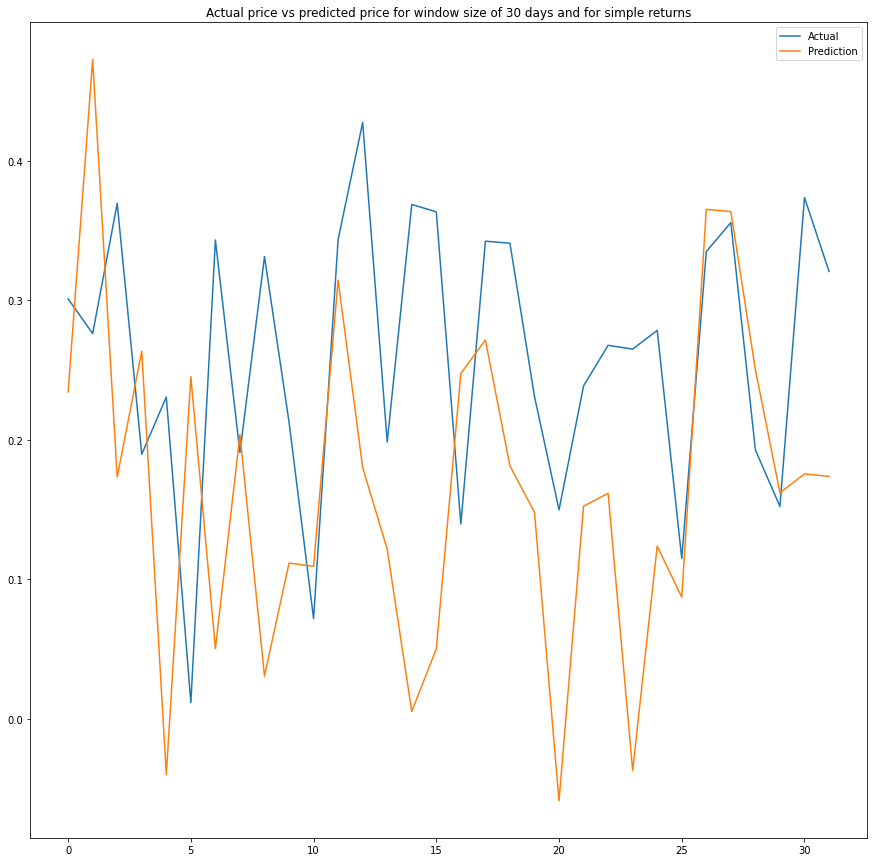

In [62]:
model_num = 3
m1 = models_defi[model_num][0]
prices,poss,negs,y_test,w_size = models_defi[model_num][1], models_defi[model_num][2],models_defi[model_num][3],models_defi[model_num][4],models_defi[model_num][5]
m1.reset_states()
print(prices.shape,poss.shape,negs.shape)
preds = m1.predict({'prices':prices,'positives':poss,'negatives':negs},batch_size=16)
stop = -abs(len(df_LTC['Date'][1200:])-len(y_true))
# dates = df_LTC['Date'][1200:stop]
plt.rcParams['figure.figsize'] = [15, 15]
# plt.plot(dates,y_true)
# plt.plot(dates,preds.flatten())
# plt.legend(['Actual','Prediction'])
# plt.title('Log returns vs predicted returns for window size of '+str(w_size)+' days')

# y_true_u = unnormalize(y_true)
# y_preds_u = unnormalize(preds.flatten())

y_true_u = y_test
y_preds_u = preds.flatten()

# price_true = get_price_from_log_returns(y_true_u)
# price_pred = get_price_from_log_returns(y_preds_u)

# price_true = recover_price(y_true_u)
# price_pred = recover_price(y_preds_u)

# num_points = 512

# plt.plot(dates[:num_points],price_true[:num_points])
# plt.plot(dates[:num_points],price_pred[:num_points])
plt.plot(y_true_u)
plt.plot(y_preds_u)
plt.legend(['Actual','Prediction'])
plt.title('Actual price vs predicted price for window size of '+str(w_size)+' days and for simple returns')

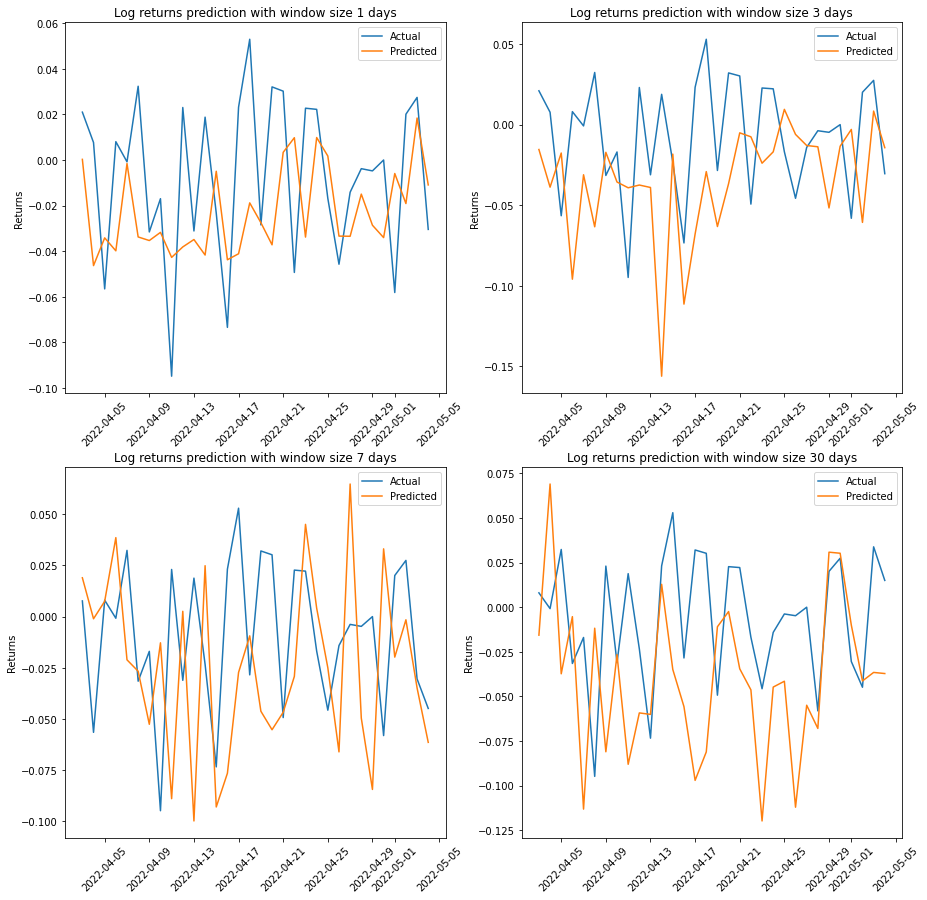

In [63]:
fig, axs = plt.subplots(2, 2)
# models_log.append((model,p_train1,dirs_train1,p_test1,dirs_test1,window_size,y_test,y_train,loss,val_loss))
# fig.suptitle('Price prediction')
plt.rcParams['figure.figsize'] = [15, 15]
for ax in axs.flatten():
    plt.sca(ax)
    plt.xticks(rotation = 45)
# name = model_names[k]
i = 0
j = 0
for model_num in range(4):
    if model_num == 0:
      i,j=0,0
      w_size=1
      y = y1
    elif model_num == 1:
      i,j=0,1
      w_size=3
      y = y3
    elif model_num == 2:
      i,j=1,0
      w_size=7
      y = y7
    elif model_num == 3:
      i,j=1,1
      w_size=30
      y = y30
    model = models_defi[model_num]
    m,loss, val_loss,prices,poss,negs,y_test = model[0],model[-2],model[-1],model[1],model[2],model[3],model[4]
    stop = -abs(len(y_test))
    dates = df_defi2['Date'][stop:]
    preds = m.predict({'prices':prices,'positives':poss,'negatives':negs},batch_size=16)

    # y_true_u = unnormalize(y_test)
    # y_preds_u = unnormalize(preds.flatten())

    # w_size = model[-3]
    axs[i, j].plot(dates,unnormalize2(y_test,df_defi2))
    axs[i, j].plot(dates,unnormalize2(preds.flatten(),df_defi2))
    axs[i,j].legend(['Actual','Predicted'])
    # props = {"rotation" : 30}
    # plt.xticks(rotation = 45)
    # axs[i, j].set_xlabel('Date')
    axs[i, j].set_ylabel('Returns')
    axs[i, j].set_title(f'Log returns prediction with window size '+str(w_size)+' days')
    m.reset_states()

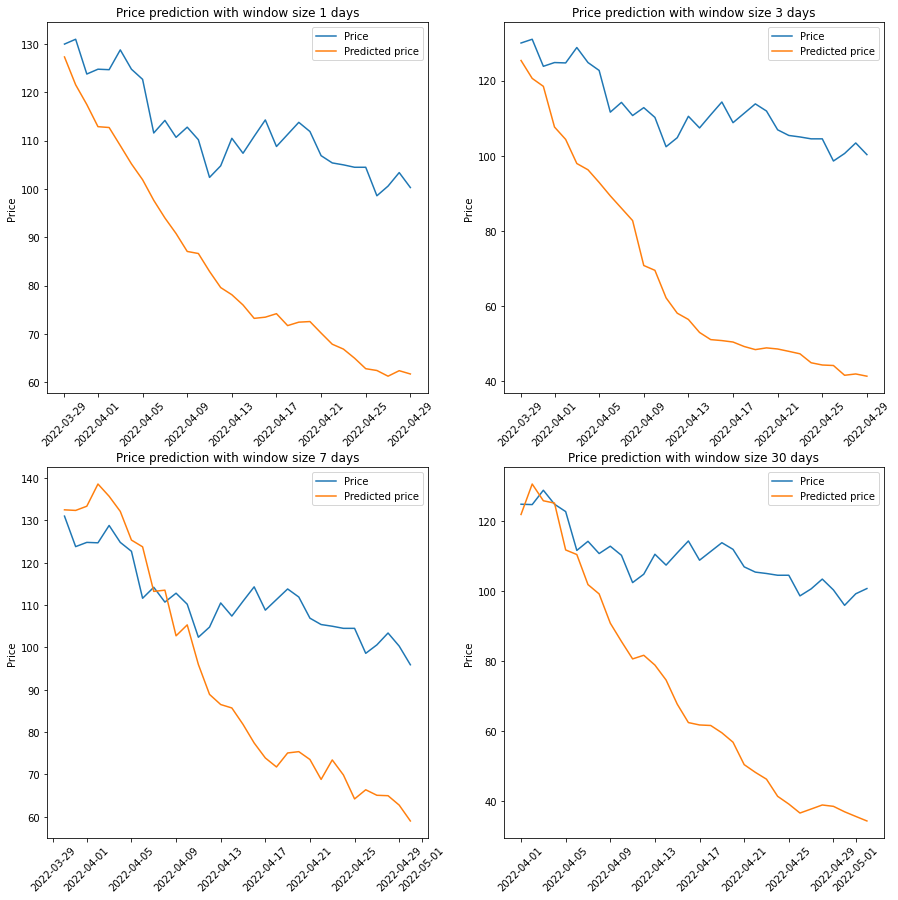

In [64]:
fig, axs = plt.subplots(2, 2)
# models_log.append((model,p_train1,dirs_train1,p_test1,dirs_test1,window_size,y_test,y_train,loss,val_loss))
# fig.suptitle('Price prediction')
for ax in axs.flatten():
    plt.sca(ax)
    plt.xticks(rotation = 45)
plt.rcParams['figure.figsize'] = [15, 15]
# name = model_names[k]
i = 0
j = 0
for model_num in range(4):
    if model_num == 0:
      i,j=0,0
      w_size=1
      y = y1
    elif model_num == 1:
      i,j=0,1
      w_size=3
      y = y3
    elif model_num == 2:
      i,j=1,0
      w_size=7
      y = y7
    elif model_num == 3:
      i,j=1,1
      w_size=30
      y = y30
      
    model = models_defi[model_num]
    m,loss, val_loss,prices,poss,negs,y_test = model[0],model[-2],model[-1],model[1],model[2],model[3],model[4]
    # print(len(y_test))
    stop = -abs(len(y_test))
    # dates = df_LTC2['Date'][stop:]
    preds = m.predict({'prices':prices,'positives':poss,'negatives':negs},batch_size=16)

    # y_true_u = unnormalize(y_test)
    # y_preds_u = unnormalize(preds.flatten())
    # print(y_test.shape,preds.flatten().shape)
    init_value = get_init_value(y_test,df_defi2)
    # price_true = get_price_from_log_returns2(y_test,df=df_LTC2,init_value=init_value)
    # price_pred = get_price_from_log_returns2(preds.flatten(),df=df_LTC2,init_value=init_value)
    price_true,price_pred,dates = ttt(y_test,unnormalize2(preds.flatten(),df_defi2),df_defi2)
    # print(unnormalize2(preds.flatten(),df_LTC2))
    # w_size = model[-3]
    axs[i, j].plot(dates,price_true)
    axs[i, j].plot(dates,price_pred)
    axs[i,j].legend(['Price','Predicted price'])
    # axs[i, j].set_xlabel('Date')
    axs[i, j].set_ylabel('Price')
    axs[i, j].set_title(f'Price prediction with window size '+str(w_size)+' days')
    m.reset_states()

# WBTC with Davidson model using BTC directions

In [65]:
df_wbtc = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/wbtc-usd-max.csv')
df_wbtc = df_wbtc.iloc[824:1189]  #824

In [66]:
df_wbtc['log_returns'] = np.log(df_wbtc['price']/df_wbtc['price'].shift(1))
df_wbtc['test'] = 2*(df_wbtc['log_returns']-df_wbtc['log_returns'].min())/(df_wbtc['log_returns'].max()-df_wbtc['log_returns'].min())-1
df_wbtc = df_wbtc.dropna()
df_wbtc

snapped_at         price    market_cap  total_volume  \
825   2021-05-06 00:00:00 UTC  57346.310542  9.769761e+09  5.942267e+08   
826   2021-05-07 00:00:00 UTC  56602.458382  9.643780e+09  4.613733e+08   
827   2021-05-08 00:00:00 UTC  57388.056686  9.761440e+09  4.129184e+08   
828   2021-05-09 00:00:00 UTC  58858.645895  1.002739e+10  8.071391e+08   
829   2021-05-10 00:00:00 UTC  58242.189879  9.966416e+09  5.122526e+08   
...                       ...           ...           ...           ...   
1184  2022-04-30 00:00:00 UTC  38628.691334  1.089282e+10  2.695326e+08   
1185  2022-05-01 00:00:00 UTC  37812.699488  1.064035e+10  2.537283e+08   
1186  2022-05-02 00:00:00 UTC  38567.172165  1.087007e+10  3.732669e+08   
1187  2022-05-03 00:00:00 UTC  38647.653485  1.088741e+10  4.775271e+08   
1188  2022-05-04 00:00:00 UTC  37826.665254  1.066135e+10  3.085935e+08   

      log_returns      test  
825      0.066272  0.515529  
826     -0.013056 -0.051573  
827      0.013784  0.140300  
828      0.025303  0.222645  
829     -0.010529 -0.033506  
...           ...       ...  
1184    -0.028674 -0.163225  
1185    -0.021350 -0.110867  
1186     0.019756  0.182997  
1187     0.002085  0.056665  
1188    -0.021472 -0.111735  

[364 rows x 6 columns]

In [67]:
df_BTC2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/btc-investing-may.csv',index_col=False)
# df_BTC = pd.read_csv('datasets/BTC-paper1.csv',index_col=False)
df_BTC2.isna().sum()
# df_BTC[['Price','Open','High','Low']] =df_BTC[['Price','Open','High','Low']].applymap(lambda x: x.replace(".","a"))
# df_BTC[['Price','Open','High','Low']] =df_BTC[['Price','Open','High','Low']].applymap(lambda x: x.replace(",","."))
df_BTC2[['Price','Open','High','Low']] = df_BTC2[['Price','Open','High','Low']].applymap(lambda x: x.replace(",",""))
df_BTC2[['Date']] = df_BTC2[['Date']].applymap(lambda x: x.replace(",",""))
df_BTC2[['Price','Open','High','Low']] = df_BTC2[['Price','Open','High','Low']].astype('float')


price = df_BTC2['Price'].to_numpy()
open = df_BTC2['Open'].to_numpy()
dir = []
for i in range(len(price)):
    if price[i]>open[i]:
        dir.append(1)
    else:
        dir.append(-1)
df_BTC2['Direction'] = np.array(dir)
df_BTC2['Date'] = pd.to_datetime(df_BTC2['Date'],format='%b %d %Y')
df_BTC2.index = df_BTC2['Date']
df_BTC2 = df_BTC2.sort_index()

df_BTC2

Date    Price     Open     High      Low     Vol. Change %  \
Date                                                                          
2021-05-05 2021-05-05  57441.3  53872.5  57936.4  53872.5  119.82K    6.88%   
2021-05-06 2021-05-06  56405.4  57441.0  58364.9  55294.5  109.02K   -1.80%   
2021-05-07 2021-05-07  57337.2  56411.4  58639.3  55300.1  110.01K    1.65%   
2021-05-08 2021-05-08  58840.1  57330.3  59471.1  56972.2  101.27K    2.62%   
2021-05-09 2021-05-09  58238.3  58840.6  59227.0  56414.4  103.59K   -1.02%   
...               ...      ...      ...      ...      ...      ...      ...   
2022-05-01 2022-05-01  38461.0  37642.0  38676.0  37397.0  276.99M    2.15%   
2022-05-02 2022-05-02  38514.0  38472.0  39134.0  38061.0  580.79M    0.14%   
2022-05-03 2022-05-03  37718.0  38515.0  38647.0  37513.0  367.21M   -2.07%   
2022-05-04 2022-05-04  39688.0  37717.0  40021.0  37660.0  691.49M    5.22%   
2022-05-05 2022-05-05  36544.0  39686.0  39833.0  36183.0    1.04B   -7.92%   

            Direction  
Date                   
2021-05-05          1  
2021-05-06         -1  
2021-05-07          1  
2021-05-08          1  
2021-05-09         -1  
...               ...  
2022-05-01          1  
2022-05-02          1  
2022-05-03         -1  
2022-05-04          1  
2022-05-05         -1  

[366 rows x 8 columns]

In [68]:
# dirs = df_BTC2.iloc[1:-1]['Direction']
# df_BTC2.iloc[1:-1]
# dates = df_BTC2.iloc[1:-1]['Date']
df_BTC2['log_returns'] = np.log(df_BTC2['Price']/df_BTC2['Price'].shift(1))
df_BTC2['test'] = 2*(df_BTC2['log_returns']-df_BTC2['log_returns'].min())/(df_BTC2['log_returns'].max()-df_BTC2['log_returns'].min())-1
# prices = df_BTC2.iloc[1:-1]['Price']
df_BTC2 = df_BTC2.dropna().iloc[:-1]
dates = df_BTC2['Date']
df_BTC2

Date    Price     Open     High      Low     Vol. Change %  \
Date                                                                          
2021-05-06 2021-05-06  56405.4  57441.0  58364.9  55294.5  109.02K   -1.80%   
2021-05-07 2021-05-07  57337.2  56411.4  58639.3  55300.1  110.01K    1.65%   
2021-05-08 2021-05-08  58840.1  57330.3  59471.1  56972.2  101.27K    2.62%   
2021-05-09 2021-05-09  58238.3  58840.6  59227.0  56414.4  103.59K   -1.02%   
2021-05-10 2021-05-10  55848.9  58251.2  59523.9  53678.3  142.61K   -4.10%   
...               ...      ...      ...      ...      ...      ...      ...   
2022-04-30 2022-04-30  37650.0  38590.0  38776.0  37596.0  248.22M   -2.41%   
2022-05-01 2022-05-01  38461.0  37642.0  38676.0  37397.0  276.99M    2.15%   
2022-05-02 2022-05-02  38514.0  38472.0  39134.0  38061.0  580.79M    0.14%   
2022-05-03 2022-05-03  37718.0  38515.0  38647.0  37513.0  367.21M   -2.07%   
2022-05-04 2022-05-04  39688.0  37717.0  40021.0  37660.0  691.49M    5.22%   

            Direction  log_returns      test  
Date                                          
2021-05-06         -1    -0.018199 -0.058696  
2021-05-07          1     0.016385  0.178444  
2021-05-08          1     0.025874  0.243512  
2021-05-09         -1    -0.010280 -0.004400  
2021-05-10         -1    -0.041893 -0.221173  
...               ...          ...       ...  
2022-04-30         -1    -0.024427 -0.101404  
2022-05-01          1     0.021312  0.212229  
2022-05-02          1     0.001377  0.075536  
2022-05-03         -1    -0.020884 -0.077113  
2022-05-04          1     0.050911  0.415196  

[364 rows x 10 columns]

In [69]:
df_wbtc_btc = df_wbtc[['price','log_returns','test']]
df_wbtc_btc['directions'] = df_BTC2['Direction'].to_numpy()
df_wbtc_btc['Price'] = df_wbtc_btc['price'].to_numpy()
df_wbtc_btc['Date'] = df_BTC2['Date'].to_numpy()
df_wbtc_btc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


price  log_returns      test  directions         Price       Date
825   57346.310542     0.066272  0.515529          -1  57346.310542 2021-05-06
826   56602.458382    -0.013056 -0.051573           1  56602.458382 2021-05-07
827   57388.056686     0.013784  0.140300           1  57388.056686 2021-05-08
828   58858.645895     0.025303  0.222645          -1  58858.645895 2021-05-09
829   58242.189879    -0.010529 -0.033506          -1  58242.189879 2021-05-10
...            ...          ...       ...         ...           ...        ...
1184  38628.691334    -0.028674 -0.163225          -1  38628.691334 2022-04-30
1185  37812.699488    -0.021350 -0.110867           1  37812.699488 2022-05-01
1186  38567.172165     0.019756  0.182997           1  38567.172165 2022-05-02
1187  38647.653485     0.002085  0.056665          -1  38647.653485 2022-05-03
1188  37826.665254    -0.021472 -0.111735           1  37826.665254 2022-05-04

[364 rows x 6 columns]

In [70]:
X1,y1 = tfmfuncs.df_to_X_y(df_wbtc_btc,columns=['test','directions'],window_size=1)
X3,y3 = tfmfuncs.df_to_X_y(df_wbtc_btc,columns=['test','directions'],window_size=3)
X7,y7 = tfmfuncs.df_to_X_y(df_wbtc_btc,columns=['test','directions'],window_size=7)
X30,y30 = tfmfuncs.df_to_X_y(df_wbtc_btc,columns=['test','directions'],window_size=30)

In [71]:
def adapt_ds3(X):
    window_size = len(X[0,:])
    # prices = X[:,:,0].reshape(len(X),window_size,1)
    # directions = X[:,:,1].reshape(len(X),window_size,1)
    prices = X[:,:,0]
    dirs = X[:,:,1]
    return prices, dirs

In [72]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed)

In [73]:
datasets = [(X1,y1),(X3,y3),(X7,y7),(X30,y30)]
nb_epochs = 50
models_final = []
j=0
for dataset in datasets:
    print(f'Training {j}')
    X = dataset[0]
    y = dataset[1]
    X_train, X_test = split_ds2(X,pct=0.9)
    y_train, y_test = split_ds2(y,pct=0.9)

    prices_train, dirs_train = adapt_ds3(X_train)
    prices_test, dirs_test = adapt_ds3(X_test)

    # X_test,y_test = resize_ds(X_test,y_test)
    prices_train = resize_ds2(prices_train)
    dirs_train = resize_ds2(dirs_train)
    y_train = resize_ds2(y_train).flatten()

    prices_test = resize_ds2(prices_test)
    dirs_test = resize_ds2(dirs_test)
    y_test = resize_ds2(y_test).flatten()

    X_test,y_test = resize_ds(X_test,y_test)

    print(f'X_train & y_train: {X_train.shape},{y_train.shape}\nX_test & y_test: {X_test.shape},{y_test.shape}')

    model = build_model(X_train,batch_size=16)
    window_size = len(X_train[0,:])
    loss = []
    val_loss = []
    # p_train1, dirs_train1 = adapt_ds(X_train)
    # p_test1, dirs_test1 = adapt_ds(X_test)
    model.compile(optimizer='adam',loss='mse',metrics=['MeanSquaredError'])
    for i in range(nb_epochs):
        print(f'Epoch {i}')
        history = model.fit({'left':prices_train,'middle':prices_train,'right':dirs_train},{'target':y_train},validation_data=({'left':prices_test,'middle':prices_test,'right':dirs_test},{'target':y_test}),epochs=1,batch_size=16)
        loss.append(history.history['loss'][0])
        val_loss.append(history.history['val_loss'][0])
        model.reset_states()

    models_final.append((model,prices_train,dirs_train,prices_test,dirs_test,window_size,y_test,y_train,loss,val_loss))
    model.save(f'models/tfm-log-{window_size}.h5')
    tf.keras.backend.clear_session()
    j+=1
    print(f'Done training\n')

Training 0
X_train & y_train: (326, 1, 2),(320,)
X_test & y_test: (32, 1, 2),(32,)
Epoch 0
20/20 [==============================] - 4s 45ms/step - loss: 0.0447 - mean_squared_error: 0.0447 - val_loss: 0.0193 - val_mean_squared_error: 0.0193
Epoch 1
20/20 [==============================] - 0s 4ms/step - loss: 0.0382 - mean_squared_error: 0.0382 - val_loss: 0.0161 - val_mean_squared_error: 0.0161
Epoch 2
20/20 [==============================] - 0s 5ms/step - loss: 0.0374 - mean_squared_error: 0.0374 - val_loss: 0.0162 - val_mean_squared_error: 0.0162
Epoch 3
20/20 [==============================] - 0s 4ms/step - loss: 0.0373 - mean_squared_error: 0.0373 - val_loss: 0.0163 - val_mean_squared_error: 0.0163
Epoch 4
20/20 [==============================] - 0s 5ms/step - loss: 0.0373 - mean_squared_error: 0.0373 - val_loss: 0.0159 - val_mean_squared_error: 0.0159
Epoch 5
20/20 [==============================] - 0s 4ms/step - loss: 0.0373 - mean_squared_error: 0.0373 - val_loss: 0.0162 - val_m

In [74]:
prices.shape

(32, 30)

(32, 7) (32, 7)


Text(0.5, 1.0, 'Actual price vs predicted price for window size of 7 days and for simple returns')

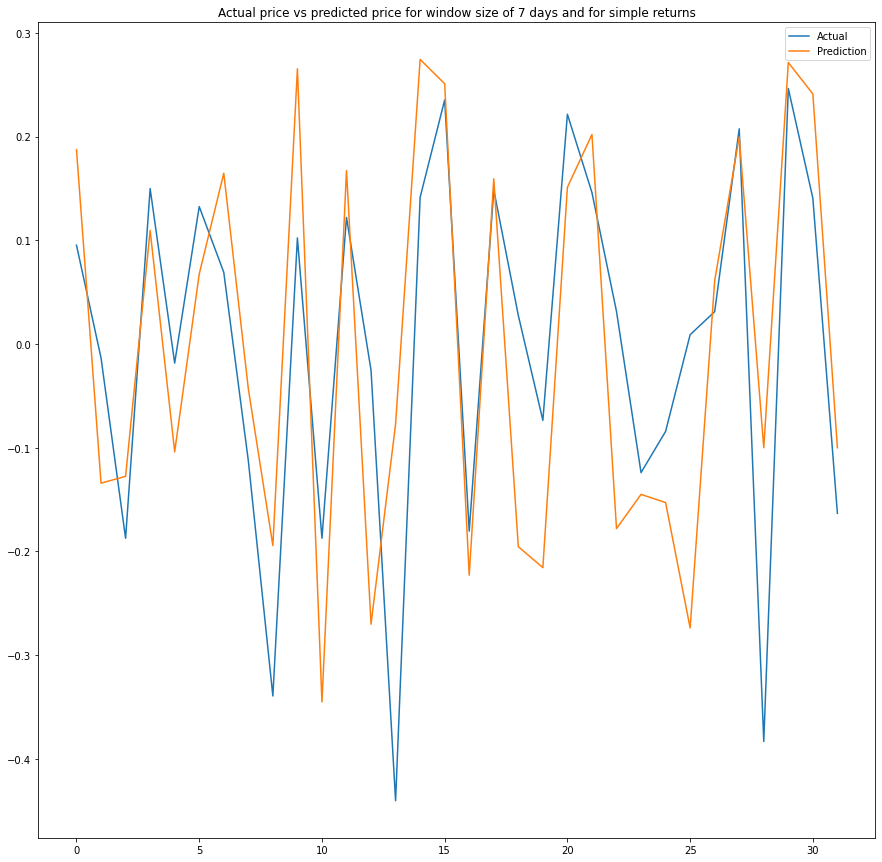

In [75]:
model_num = 2
m1 = models_final[model_num][0]
prices,dirs,w_size,y_true = models_final[model_num][3], models_final[model_num][4],models_final[model_num][5],models_final[model_num][6]
m1.reset_states()
print(prices.shape,dirs.shape)
preds = m1.predict({'left':prices,'middle':prices,'right':dirs},batch_size=16)


plt.rcParams['figure.figsize'] = [15, 15]


y_true_u = y_true
y_preds_u = preds.flatten()

price_true = recover_price(y_true_u)
price_pred = recover_price(y_preds_u)

# num_points = 512

plt.plot(y_true_u)
plt.plot(y_preds_u)
plt.legend(['Actual','Prediction'])
plt.title('Actual price vs predicted price for window size of '+str(w_size)+' days and for simple returns')

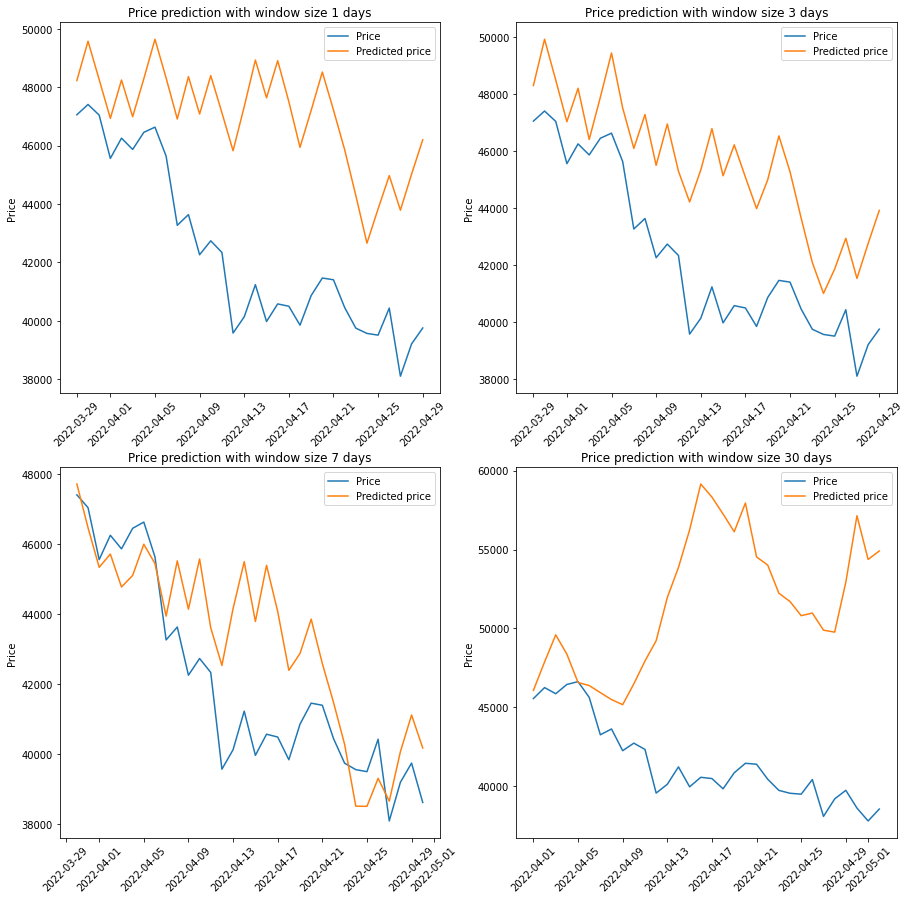

In [76]:
# AQUI PREDIC EL VALOR DE WBTC FENT SERVIR LA DIRECCIONALITAT DE BTC


fig, axs = plt.subplots(2, 2)
for ax in axs.flatten():
    plt.sca(ax)
    plt.xticks(rotation = 45)
plt.rcParams['figure.figsize'] = [15, 15]
i = 0
j = 0
for model_num in range(4):
    if model_num == 0:
      i,j=0,0
      w_size=1
      y = y1
    elif model_num == 1:
      i,j=0,1
      w_size=3
      y = y3
    elif model_num == 2:
      i,j=1,0
      w_size=7
      y = y7
    elif model_num == 3:
      i,j=1,1
      w_size=30
      y = y30
      
    model = models_final[model_num]
    m,loss,val_loss,prices,dirs,y_test = model[0],model[-2],model[-1],model[3],model[4],model[6]

    stop = -abs(len(y_test))

    preds = m.predict({'left':prices,'middle':prices,'right':dirs},batch_size=16)


    # init_value = get_init_value(y_test,df_wbtc_btc)

    price_true,price_pred,dates = ttt(y_test,unnormalize2(preds.flatten(),df_wbtc_btc),df_wbtc_btc)
    # print(dates.shape,price_true.shape,preds.shape)
    axs[i, j].plot(dates,price_true)
    axs[i, j].plot(dates,price_pred)
    axs[i,j].legend(['Price','Predicted price'])

    axs[i, j].set_ylabel('Price')
    axs[i, j].set_title(f'Price prediction with window size '+str(w_size)+' days')
    m.reset_states()

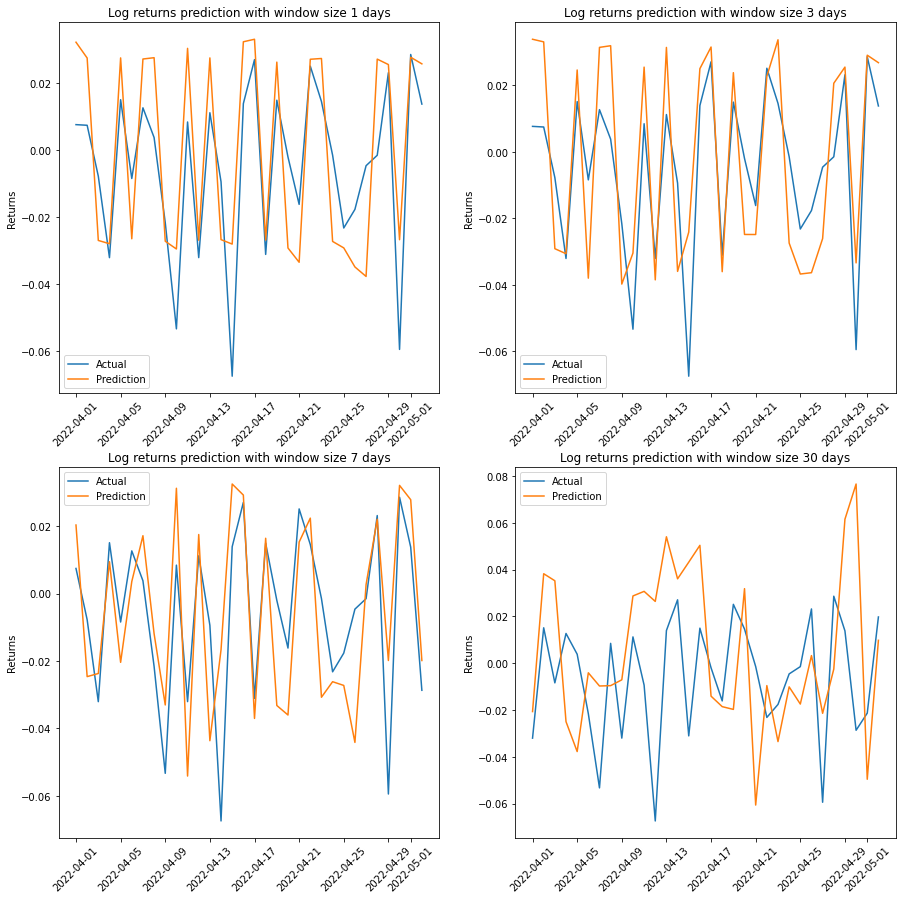

In [77]:
fig, axs = plt.subplots(2, 2)
# models_log.append((model,p_train1,dirs_train1,p_test1,dirs_test1,window_size,y_test,y_train,loss,val_loss))
# fig.suptitle('Price prediction')
plt.rcParams['figure.figsize'] = [15, 15]
for ax in axs.flatten():
    plt.sca(ax)
    plt.xticks(rotation = 45)
# name = model_names[k]
i = 0
j = 0
for model_num in range(4):
    if model_num == 0:
      i,j=0,0
      w_size=1
      y = y1
    elif model_num == 1:
      i,j=0,1
      w_size=3
      y = y3
    elif model_num == 2:
      i,j=1,0
      w_size=7
      y = y7
    elif model_num == 3:
      i,j=1,1
      w_size=30
      y = y30
    model = models_final[model_num]
    m,loss,val_loss,prices,dirs,y_test = model[0],model[-2],model[-1],model[3],model[4],model[6]
    stop = -abs(len(y_test))
    # dates = df_wbtc_btc['Date'][stop:]
    preds = m.predict({'left':prices,'middle':prices,'right':dirs},batch_size=16)

    axs[i, j].plot(dates,unnormalize2(y_test,df_wbtc_btc))
    axs[i, j].plot(dates,unnormalize2(preds.flatten(),df_wbtc_btc))
    axs[i,j].legend(['Actual','Prediction'])

    axs[i, j].set_ylabel('Returns')
    axs[i, j].set_title(f'Log returns prediction with window size '+str(w_size)+' days')
    m.reset_states()

# Predicting LTC using Davidson model for May 2021-2022

In [78]:
df_LTC2 = load_df('/content/drive/MyDrive/Colab Notebooks/datasets/ltc-investing-may.csv')

df_BTC3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/btc-investing-may.csv',index_col=False)
# df_BTC = pd.read_csv('datasets/BTC-paper1.csv',index_col=False)
df_BTC3.isna().sum()
# df_BTC[['Price','Open','High','Low']] =df_BTC[['Price','Open','High','Low']].applymap(lambda x: x.replace(".","a"))
# df_BTC[['Price','Open','High','Low']] =df_BTC[['Price','Open','High','Low']].applymap(lambda x: x.replace(",","."))
df_BTC3[['Price','Open','High','Low']] = df_BTC3[['Price','Open','High','Low']].applymap(lambda x: x.replace(",",""))
df_BTC3[['Date']] = df_BTC3[['Date']].applymap(lambda x: x.replace(",",""))
df_BTC3[['Price','Open','High','Low']] = df_BTC3[['Price','Open','High','Low']].astype('float')


price = df_BTC3['Price'].to_numpy()
open = df_BTC3['Open'].to_numpy()
dir = []
for i in range(len(price)):
    if price[i]>open[i]:
        dir.append(1)
    else:
        dir.append(-1)
df_BTC3['Direction'] = np.array(dir)

df_LTC2['directions'] = np.array(dir)

df_LTC2['log_returns'] = np.log(df_LTC2['Price']/df_LTC2['Price'].shift(1))
df_LTC2['test'] = 2*(df_LTC2['log_returns']-df_LTC2['log_returns'].min())/(df_LTC2['log_returns'].max()-df_LTC2['log_returns'].min())-1
df_LTC2 = df_LTC2.dropna()
df_LTC2 = df_LTC2.iloc[:-1]
df_LTC2['positive'] = df_defi['positive'].to_numpy()
df_LTC2['negative'] = df_defi['negative'].to_numpy()

df_LTC2

Date    Price     Open     High      Low     Vol. Change %  \
Date                                                                          
2021-05-06 2021-05-06  353.380  356.136  364.758  318.986    2.75M   -0.72%   
2021-05-07 2021-05-07  345.537  353.380  372.264  333.893  329.82M   -2.22%   
2021-05-08 2021-05-08  347.030  345.199  356.507  334.242  325.56M    0.43%   
2021-05-09 2021-05-09  386.820  347.129  388.956  334.673    2.29M   11.47%   
2021-05-10 2021-05-10  359.106  387.812  412.802  335.177  356.90M   -7.16%   
...               ...      ...      ...      ...      ...      ...      ...   
2022-04-30 2022-04-30   95.900  100.400  101.500   94.000  344.04K   -4.39%   
2022-05-01 2022-05-01   99.200   95.900  100.000   94.600  295.50K    3.44%   
2022-05-02 2022-05-02  100.700   99.200  101.700   98.300  330.39K    1.51%   
2022-05-03 2022-05-03   99.400  100.700  101.400   97.500  307.96K   -1.29%   
2022-05-04 2022-05-04  106.300   99.400  107.100   99.000  475.28K    6.94%   

            directions  log_returns      test  positive  negative  
Date                                                               
2021-05-06           1    -0.007266  0.258025         0         0  
2021-05-07          -1    -0.022444  0.215314         0         0  
2021-05-08           1     0.004312  0.290603         0         1  
2021-05-09           1     0.108548  0.583918         0         0  
2021-05-10          -1    -0.074342  0.069278         0         1  
...                ...          ...       ...       ...       ...  
2022-04-30          -1    -0.044860  0.152239         1         0  
2022-05-01          -1     0.033832  0.373672         1         0  
2022-05-02           1     0.015008  0.320702         0         3  
2022-05-03           1    -0.012994  0.241907         1         0  
2022-05-04          -1     0.067113  0.467323         1         1  

[364 rows x 12 columns]

In [79]:
X1,y1 = tfmfuncs.df_to_X_y(df_LTC2,columns=['test','directions'],window_size=1)
X3,y3 = tfmfuncs.df_to_X_y(df_LTC2,columns=['test','directions'],window_size=3)
X7,y7 = tfmfuncs.df_to_X_y(df_LTC2,columns=['test','directions'],window_size=7)
X30,y30 = tfmfuncs.df_to_X_y(df_LTC2,columns=['test','directions'],window_size=30)

In [80]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed)

In [81]:
datasets = [(X1,y1),(X3,y3),(X7,y7),(X30,y30)]
nb_epochs = 50
models_final_ltc = []
j=0
for dataset in datasets:
    print(f'Training {j}')
    X = dataset[0]
    y = dataset[1]
    X_train, X_test = split_ds2(X,pct=0.9)
    y_train, y_test = split_ds2(y,pct=0.9)

    prices_train, dirs_train = adapt_ds3(X_train)
    prices_test, dirs_test = adapt_ds3(X_test)

    # X_test,y_test = resize_ds(X_test,y_test)
    prices_train = resize_ds2(prices_train)
    dirs_train = resize_ds2(dirs_train)
    y_train = resize_ds2(y_train).flatten()

    prices_test = resize_ds2(prices_test)
    dirs_test = resize_ds2(dirs_test)
    y_test = resize_ds2(y_test).flatten()

    X_test,y_test = resize_ds(X_test,y_test)

    print(f'X_train & y_train: {X_train.shape},{y_train.shape}\nX_test & y_test: {X_test.shape},{y_test.shape}')

    model = build_model(X_train,batch_size=16)
    window_size = len(X_train[0,:])
    # p_train1, dirs_train1 = adapt_ds(X_train)
    # p_test1, dirs_test1 = adapt_ds(X_test)
    model.compile(optimizer='adam',loss='mse',metrics=['MeanSquaredError'])
    loss = []
    val_loss = []
    for i in range(nb_epochs):
        print(f'Epoch {i}')
        history = model.fit({'left':prices_train,'middle':prices_train,'right':dirs_train},{'target':y_train},validation_data=({'left':prices_test,'middle':prices_test,'right':dirs_test},{'target':y_test}),epochs=1,batch_size=16)
        loss.append(history.history['loss'][0])
        val_loss.append(history.history['val_loss'][0])
        model.reset_states()

    models_final_ltc.append((model,prices_train,dirs_train,prices_test,dirs_test,window_size,y_test,y_train,loss,val_loss))
    model.save(f'models/tfm-log-{window_size}.h5')
    tf.keras.backend.clear_session()
    j+=1
    print(f'Done training\n')

Training 0
X_train & y_train: (326, 1, 2),(320,)
X_test & y_test: (32, 1, 2),(32,)
Epoch 0
20/20 [==============================] - 4s 44ms/step - loss: 0.0467 - mean_squared_error: 0.0467 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 1
20/20 [==============================] - 0s 4ms/step - loss: 0.0294 - mean_squared_error: 0.0294 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 2
20/20 [==============================] - 0s 4ms/step - loss: 0.0290 - mean_squared_error: 0.0290 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 3
20/20 [==============================] - 0s 4ms/step - loss: 0.0288 - mean_squared_error: 0.0288 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 4
20/20 [==============================] - 0s 5ms/step - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 5
20/20 [==============================] - 0s 4ms/step - loss: 0.0284 - mean_squared_error: 0.0284 - val_loss: 0.0097 - val_m

(32, 30) (32, 30)


Text(0.5, 1.0, 'Actual price vs predicted price for window size of 30 days and for simple returns')

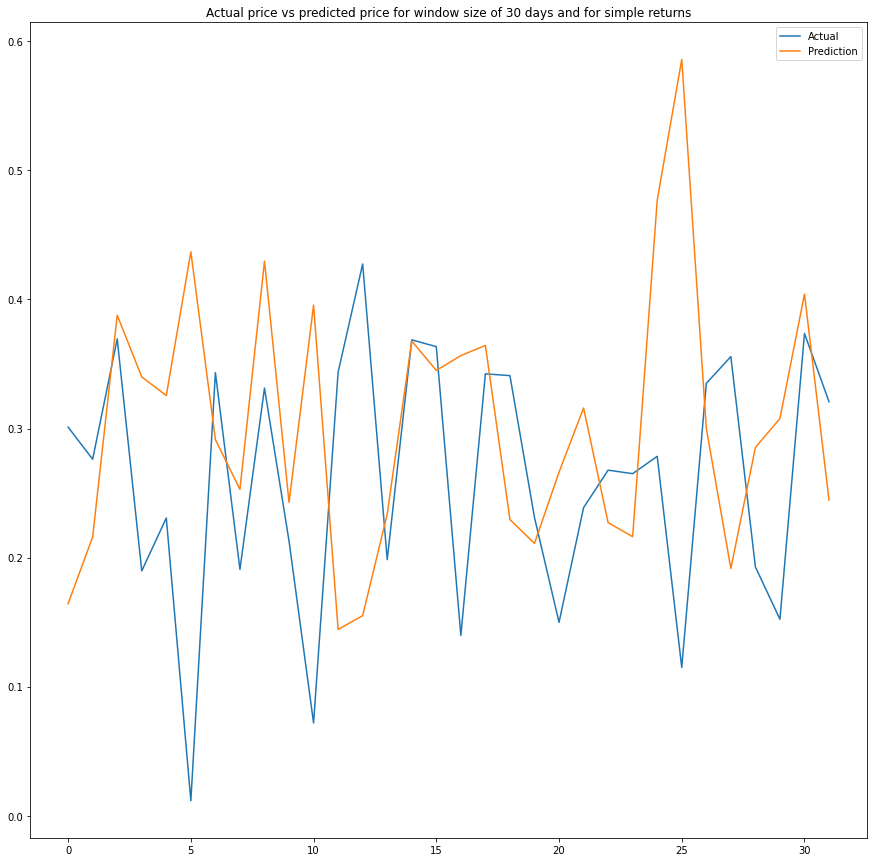

In [82]:
model_num = 3
m1 = models_final_ltc[model_num][0]
prices,dirs,w_size,y_true = models_final_ltc[model_num][3], models_final_ltc[model_num][4],models_final_ltc[model_num][5],models_final_ltc[model_num][6]
m1.reset_states()
print(prices.shape,dirs.shape)
preds = m1.predict({'left':prices,'middle':prices,'right':dirs},batch_size=16)


plt.rcParams['figure.figsize'] = [15, 15]


y_true_u = y_true
y_preds_u = preds.flatten()

price_true = recover_price(y_true_u)
price_pred = recover_price(y_preds_u)

# num_points = 512

plt.plot(y_true_u)
plt.plot(y_preds_u)
plt.legend(['Actual','Prediction'])
plt.title('Actual price vs predicted price for window size of '+str(w_size)+' days and for simple returns')

In [83]:
y1

array([ 0.21531416,  0.29060298,  0.58391801,  0.06927781,  0.41805825,
       -0.34539014,  0.41632571,  0.35453699,  0.03808519,  0.24730321,
        0.1328651 ,  0.40677108, -1.        ,  0.63006713, -0.17774454,
        0.1067753 , -0.20749382,  1.        ,  0.27229253,  0.49902274,
        0.19899554,  0.03593821,  0.05053791,  0.39646951,  0.55588947,
        0.19904469,  0.34374436,  0.36322628,  0.06114507,  0.18852263,
        0.33164438,  0.03953797,  0.25559742,  0.47675487,  0.20685762,
        0.19016478,  0.25765661,  0.4344259 ,  0.42370157,  0.20447254,
        0.13576061,  0.28619777,  0.08644916,  0.2158362 ,  0.31935773,
       -0.32897797,  0.15898449,  0.4916853 ,  0.39765956,  0.07613574,
        0.31422215,  0.40151082,  0.38451679,  0.40036042,  0.28805222,
        0.13864163,  0.27185699,  0.34287373,  0.37513259,  0.13593422,
        0.3022511 ,  0.24744925,  0.1343397 ,  0.36351138,  0.26688033,
        0.28220664,  0.26299102,  0.23567131,  0.27088014,  0.15

In [84]:
df_LTC2.iloc[-50:]

Date  Price   Open   High    Low     Vol. Change %  \
Date                                                                  
2022-03-16 2022-03-16  111.4  106.8  111.9  105.7   68.13M    4.31%   
2022-03-17 2022-03-17  110.2  111.2  111.6  108.5   34.76M   -1.08%   
2022-03-18 2022-03-18  111.9  110.2  112.9  107.9   39.95M    1.54%   
2022-03-19 2022-03-19  116.9  111.9  117.1  111.5  454.74K    4.47%   
2022-03-20 2022-03-20  114.9  116.9  118.2  111.5  457.04K   -1.71%   
2022-03-21 2022-03-21  116.1  114.9  116.8  113.2  415.46K    1.04%   
2022-03-22 2022-03-22  122.7  116.1  123.7  115.6  613.16K    5.68%   
2022-03-23 2022-03-23  122.4  122.7  124.4  118.6  404.12K   -0.24%   
2022-03-24 2022-03-24  126.5  122.4  127.7  120.4  494.29K    3.35%   
2022-03-25 2022-03-25  123.9  126.5  127.3  121.8  389.34K   -2.06%   
2022-03-26 2022-03-26  124.9  123.9  125.5  122.0  222.33K    0.81%   
2022-03-27 2022-03-27  129.7  124.9  129.7  123.3  360.94K    3.84%   
2022-03-28 2022-03-28  127.3  129.7  132.6  127.3  485.44K   -1.85%   
2022-03-29 2022-03-29  130.0  127.3  132.0  127.2  402.31K    2.12%   
2022-03-30 2022-03-30  131.0  130.0  134.0  126.0  469.46K    0.77%   
2022-03-31 2022-03-31  123.8  131.0  132.9  121.5  925.29K   -5.50%   
2022-04-01 2022-04-01  124.8  123.8  126.3  119.2  459.33K    0.81%   
2022-04-02 2022-04-02  124.7  124.8  128.3  124.0  446.33K   -0.08%   
2022-04-03 2022-04-03  128.8  124.7  129.5  123.9  303.76K    3.29%   
2022-04-04 2022-04-04  124.8  128.8  128.9  121.2  461.77K   -3.11%   
2022-04-05 2022-04-05  122.7  124.8  127.2  122.7  266.70K   -1.68%   
2022-04-06 2022-04-06  111.6  122.7  123.0  111.6  609.82K   -9.05%   
2022-04-07 2022-04-07  114.2  111.6  115.0  110.3  302.84K    2.33%   
2022-04-08 2022-04-08  110.7  114.2  115.2  109.9  361.96K   -3.06%   
2022-04-09 2022-04-09  112.8  110.7  112.9  110.0  192.68K    1.90%   
2022-04-10 2022-04-10  110.2  112.8  114.5  110.2  200.78K   -2.30%   
2022-04-11 2022-04-11  102.4  110.2  110.7  102.1  439.86K   -7.08%   
2022-04-12 2022-04-12  104.8  102.4  105.8  101.9  298.69K    2.34%   
2022-04-13 2022-04-13  110.5  104.8  110.8  104.0  389.93K    5.44%   
2022-04-14 2022-04-14  107.4  110.5  112.3  106.1  323.66K   -2.81%   
2022-04-15 2022-04-15  110.9  107.4  112.8  107.1  303.13K    3.26%   
2022-04-16 2022-04-16  114.3  110.9  114.7  110.2  256.34K    3.07%   
2022-04-17 2022-04-17  108.8  114.3  115.1  108.3  275.69K   -4.81%   
2022-04-18 2022-04-18  111.3  108.8  111.5  105.5  435.19K    2.30%   
2022-04-19 2022-04-19  113.8  111.3  114.2  110.6  267.78K    2.25%   
2022-04-20 2022-04-20  111.9  113.8  114.1  110.7  317.78K   -1.67%   
2022-04-21 2022-04-21  106.9  111.8  114.4  105.6  374.01K   -4.47%   
2022-04-22 2022-04-22  105.4  106.7  108.6  105.1  307.21K   -1.40%   
2022-04-23 2022-04-23  105.0  105.4  107.2  104.9  151.70K   -0.38%   
2022-04-24 2022-04-24  104.5  105.0  105.9  103.7  188.78K   -0.48%   
2022-04-25 2022-04-25  104.5  104.5  104.9   98.8  464.51K    0.00%   
2022-04-26 2022-04-26   98.6  104.5  105.4   96.4  369.94K   -5.65%   
2022-04-27 2022-04-27  100.6   98.6  101.9   97.8  296.02K    2.03%   
2022-04-28 2022-04-28  103.4  100.6  104.4   99.8  543.89K    2.78%   
2022-04-29 2022-04-29  100.3  103.4  104.3   98.4  394.10K   -3.00%   
2022-04-30 2022-04-30   95.9  100.4  101.5   94.0  344.04K   -4.39%   
2022-05-01 2022-05-01   99.2   95.9  100.0   94.6  295.50K    3.44%   
2022-05-02 2022-05-02  100.7   99.2  101.7   98.3  330.39K    1.51%   
2022-05-03 2022-05-03   99.4  100.7  101.4   97.5  307.96K   -1.29%   
2022-05-04 2022-05-04  106.3   99.4  107.1   99.0  475.28K    6.94%   

            directions  log_returns      test  positive  negative  
Date                                                               
2022-03-16           1     0.042169  0.397133         4         5  
2022-03-17           1    -0.010830  0.247995         0         1  
2022-03-18           1     0.015309  0.321548       

In [85]:
def get_init_value(log_returns,df):
    init_record = df[df['test'] == log_returns[0]]
    init_value = init_record['log_returns'].to_numpy()[0]

    return init_value

def get_price_from_log_returns2(log_returns,df,init_value):
    normal = unnormalize2(log_returns,df)
    t = np.arange(len(normal))
    means = np.cumsum(normal)/(np.arange(len(normal))+1)

    # init_value = df['Price'][stop]
    # print(init_value)
    return init_value*np.exp(means*t)

def unnormalize2(x,df):
    xmin = df['log_returns'].min()
    xmax = df['log_returns'].max()
    x_new = xmin+(xmax-xmin)*(x+1)/2
    # print(x_new.shape,x.shape)
    return x_new

def ttt(log_returns,preds,df):

  def get_price_from_preds(preds,prev_p):
    pred_prices = []
    for i in range(len(preds)):
      # print(preds[i],prev_p)
      p = prev_p*np.exp(preds[i])
      pred_prices.append(p)
      prev_p = p

    return np.array(pred_prices)
  indxs = np.arange(len(df))
  df_t = df 
  df_t.index= np.arange(len(df))
  first_log = log_returns[0]



  ind = df_t[df_t['test'] == first_log].index
  prices = df_t.iloc[ind[0]:]['Price'].to_numpy()
  dates = df_t.iloc[ind[0]:]['Date'].to_numpy()
  prev_p = df_t.iloc[ind[0]-1]['Price']

  pred_prices = get_price_from_preds(preds,prev_p)
  dates = dates[:len(pred_prices)]
  prices = prices[:len(pred_prices)]
  
  
  return prices,pred_prices,dates


# ttt(models_final_ltc[0][6],df_LTC2)
# 0.3010908574383817

In [86]:
models_final_ltc[0][6]

array([0.33752935, 0.30003351, 0.11939927, 0.30110906, 0.27621505,
       0.36950128, 0.18969579, 0.230718  , 0.01165006, 0.34327625,
       0.19088018, 0.33135151, 0.2128514 , 0.07189948, 0.34366122,
       0.42750144, 0.19839933, 0.36870987, 0.3634449 , 0.13970101,
       0.34239739, 0.34097731, 0.23109281, 0.14984084, 0.23870653,
       0.26777134, 0.26503903, 0.27847071, 0.1149368 , 0.33497725,
       0.35572074, 0.1928167 ])

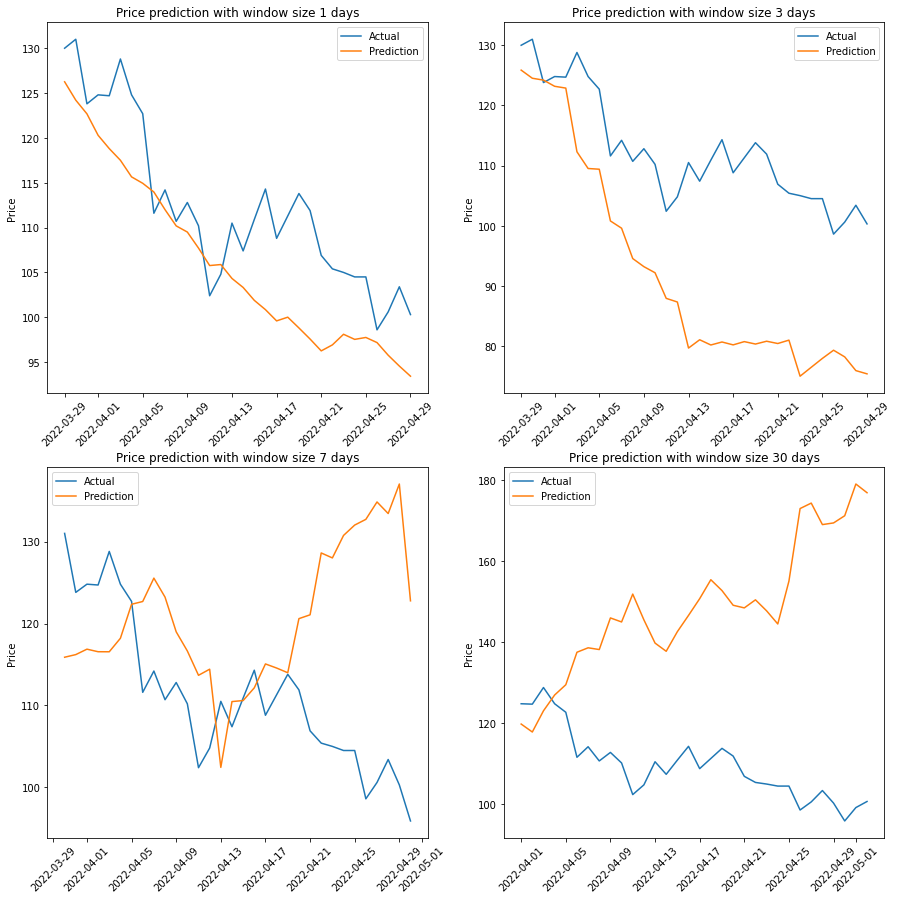

In [87]:
fig, axs = plt.subplots(2, 2)
# models_log.append((model,p_train1,dirs_train1,p_test1,dirs_test1,window_size,y_test,y_train,loss,val_loss))
# fig.suptitle('Price prediction')
for ax in axs.flatten():
    plt.sca(ax)
    plt.xticks(rotation = 45)
plt.rcParams['figure.figsize'] = [15, 15]
# name = model_names[k]
i = 0
j = 0
for model_num in range(4):
    if model_num == 0:
      i,j=0,0
      w_size=1
      y = y1
    elif model_num == 1:
      i,j=0,1
      w_size=3
      y = y3
    elif model_num == 2:
      i,j=1,0
      w_size=7
      y = y7
    elif model_num == 3:
      i,j=1,1
      w_size=30
      y = y30
      
    model = models_final_ltc[model_num]
    m,loss, val_loss,y_test,prices,dirs = model[0],model[-2],model[-1],model[6],model[3],model[4]
    # print(len(y_test))
    stop = -abs(len(y_test))
    # dates = df_LTC2['Date'][stop:]
    preds = m.predict({'left':prices,'middle':prices,'right':dirs},batch_size=16)

    # y_true_u = unnormalize(y_test)
    # y_preds_u = unnormalize(preds.flatten())
    # print(y_test.shape,preds.flatten().shape)
    init_value = get_init_value(y_test,df_LTC2)
    # price_true = get_price_from_log_returns2(y_test,df=df_LTC2,init_value=init_value)
    # price_pred = get_price_from_log_returns2(preds.flatten(),df=df_LTC2,init_value=init_value)
    price_true,price_pred,dates = ttt(y_test,unnormalize2(preds.flatten(),df_LTC2),df_LTC2)
    # print(unnormalize2(preds.flatten(),df_LTC2))
    # w_size = model[-3]
    axs[i, j].plot(dates,price_true)
    axs[i, j].plot(dates,price_pred)
    axs[i,j].legend(['Actual','Prediction'])
    # axs[i, j].set_xlabel('Date')
    axs[i, j].set_ylabel('Price')
    axs[i, j].set_title(f'Price prediction with window size '+str(w_size)+' days')
    m.reset_states()

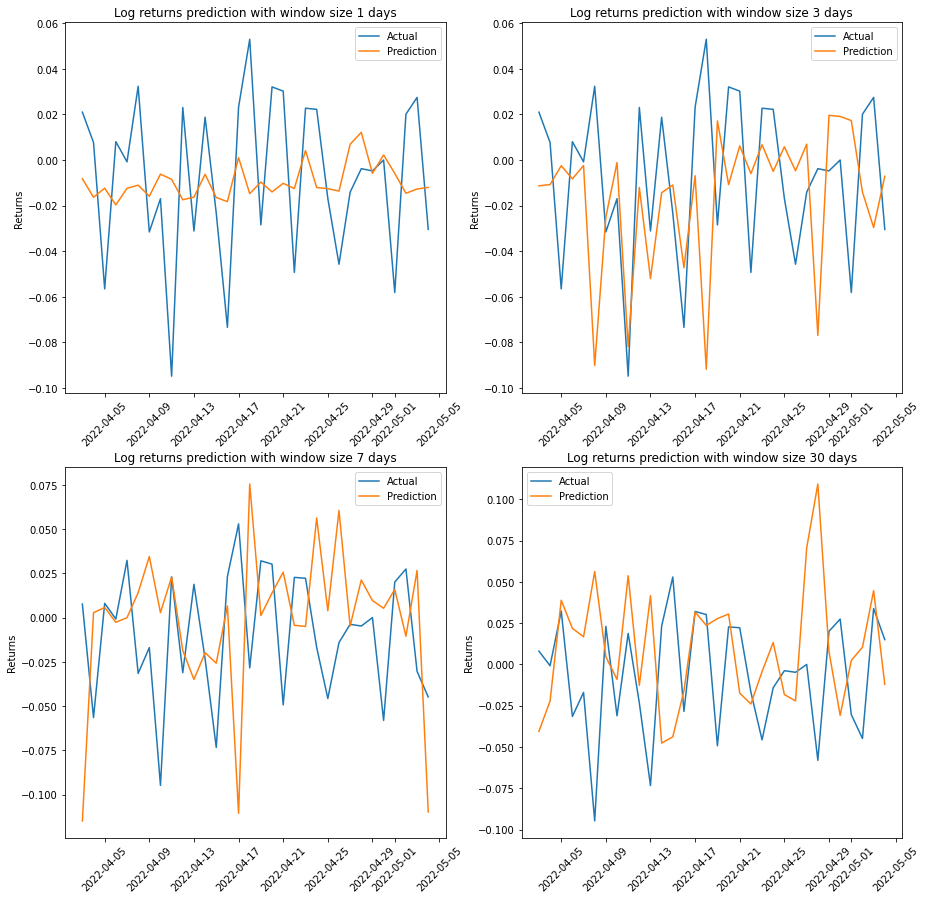

In [88]:
fig, axs = plt.subplots(2, 2)
# models_log.append((model,p_train1,dirs_train1,p_test1,dirs_test1,window_size,y_test,y_train,loss,val_loss))
# fig.suptitle('Price prediction')
plt.rcParams['figure.figsize'] = [15, 15]
for ax in axs.flatten():
    plt.sca(ax)
    plt.xticks(rotation = 45)
# name = model_names[k]
i = 0
j = 0
for model_num in range(4):
    if model_num == 0:
      i,j=0,0
      w_size=1
      y = y1
    elif model_num == 1:
      i,j=0,1
      w_size=3
      y = y3
    elif model_num == 2:
      i,j=1,0
      w_size=7
      y = y7
    elif model_num == 3:
      i,j=1,1
      w_size=30
      y = y30
    model = models_final_ltc[model_num]
    m,loss, val_loss,y_test,prices,dirs = model[0],model[-2],model[-1],model[6],model[3],model[4]
    stop = -abs(len(y_test))
    dates = df_LTC2['Date'][stop:]
    preds = m.predict({'left':prices,'middle':prices,'right':dirs},batch_size=16)

    # y_true_u = unnormalize(y_test)
    # y_preds_u = unnormalize(preds.flatten())

    # w_size = model[-3]
    axs[i, j].plot(dates,unnormalize2(y_test,df_LTC2))
    axs[i, j].plot(dates,unnormalize2(preds.flatten(),df_LTC2))
    axs[i,j].legend(['Actual','Prediction'])
    # props = {"rotation" : 30}
    # plt.xticks(rotation = 45)
    # axs[i, j].set_xlabel('Date')
    axs[i, j].set_ylabel('Returns')
    axs[i, j].set_title(f'Log returns prediction with window size '+str(w_size)+' days')
    m.reset_states()

In [89]:
# len(y_test)
# df_LTC2['Date'][:-32]

stop

-32

# Predicting LTC with DeFI (BTCs market activity)

In [90]:
X1,y1 = tfmfuncs.df_to_X_y(df_LTC2,columns=['test','positive','negative'],window_size=1)
X3,y3 = tfmfuncs.df_to_X_y(df_LTC2,columns=['test','positive','negative'],window_size=3)
X7,y7 = tfmfuncs.df_to_X_y(df_LTC2,columns=['test','positive','negative'],window_size=7)
X30,y30 = tfmfuncs.df_to_X_y(df_LTC2,columns=['test','positive','negative'],window_size=30)

In [91]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed)

In [92]:
datasets = [(X1,y1),(X3,y3),(X7,y7),(X30,y30)]
nb_epochs = 25
models_defi_final = []
j=0
for dataset in datasets:
    print(f'Training {j}')
    X = dataset[0]
    y = dataset[1]
    X_train, X_test = split_ds2(X,pct=0.9)
    y_train, y_test = split_ds2(y,pct=0.9)

    prices_train, poss_train, negs_train = adapt_ds2(X_train)
    prices_test, poss_test, negs_test = adapt_ds2(X_test)

    # X_test,y_test = resize_ds(X_test,y_test)
    prices_train = resize_ds2(prices_train)
    poss_train = resize_ds2(poss_train)
    negs_train = resize_ds2(negs_train)
    y_train = resize_ds2(y_train).flatten()

    prices_test = resize_ds2(prices_test)
    poss_test = resize_ds2(poss_test)
    negs_test = resize_ds2(negs_test)
    y_test = resize_ds2(y_test).flatten()

    print(f'X_train & y_train: {X_train.shape},{y_train.shape}\nX_test & y_test: {X_test.shape},{y_test.shape}')
    print(f'prices_train, poss_train & negs_train: {prices_train.shape},{poss_train.shape},{poss_train.shape}\n')

    model = build_TFM_model(X_train,batch_size=16)
    window_size = len(X_train[0,:])
    # p_train1, dirs_train1 = adapt_ds(X_train)
    # p_test1, dirs_test1 = adapt_ds(X_test)
    model.compile(optimizer='adam',loss='mse',metrics=['MeanSquaredError'])
    loss = []
    val_loss = []
    # model.summary()
    for i in range(nb_epochs):
        print(f'Epoch {i}')
        history = model.fit({'prices':prices_train,'positives':poss_train,'negatives':negs_train},{'target':y_train},validation_data=({'prices':prices_test,'positives':poss_test,'negatives':negs_test},{'target':y_test}),epochs=1,batch_size=16)
        loss.append(history.history['loss'][0])
        val_loss.append(history.history['val_loss'][0])
        model.reset_states()

    models_defi_final.append((model,prices_test,poss_test,negs_test,y_test,window_size,loss,val_loss))
    model.save(f'models/tfm-defi-{window_size}.h5')
    tf.keras.backend.clear_session()
    j+=1
    print(f'Done training\n')
    # - loss: 0.0255 - mean_squared_error: 0.0255 - val_loss: 0.0157 - val_mean_squared_error: 0.0157
    # Epoch 4 - loss: 0.0284 - mean_squared_error: 0.0284 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
    #- loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0170 - val_mean_squared_error: 0.0170
    # Epoch 4 - 0s 8ms/step - loss: 0.0281 - mean_squared_error: 0.0281 - val_loss: 0.0143 - val_mean_squared_error: 0.0143
    # - loss: 0.0177 - mean_squared_error: 0.0177 - val_loss: 0.0233 - val_mean_squared_error: 0.0233
    # Epoch 18 - 0s 10ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - val_loss: 0.0225 - val_mean_squared_error: 0.0225

Training 0
X_train & y_train: (326, 1, 3),(320,)
X_test & y_test: (37, 1, 3),(32,)
prices_train, poss_train & negs_train: (320, 1),(320, 1),(320, 1)

Epoch 0
20/20 [==============================] - 3s 32ms/step - loss: 0.0607 - mean_squared_error: 0.0607 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 1
20/20 [==============================] - 0s 4ms/step - loss: 0.0355 - mean_squared_error: 0.0355 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 2
20/20 [==============================] - 0s 4ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 3
20/20 [==============================] - 0s 4ms/step - loss: 0.0292 - mean_squared_error: 0.0292 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 4
20/20 [==============================] - 0s 4ms/step - loss: 0.0276 - mean_squared_error: 0.0276 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 5
20/20 [==============================] - 0s 4ms/step - l

(32, 30) (32, 30) (32, 30)


Text(0.5, 1.0, 'Actual price vs predicted price for window size of 30 days and for simple returns')

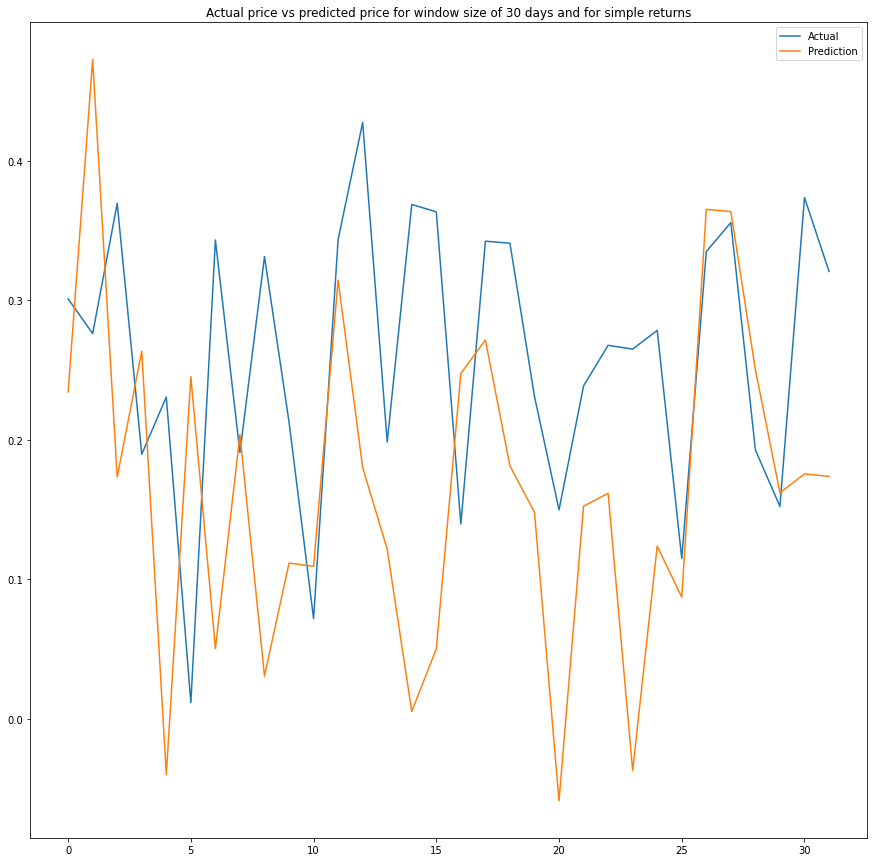

In [93]:
model_num = 3
m1 = models_defi_final[model_num][0]
prices,poss,negs,y_test,w_size = models_defi_final[model_num][1], models_defi_final[model_num][2],models_defi_final[model_num][3],models_defi_final[model_num][4],models_defi_final[model_num][5]
m1.reset_states()
print(prices.shape,poss.shape,negs.shape)
preds = m1.predict({'prices':prices,'positives':poss,'negatives':negs},batch_size=16)
stop = -abs(len(df_LTC['Date'][1200:])-len(y_true))
# dates = df_LTC['Date'][1200:stop]
plt.rcParams['figure.figsize'] = [15, 15]
# plt.plot(dates,y_true)
# plt.plot(dates,preds.flatten())
# plt.legend(['Actual','Prediction'])
# plt.title('Log returns vs predicted returns for window size of '+str(w_size)+' days')

# y_true_u = unnormalize(y_true)
# y_preds_u = unnormalize(preds.flatten())

y_true_u = y_test
y_preds_u = preds.flatten()

# price_true = get_price_from_log_returns(y_true_u)
# price_pred = get_price_from_log_returns(y_preds_u)

# price_true = recover_price(y_true_u)
# price_pred = recover_price(y_preds_u)

# num_points = 512

# plt.plot(dates[:num_points],price_true[:num_points])
# plt.plot(dates[:num_points],price_pred[:num_points])
plt.plot(y_true_u)
plt.plot(y_preds_u)
plt.legend(['Actual','Prediction'])
plt.title('Actual price vs predicted price for window size of '+str(w_size)+' days and for simple returns')

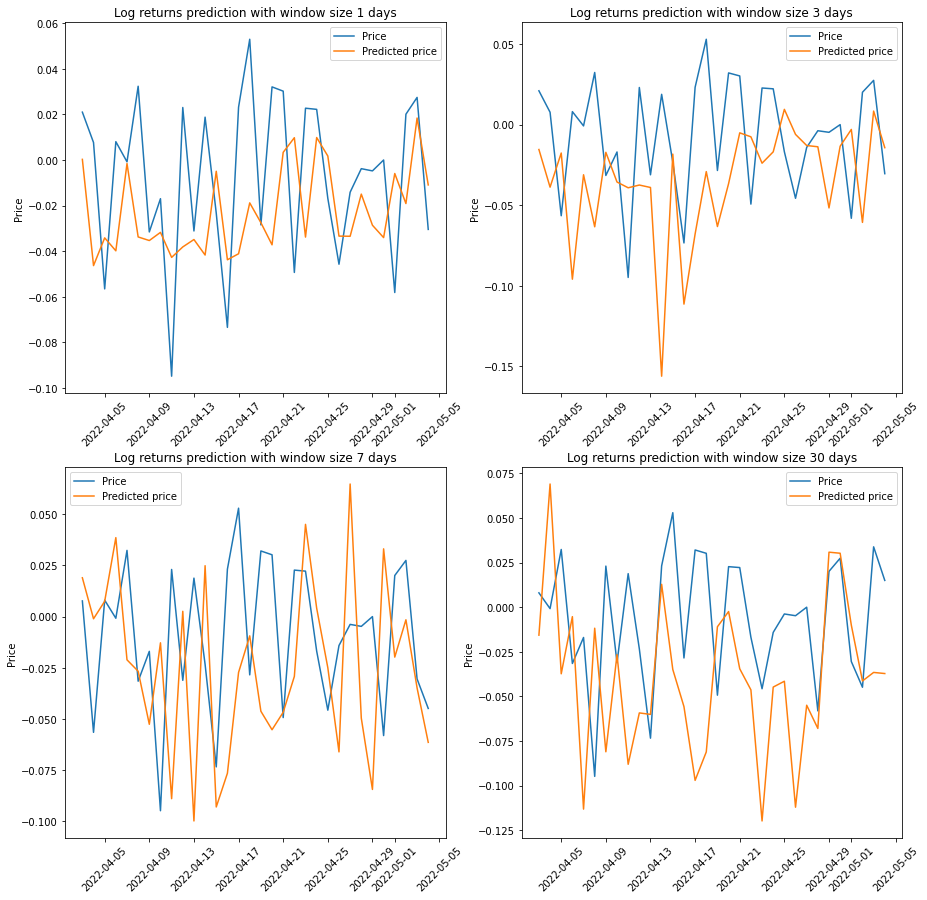

In [94]:
fig, axs = plt.subplots(2, 2)
# models_log.append((model,p_train1,dirs_train1,p_test1,dirs_test1,window_size,y_test,y_train,loss,val_loss))
# fig.suptitle('Price prediction')
plt.rcParams['figure.figsize'] = [15, 15]
for ax in axs.flatten():
    plt.sca(ax)
    plt.xticks(rotation = 45)
# name = model_names[k]
i = 0
j = 0
for model_num in range(4):
    if model_num == 0:
      i,j=0,0
      w_size=1
      y = y1
    elif model_num == 1:
      i,j=0,1
      w_size=3
      y = y3
    elif model_num == 2:
      i,j=1,0
      w_size=7
      y = y7
    elif model_num == 3:
      i,j=1,1
      w_size=30
      y = y30
    model = models_defi_final[model_num]
    m,loss, val_loss,prices,poss,negs,y_test = model[0],model[-2],model[-1],model[1],model[2],model[3],model[4]
    stop = -abs(len(y_test))
    dates = df_LTC2['Date'][stop:]
    preds = m.predict({'prices':prices,'positives':poss,'negatives':negs},batch_size=16)

    # y_true_u = unnormalize(y_test)
    # y_preds_u = unnormalize(preds.flatten())

    # w_size = model[-3]
    axs[i, j].plot(dates,unnormalize2(y_test,df_LTC2))
    axs[i, j].plot(dates,unnormalize2(preds.flatten(),df_LTC2))
    axs[i,j].legend(['Price','Predicted price'])
    # props = {"rotation" : 30}
    # plt.xticks(rotation = 45)
    # axs[i, j].set_xlabel('Date')
    axs[i, j].set_ylabel('Price')
    axs[i, j].set_title(f'Log returns prediction with window size '+str(w_size)+' days')
    m.reset_states()

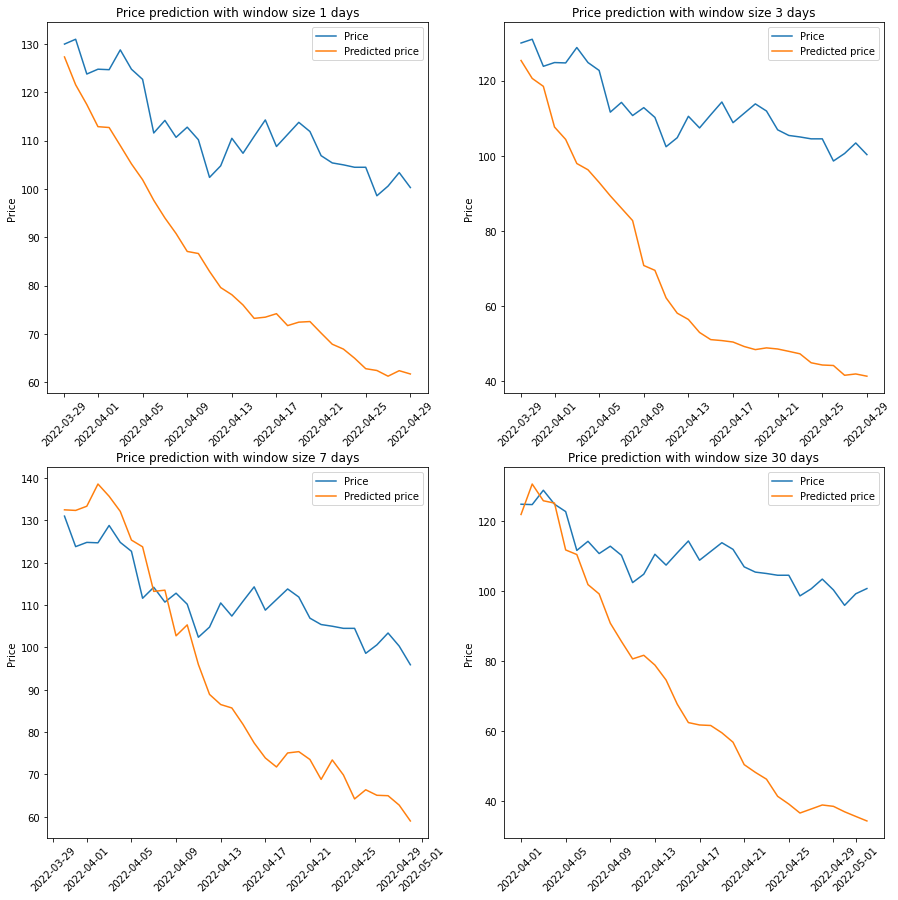

In [95]:
fig, axs = plt.subplots(2, 2)
# models_log.append((model,p_train1,dirs_train1,p_test1,dirs_test1,window_size,y_test,y_train,loss,val_loss))
# fig.suptitle('Price prediction')
for ax in axs.flatten():
    plt.sca(ax)
    plt.xticks(rotation = 45)
plt.rcParams['figure.figsize'] = [15, 15]
# name = model_names[k]
i = 0
j = 0
for model_num in range(4):
    if model_num == 0:
      i,j=0,0
      w_size=1
      y = y1
    elif model_num == 1:
      i,j=0,1
      w_size=3
      y = y3
    elif model_num == 2:
      i,j=1,0
      w_size=7
      y = y7
    elif model_num == 3:
      i,j=1,1
      w_size=30
      y = y30
      
    model = models_defi_final[model_num]
    m,loss, val_loss,prices,poss,negs,y_test = model[0],model[-2],model[-1],model[1],model[2],model[3],model[4]
    # print(len(y_test))
    stop = -abs(len(y_test))
    # dates = df_LTC2['Date'][stop:]
    preds = m.predict({'prices':prices,'positives':poss,'negatives':negs},batch_size=16)

    # y_true_u = unnormalize(y_test)
    # y_preds_u = unnormalize(preds.flatten())
    # print(y_test.shape,preds.flatten().shape)
    init_value = get_init_value(y_test,df_LTC2)
    # price_true = get_price_from_log_returns2(y_test,df=df_LTC2,init_value=init_value)
    # price_pred = get_price_from_log_returns2(preds.flatten(),df=df_LTC2,init_value=init_value)
    price_true,price_pred,dates = ttt(y_test,unnormalize2(preds.flatten(),df_LTC2),df_LTC2)
    # print(unnormalize2(preds.flatten(),df_LTC2))
    # w_size = model[-3]
    axs[i, j].plot(dates,price_true)
    axs[i, j].plot(dates,price_pred)
    axs[i,j].legend(['Price','Predicted price'])
    # axs[i, j].set_xlabel('Date')
    axs[i, j].set_ylabel('Price')
    axs[i, j].set_title(f'Price prediction with window size '+str(w_size)+' days')
    m.reset_states()

# Subst btc direction per defi data

In [96]:
X1,y1 = tfmfuncs.df_to_X_y(df_LTC2,columns=['test','positive','negative'],window_size=1)
X3,y3 = tfmfuncs.df_to_X_y(df_LTC2,columns=['test','positive','negative'],window_size=3)
X7,y7 = tfmfuncs.df_to_X_y(df_LTC2,columns=['test','positive','negative'],window_size=7)
X30,y30 = tfmfuncs.df_to_X_y(df_LTC2,columns=['test','positive','negative'],window_size=30)

In [97]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed)

In [98]:
def build_model_prefinal(X,batch_size):
    window_size = len(X[0,:])

    prices_input = Input(shape=(window_size,1), name="prices",batch_size=batch_size)
    positives_input = Input(shape=(window_size,1), name="positives",batch_size=batch_size)
    negatives_input = Input(shape=(window_size,1), name="negatives",batch_size=batch_size)


    prices = LSTM(25,return_sequences=True,stateful=True)(prices_input)
    prices = Dropout(0.25)(prices)
    prices = GRU(40,stateful=True)(prices)
    prices = Flatten()(prices)
    prices = Dense(5,activation='relu')(prices)

    prices2 = LSTM(50,return_sequences=True,stateful=True)(prices_input)
    # middle_leg = LSTM(50,return_sequences=True)(middle_leg_input)
    prices2 = Dropout(0.25)(prices2)
    prices2 = Flatten()(prices2)
    prices2 = Dense(5,activation='relu')(prices2)

    positives = Dense(16,activation='relu',name="positives-Dense")(positives_input)
    positives = Flatten(name="positives-Flatten")(positives)
    
    negatives = Dense(16,activation='relu',name="negatives-Dense")(negatives_input)
    negatives = Flatten(name="negativess-Flatten")(negatives)


    x = concatenate([prices,prices2,positives,negatives])
    x = Dense(20,activation='relu')(x)
    x = Dense(1,activation='linear',name='target')(x)

    inputs = [prices_input,positives_input,negatives_input]
    output = x

    model = Model(inputs=inputs,outputs=output)

    return model

In [99]:
datasets = [(X1,y1),(X3,y3),(X7,y7),(X30,y30)]
nb_epochs = 25
models_defi_prefinal = []
j=0
for dataset in datasets:
    print(f'Training {j}')
    X = dataset[0]
    y = dataset[1]
    X_train, X_test = split_ds2(X,pct=0.9)
    y_train, y_test = split_ds2(y,pct=0.9)

    prices_train, poss_train, negs_train = adapt_ds2(X_train)
    prices_test, poss_test, negs_test = adapt_ds2(X_test)

    # X_test,y_test = resize_ds(X_test,y_test)
    prices_train = resize_ds2(prices_train)
    poss_train = resize_ds2(poss_train)
    negs_train = resize_ds2(negs_train)
    y_train = resize_ds2(y_train).flatten()

    prices_test = resize_ds2(prices_test)
    poss_test = resize_ds2(poss_test)
    negs_test = resize_ds2(negs_test)
    y_test = resize_ds2(y_test).flatten()

    print(f'X_train & y_train: {X_train.shape},{y_train.shape}\nX_test & y_test: {X_test.shape},{y_test.shape}')
    print(f'prices_train, poss_train & negs_train: {prices_train.shape},{poss_train.shape},{poss_train.shape}\n')

    model = build_model_prefinal(X_train,batch_size=16)
    window_size = len(X_train[0,:])
    # p_train1, dirs_train1 = adapt_ds(X_train)
    # p_test1, dirs_test1 = adapt_ds(X_test)
    model.compile(optimizer='adam',loss='mse',metrics=['MeanSquaredError'])
    loss = []
    val_loss = []
    # model.summary()
    for i in range(nb_epochs):
        print(f'Epoch {i}')
        history = model.fit({'prices':prices_train,'positives':poss_train,'negatives':negs_train},{'target':y_train},validation_data=({'prices':prices_test,'positives':poss_test,'negatives':negs_test},{'target':y_test}),epochs=1,batch_size=16)
        loss.append(history.history['loss'][0])
        val_loss.append(history.history['val_loss'][0])
        model.reset_states()

    models_defi_prefinal.append((model,prices_test,poss_test,negs_test,y_test,window_size,loss,val_loss))
    model.save(f'models/tfm-predefi-{window_size}.h5')
    tf.keras.backend.clear_session()
    j+=1
    print(f'Done training\n')

Training 0
X_train & y_train: (326, 1, 3),(320,)
X_test & y_test: (37, 1, 3),(32,)
prices_train, poss_train & negs_train: (320, 1),(320, 1),(320, 1)

Epoch 0
20/20 [==============================] - 4s 46ms/step - loss: 0.0501 - mean_squared_error: 0.0501 - val_loss: 0.0161 - val_mean_squared_error: 0.0161
Epoch 1
20/20 [==============================] - 0s 4ms/step - loss: 0.0358 - mean_squared_error: 0.0358 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 2
20/20 [==============================] - 0s 5ms/step - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 3
20/20 [==============================] - 0s 5ms/step - loss: 0.0296 - mean_squared_error: 0.0296 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 4
20/20 [==============================] - 0s 4ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 5
20/20 [==============================] - 0s 5ms/step - l

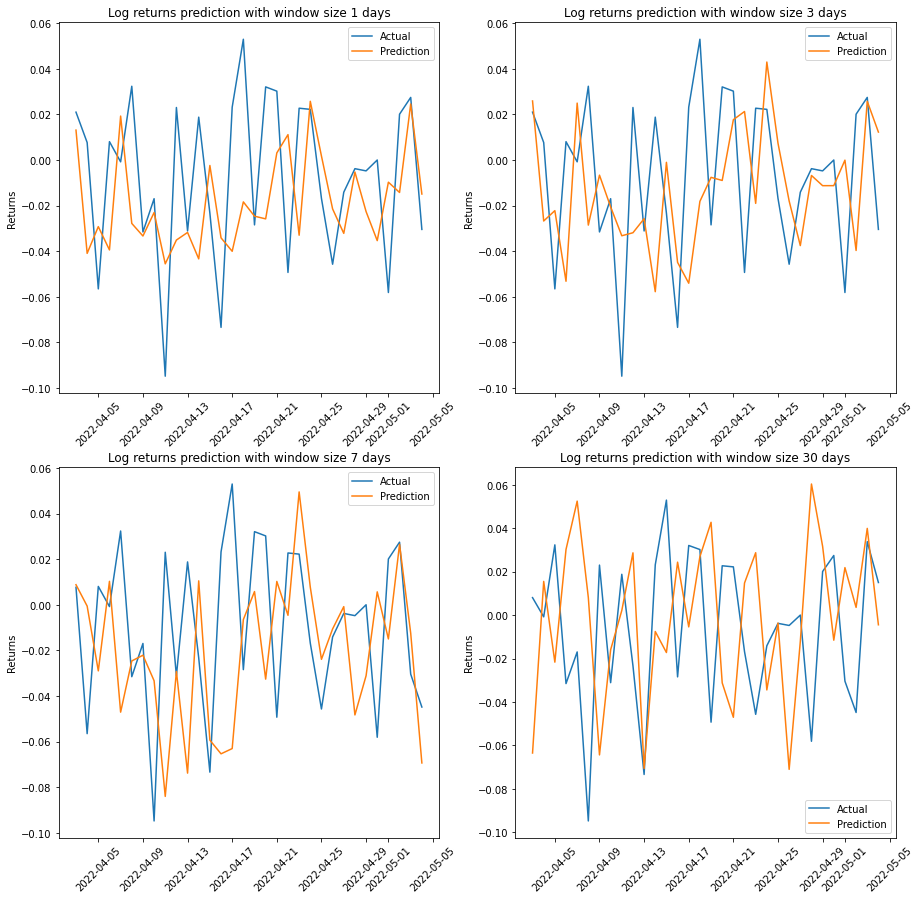

In [100]:
fig, axs = plt.subplots(2, 2)
# models_log.append((model,p_train1,dirs_train1,p_test1,dirs_test1,window_size,y_test,y_train,loss,val_loss))
# fig.suptitle('Price prediction')
plt.rcParams['figure.figsize'] = [15, 15]
for ax in axs.flatten():
    plt.sca(ax)
    plt.xticks(rotation = 45)
# name = model_names[k]
i = 0
j = 0
for model_num in range(4):
    if model_num == 0:
      i,j=0,0
      w_size=1
      y = y1
    elif model_num == 1:
      i,j=0,1
      w_size=3
      y = y3
    elif model_num == 2:
      i,j=1,0
      w_size=7
      y = y7
    elif model_num == 3:
      i,j=1,1
      w_size=30
      y = y30
    model = models_defi_prefinal[model_num]
    m,loss, val_loss,prices,poss,negs,y_test = model[0],model[-2],model[-1],model[1],model[2],model[3],model[4]
    stop = -abs(len(y_test))
    dates = df_LTC2['Date'][stop:]
    preds = m.predict({'prices':prices,'positives':poss,'negatives':negs},batch_size=16)

    axs[i, j].plot(dates,unnormalize2(y_test,df_LTC2))
    axs[i, j].plot(dates,unnormalize2(preds.flatten(),df_LTC2))
    axs[i,j].legend(['Actual','Prediction'])
    axs[i, j].set_ylabel('Returns')
    axs[i, j].set_title(f'Log returns prediction with window size '+str(w_size)+' days')
    m.reset_states()

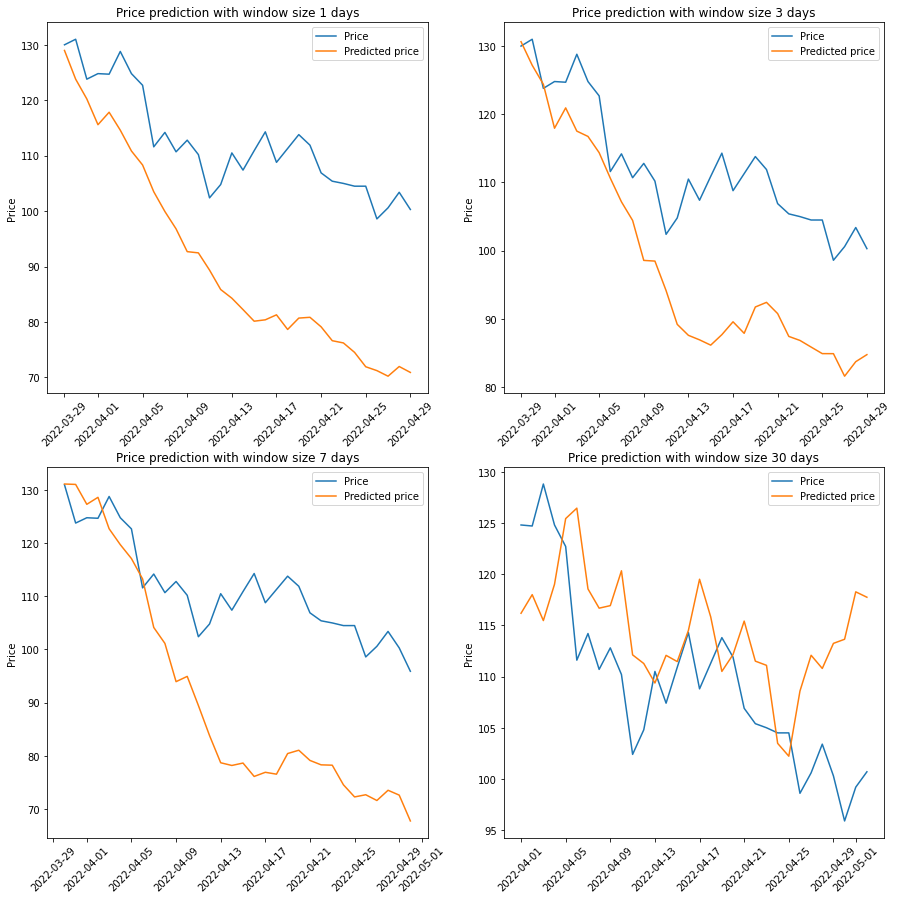

In [101]:
fig, axs = plt.subplots(2, 2)
# models_log.append((model,p_train1,dirs_train1,p_test1,dirs_test1,window_size,y_test,y_train,loss,val_loss))
# fig.suptitle('Price prediction')
for ax in axs.flatten():
    plt.sca(ax)
    plt.xticks(rotation = 45)
plt.rcParams['figure.figsize'] = [15, 15]
# name = model_names[k]
i = 0
j = 0
for model_num in range(4):
    if model_num == 0:
      i,j=0,0
      w_size=1
      y = y1
    elif model_num == 1:
      i,j=0,1
      w_size=3
      y = y3
    elif model_num == 2:
      i,j=1,0
      w_size=7
      y = y7
    elif model_num == 3:
      i,j=1,1
      w_size=30
      y = y30
      
    model = models_defi_prefinal[model_num]
    m,loss, val_loss,prices,poss,negs,y_test = model[0],model[-2],model[-1],model[1],model[2],model[3],model[4]
    # print(len(y_test))
    stop = -abs(len(y_test))
    # dates = df_LTC2['Date'][stop:]
    preds = m.predict({'prices':prices,'positives':poss,'negatives':negs},batch_size=16)

    # y_true_u = unnormalize(y_test)
    # y_preds_u = unnormalize(preds.flatten())
    # print(y_test.shape,preds.flatten().shape)
    init_value = get_init_value(y_test,df_LTC2)
    # price_true = get_price_from_log_returns2(y_test,df=df_LTC2,init_value=init_value)
    # price_pred = get_price_from_log_returns2(preds.flatten(),df=df_LTC2,init_value=init_value)
    price_true,price_pred,dates = ttt(y_test,unnormalize2(preds.flatten(),df_LTC2),df_LTC2)
    # print(unnormalize2(preds.flatten(),df_LTC2))
    # w_size = model[-3]
    axs[i, j].plot(dates,price_true)
    axs[i, j].plot(dates,price_pred)
    axs[i,j].legend(['Price','Predicted price'])
    # axs[i, j].set_xlabel('Date')
    axs[i, j].set_ylabel('Price')
    axs[i, j].set_title(f'Price prediction with window size '+str(w_size)+' days')
    m.reset_states()

# Final model
Davidson + DeFI

In [102]:
X1,y1 = tfmfuncs.df_to_X_y(df_LTC2,columns=['test','directions','positive','negative'],window_size=1)
X3,y3 = tfmfuncs.df_to_X_y(df_LTC2,columns=['test','directions','positive','negative'],window_size=3)
X7,y7 = tfmfuncs.df_to_X_y(df_LTC2,columns=['test','directions','positive','negative'],window_size=7)
X30,y30 = tfmfuncs.df_to_X_y(df_LTC2,columns=['test','directions','positive','negative'],window_size=30)

In [103]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed)

In [104]:
def build_model_final(X,batch_size):
    window_size = len(X[0,:])

    prices_input = Input(shape=(window_size,1), name="prices",batch_size=batch_size)
    positives_input = Input(shape=(window_size,1), name="positives",batch_size=batch_size)
    negatives_input = Input(shape=(window_size,1), name="negatives",batch_size=batch_size)
    directions_input = Input(shape=(window_size,1), name="directions",batch_size=batch_size)


    prices = LSTM(25,return_sequences=True,stateful=True)(prices_input)
    prices = Dropout(0.25)(prices)
    prices = GRU(40,stateful=True)(prices)
    prices = Flatten()(prices)
    prices = Dense(5,activation='relu')(prices)

    prices2 = LSTM(50,return_sequences=True,stateful=True)(prices_input)
    # middle_leg = LSTM(50,return_sequences=True)(middle_leg_input)
    prices2 = Dropout(0.25)(prices2)
    prices2 = Flatten()(prices2)
    prices2 = Dense(5,activation='relu')(prices2)

    positives = Dense(16,activation='relu',name="positives-Dense")(positives_input)
    positives = Flatten(name="positives-Flatten")(positives)
    
    negatives = Dense(16,activation='relu',name="negatives-Dense")(negatives_input)
    negatives = Flatten(name="negativess-Flatten")(negatives)

    directions = Flatten()(directions_input)
    directions = Dense(20,activation='relu')(negatives)
    directions = Dense(10,activation='relu')(negatives)

    x = concatenate([prices,prices2,directions,positives,negatives])
    x = Dense(20,activation='relu')(x)
    x = Dense(1,activation='linear',name='target')(x)

    inputs = [prices_input,directions_input,positives_input,negatives_input]
    output = x

    model = Model(inputs=inputs,outputs=output)

    return model

In [105]:
def adapt_ds4(X):
    window_size = len(X[0,:])
    # prices = X[:,:,0].reshape(len(X),window_size,1)
    # directions = X[:,:,1].reshape(len(X),window_size,1)
    prices = X[:,:,0]
    dirs = X[:,:,1]
    poss = X[:,:,2]
    negs = X[:,:,3]
    return prices, dirs, poss, negs

In [106]:
datasets = [(X1,y1),(X3,y3),(X7,y7),(X30,y30)]
nb_epochs = 25
models_final_final = []
j=0
for dataset in datasets:
    print(f'Training {j}')
    X = dataset[0]
    y = dataset[1]
    X_train, X_test = split_ds2(X,pct=0.9)
    y_train, y_test = split_ds2(y,pct=0.9)

    prices_train, dirs_train, poss_train, negs_train = adapt_ds4(X_train)
    prices_test, dirs_test, poss_test, negs_test = adapt_ds4(X_test)

    # X_test,y_test = resize_ds(X_test,y_test)
    prices_train = resize_ds2(prices_train)
    dirs_train = resize_ds2(dirs_train)
    poss_train = resize_ds2(poss_train)
    negs_train = resize_ds2(negs_train)
    y_train = resize_ds2(y_train).flatten()

    prices_test = resize_ds2(prices_test)
    dirs_test = resize_ds2(dirs_test)
    poss_test = resize_ds2(poss_test)
    negs_test = resize_ds2(negs_test)
    y_test = resize_ds2(y_test).flatten()

    print(f'X_train & y_train: {X_train.shape},{y_train.shape}\nX_test & y_test: {X_test.shape},{y_test.shape}')
    print(f'prices_train, poss_train & negs_train: {prices_train.shape},{poss_train.shape},{poss_train.shape}\n')

    model = build_model_final(X_train,batch_size=16)
    window_size = len(X_train[0,:])
    # p_train1, dirs_train1 = adapt_ds(X_train)
    # p_test1, dirs_test1 = adapt_ds(X_test)
    model.compile(optimizer='adam',loss='mse',metrics=['MeanSquaredError'])
    loss = []
    val_loss = []
    # model.summary()
    for i in range(nb_epochs):
        print(f'Epoch {i}')
        history = model.fit({'prices':prices_train,'directions':dirs_train,'positives':poss_train,'negatives':negs_train},{'target':y_train},validation_data=({'prices':prices_test,'directions':dirs_test,'positives':poss_test,'negatives':negs_test},{'target':y_test}),epochs=1,batch_size=16)
        loss.append(history.history['loss'][0])
        val_loss.append(history.history['val_loss'][0])
        model.reset_states()

    models_final_final.append((model,prices_test,dirs_test,poss_test,negs_test,y_test,window_size,loss,val_loss))
    model.save(f'models/tfm-defi-{window_size}.h5')
    tf.keras.backend.clear_session()
    j+=1
    print(f'Done training\n')

Training 0
X_train & y_train: (326, 1, 4),(320,)
X_test & y_test: (37, 1, 4),(32,)
prices_train, poss_train & negs_train: (320, 1),(320, 1),(320, 1)

Epoch 0
20/20 [==============================] - 4s 45ms/step - loss: 0.0982 - mean_squared_error: 0.0982 - val_loss: 0.0378 - val_mean_squared_error: 0.0378
Epoch 1
20/20 [==============================] - 0s 4ms/step - loss: 0.0392 - mean_squared_error: 0.0392 - val_loss: 0.0172 - val_mean_squared_error: 0.0172
Epoch 2
20/20 [==============================] - 0s 6ms/step - loss: 0.0320 - mean_squared_error: 0.0320 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 3
20/20 [==============================] - 0s 5ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 4
20/20 [==============================] - 0s 5ms/step - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 5
20/20 [==============================] - 0s 5ms/step - l

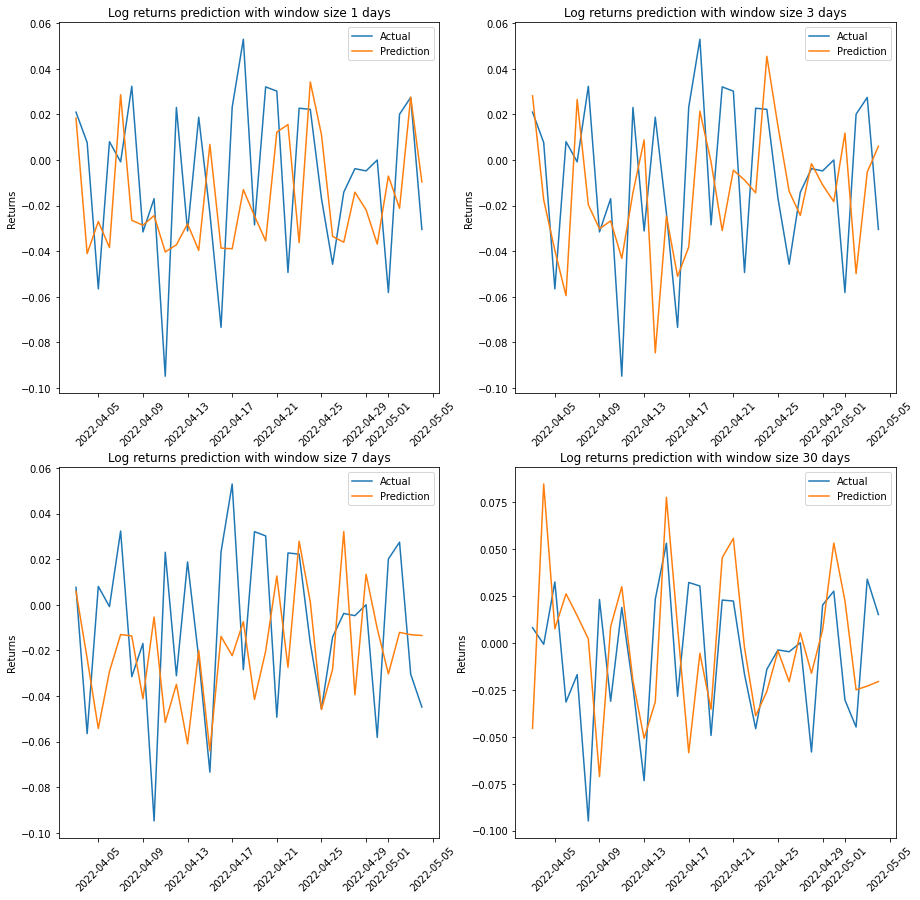

In [107]:
fig, axs = plt.subplots(2, 2)
# models_log.append((model,p_train1,dirs_train1,p_test1,dirs_test1,window_size,y_test,y_train,loss,val_loss))
# fig.suptitle('Price prediction')
plt.rcParams['figure.figsize'] = [15, 15]
for ax in axs.flatten():
    plt.sca(ax)
    plt.xticks(rotation = 45)
# name = model_names[k]
i = 0
j = 0
for model_num in range(4):
    if model_num == 0:
      i,j=0,0
      w_size=1
      y = y1
    elif model_num == 1:
      i,j=0,1
      w_size=3
      y = y3
    elif model_num == 2:
      i,j=1,0
      w_size=7
      y = y7
    elif model_num == 3:
      i,j=1,1
      w_size=30
      y = y30
    model = models_final_final[model_num]
    m,loss, val_loss,prices,dirs,poss,negs,y_test = model[0],model[-2],model[-1],model[1],model[2],model[3],model[4],model[5]
    stop = -abs(len(y_test))
    dates = df_LTC2['Date'][stop:]
    preds = m.predict({'prices':prices,'directions':dirs,'positives':poss,'negatives':negs},batch_size=16)

    # y_true_u = unnormalize(y_test)
    # y_preds_u = unnormalize(preds.flatten())

    # w_size = model[-3]
    axs[i, j].plot(dates,unnormalize2(y_test,df_LTC2))
    axs[i, j].plot(dates,unnormalize2(preds.flatten(),df_LTC2))
    axs[i,j].legend(['Actual','Prediction'])
    # props = {"rotation" : 30}
    # plt.xticks(rotation = 45)
    # axs[i, j].set_xlabel('Date')
    axs[i, j].set_ylabel('Returns')
    axs[i, j].set_title(f'Log returns prediction with window size '+str(w_size)+' days')
    m.reset_states()

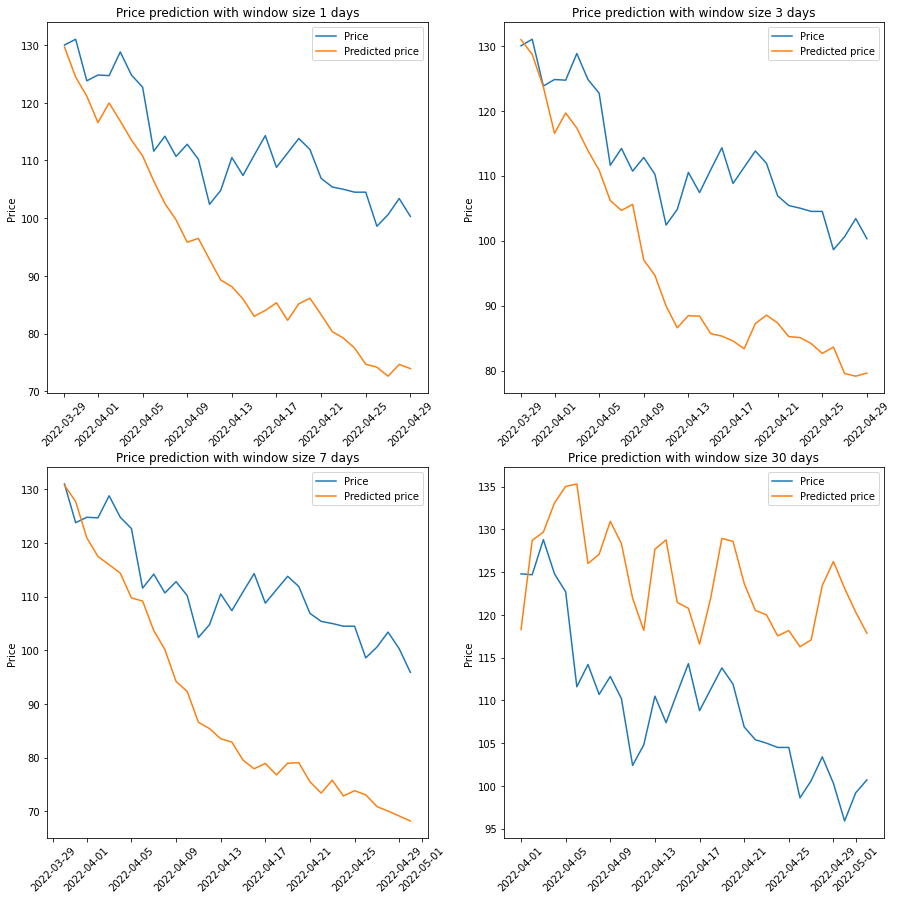

In [108]:
fig, axs = plt.subplots(2, 2)
# models_log.append((model,p_train1,dirs_train1,p_test1,dirs_test1,window_size,y_test,y_train,loss,val_loss))
# fig.suptitle('Price prediction')
for ax in axs.flatten():
    plt.sca(ax)
    plt.xticks(rotation = 45)
plt.rcParams['figure.figsize'] = [15, 15]
# name = model_names[k]
i = 0
j = 0
for model_num in range(4):
    if model_num == 0:
      i,j=0,0
      w_size=1
      y = y1
    elif model_num == 1:
      i,j=0,1
      w_size=3
      y = y3
    elif model_num == 2:
      i,j=1,0
      w_size=7
      y = y7
    elif model_num == 3:
      i,j=1,1
      w_size=30
      y = y30
      
    model = models_final_final[model_num]
    m,loss, val_loss,prices,dirs,poss,negs,y_test = model[0],model[-2],model[-1],model[1],model[2],model[3],model[4],model[5]
    # print(len(y_test))
    stop = -abs(len(y_test))
    # dates = df_LTC2['Date'][stop:]
    preds = m.predict({'prices':prices,'directions':dirs,'positives':poss,'negatives':negs},batch_size=16)

    # y_true_u = unnormalize(y_test)
    # y_preds_u = unnormalize(preds.flatten())
    # print(y_test.shape,preds.flatten().shape)
    init_value = get_init_value(y_test,df_LTC2)
    # price_true = get_price_from_log_returns2(y_test,df=df_LTC2,init_value=init_value)
    # price_pred = get_price_from_log_returns2(preds.flatten(),df=df_LTC2,init_value=init_value)
    price_true,price_pred,dates = ttt(y_test,unnormalize2(preds.flatten(),df_LTC2),df_LTC2)
    # print(unnormalize2(preds.flatten(),df_LTC2))
    # w_size = model[-3]
    axs[i, j].plot(dates,price_true)
    axs[i, j].plot(dates,price_pred)
    axs[i,j].legend(['Price','Predicted price'])
    # axs[i, j].set_xlabel('Date')
    axs[i, j].set_ylabel('Price')
    axs[i, j].set_title(f'Price prediction with window size '+str(w_size)+' days')
    m.reset_states()

(32, 30) (32, 30) (32, 30)


Text(0.5, 1.0, 'Actual price vs predicted price for window size of 30 days and for simple returns')

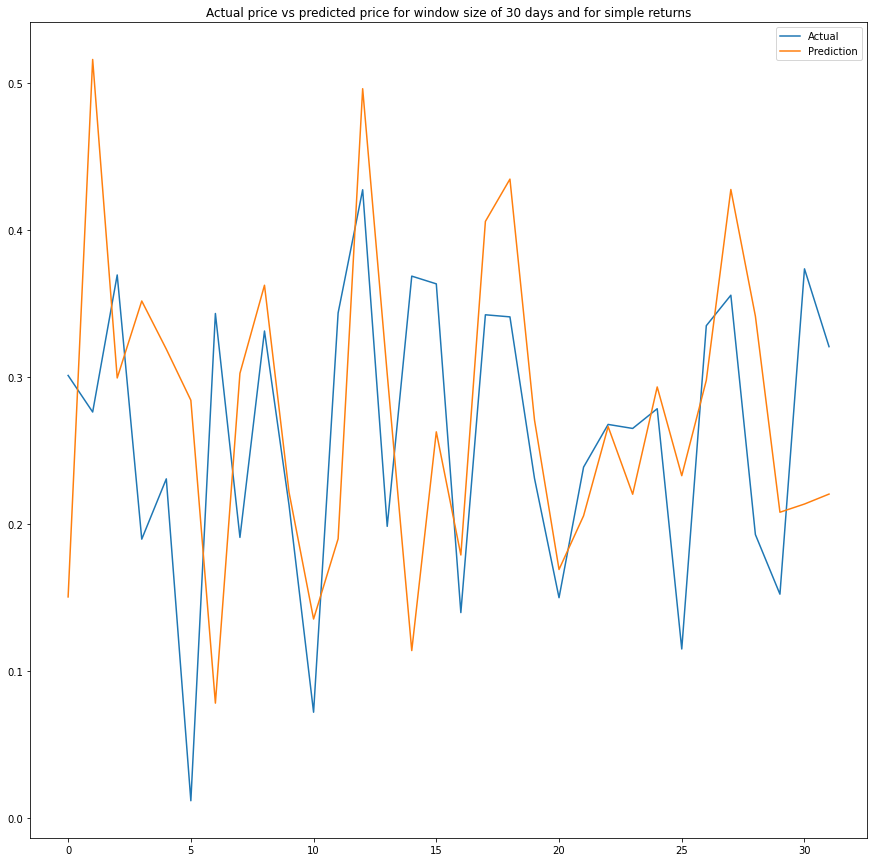

In [109]:
model_num = 3
m1 = models_final_final[model_num][0]
prices,dirs,poss,negs,y_test,w_size = models_final_final[model_num][1], models_final_final[model_num][2],models_final_final[model_num][3],models_final_final[model_num][4],models_final_final[model_num][5],models_final_final[model_num][6]
m1.reset_states()
print(prices.shape,poss.shape,negs.shape)
preds = m1.predict({'prices':prices,'directions':dirs,'positives':poss,'negatives':negs},batch_size=16)
stop = -abs(len(df_LTC['Date'][1200:])-len(y_true))
# dates = df_LTC['Date'][1200:stop]
plt.rcParams['figure.figsize'] = [15, 15]
# plt.plot(dates,y_true)
# plt.plot(dates,preds.flatten())
# plt.legend(['Actual','Prediction'])
# plt.title('Log returns vs predicted returns for window size of '+str(w_size)+' days')

# y_true_u = unnormalize(y_true)
# y_preds_u = unnormalize(preds.flatten())

y_true_u = y_test
y_preds_u = preds.flatten()

# price_true = get_price_from_log_returns(y_true_u)
# price_pred = get_price_from_log_returns(y_preds_u)

# price_true = recover_price(y_true_u)
# price_pred = recover_price(y_preds_u)

# num_points = 512

# plt.plot(dates[:num_points],price_true[:num_points])
# plt.plot(dates[:num_points],price_pred[:num_points])
plt.plot(y_true_u)
plt.plot(y_preds_u)
plt.legend(['Actual','Prediction'])
plt.title('Actual price vs predicted price for window size of '+str(w_size)+' days and for simple returns')

# Results


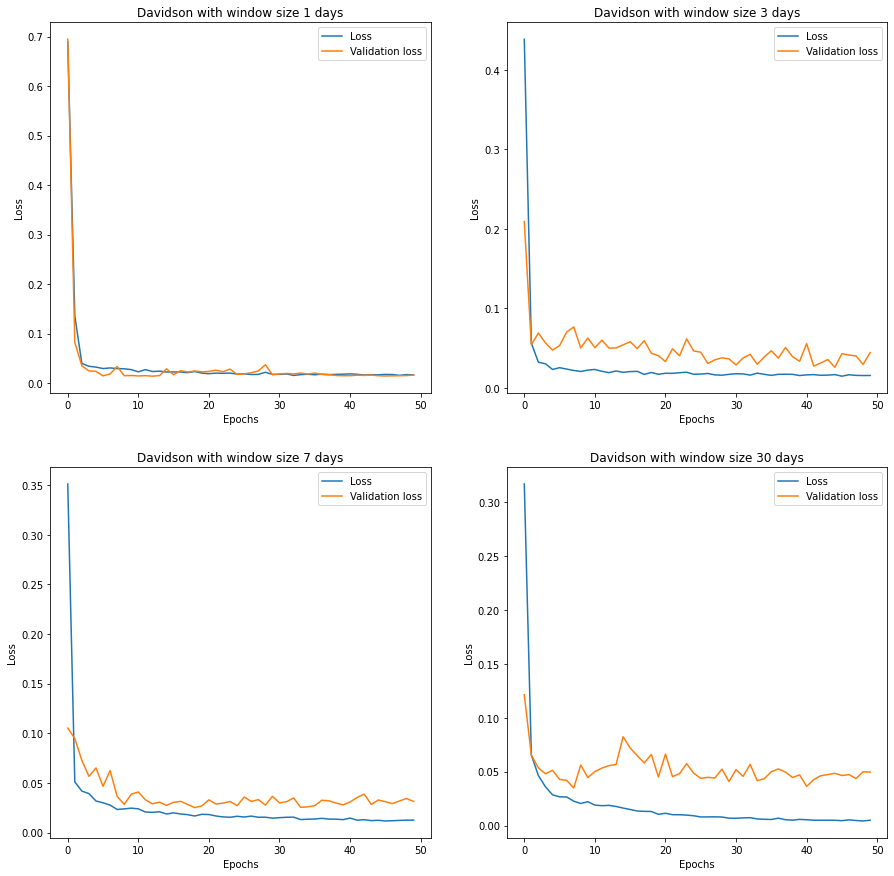

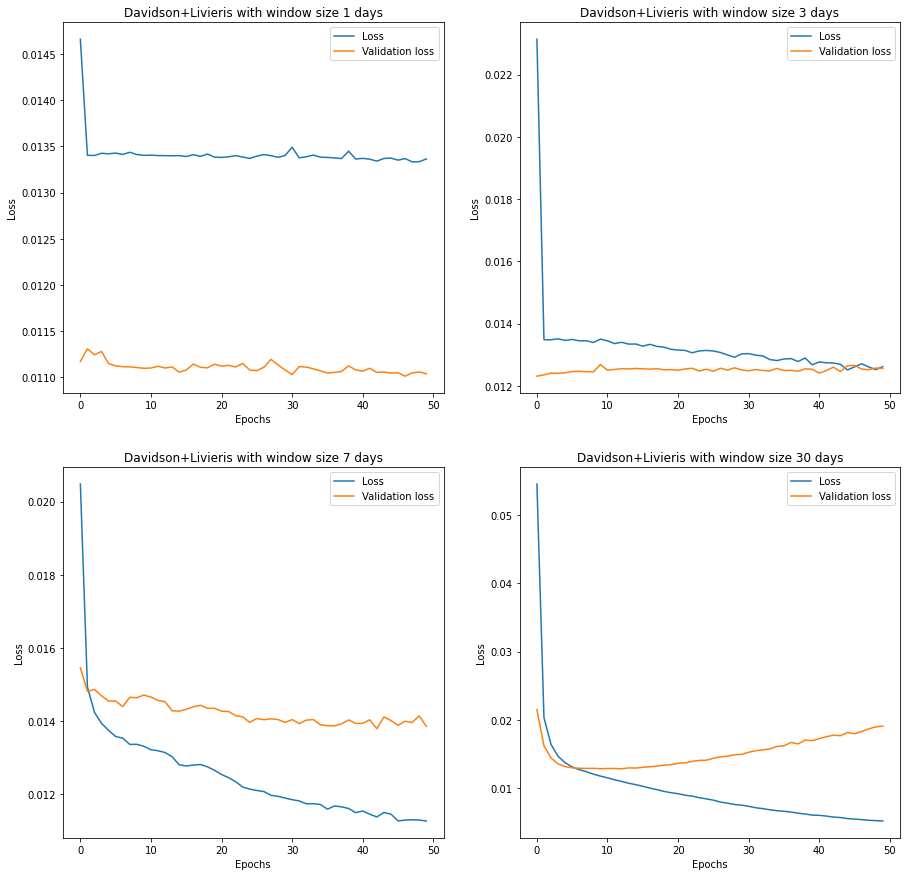

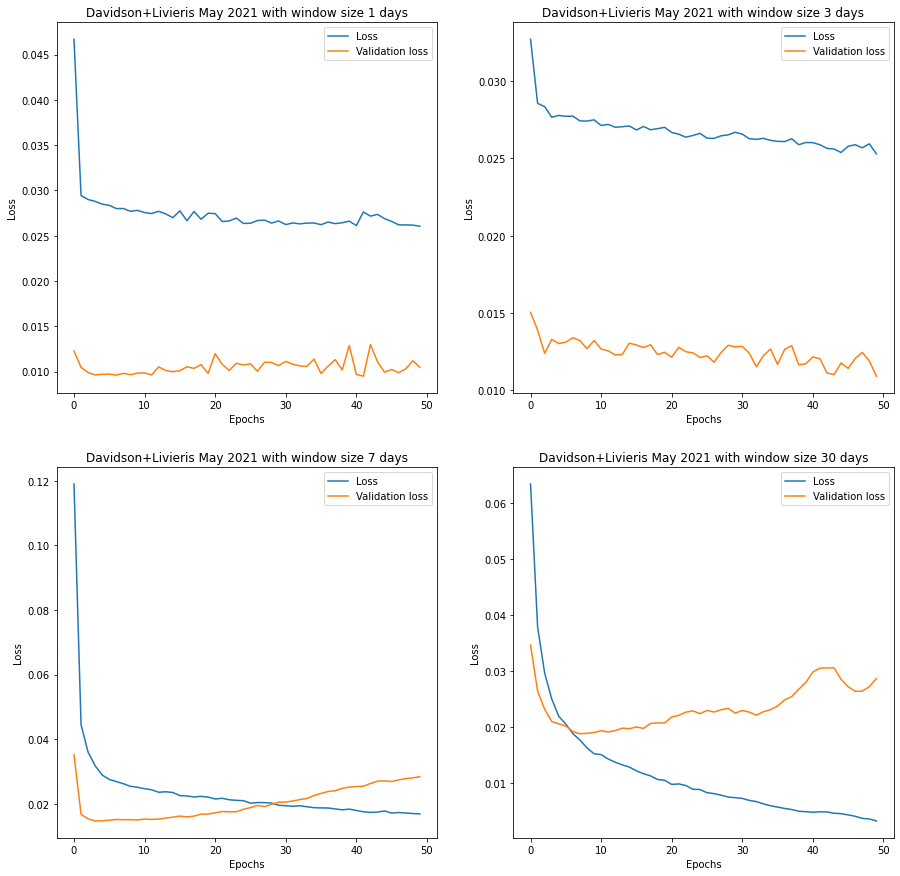

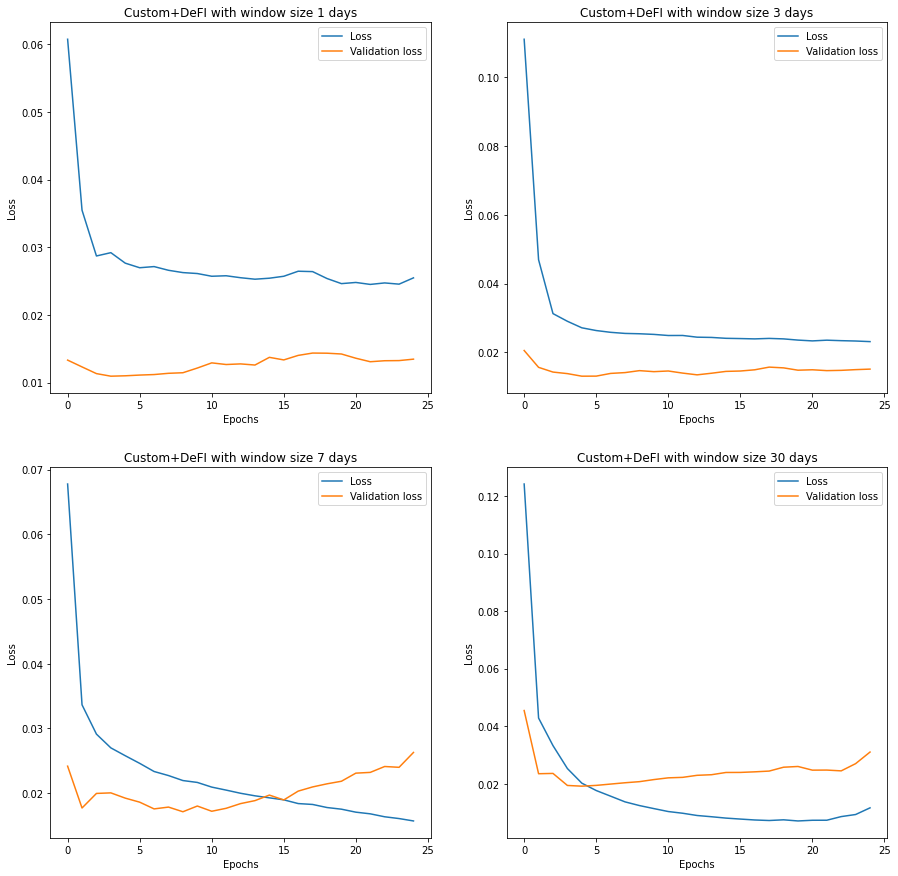

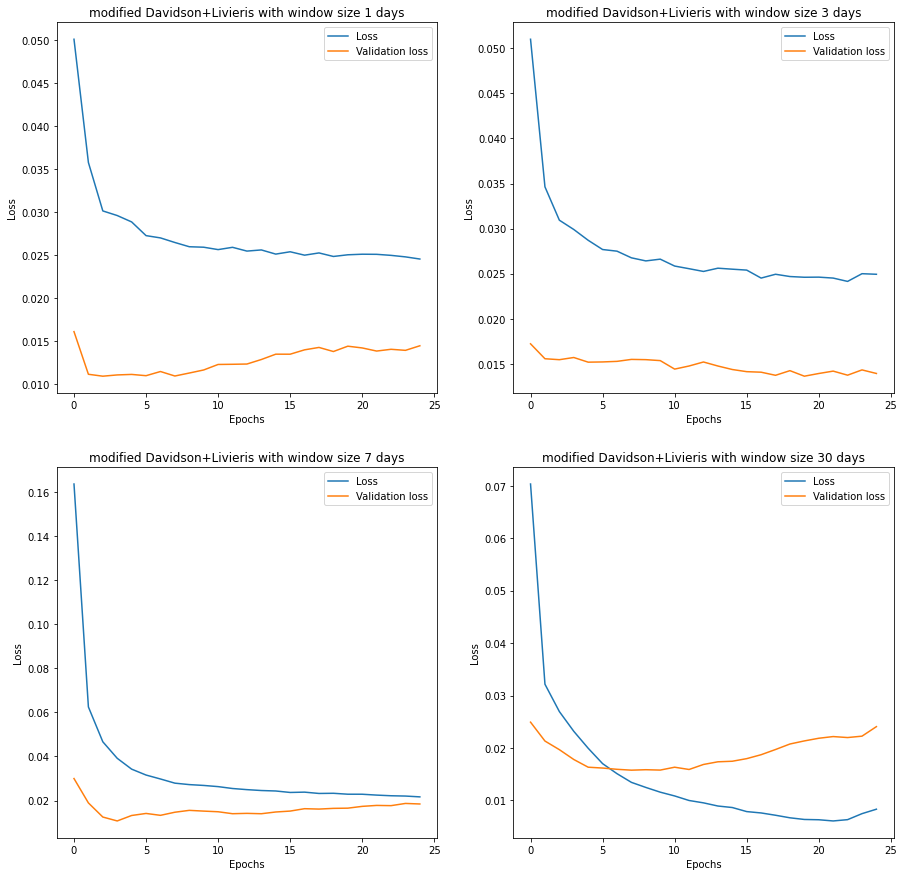

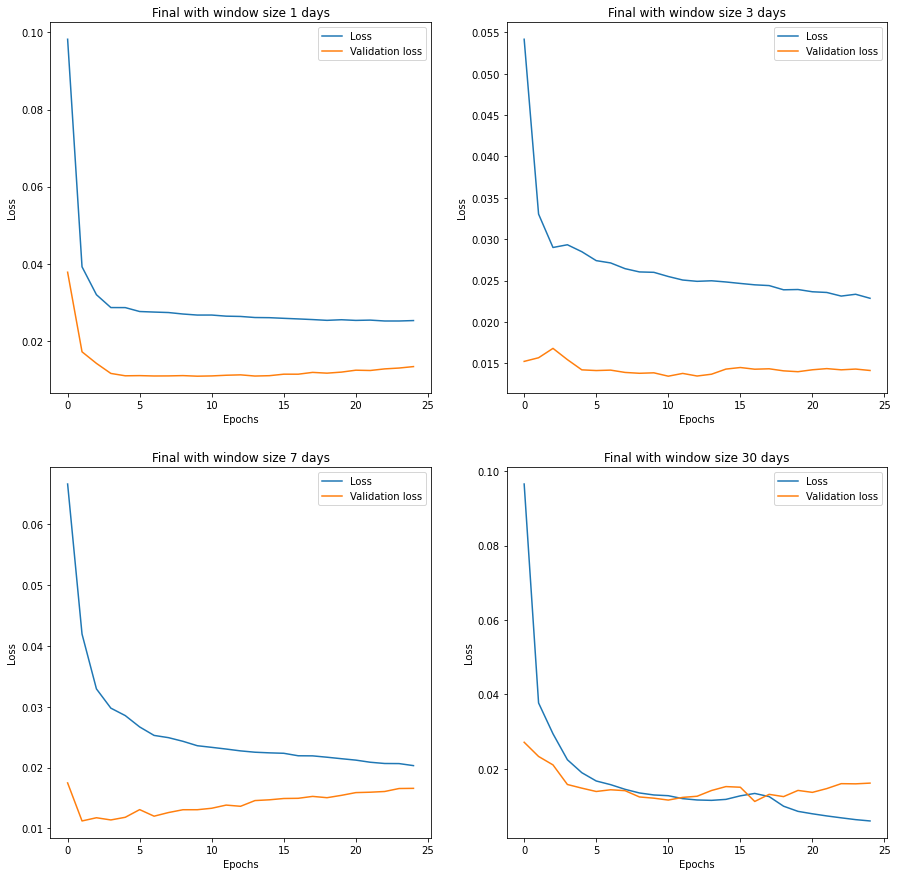

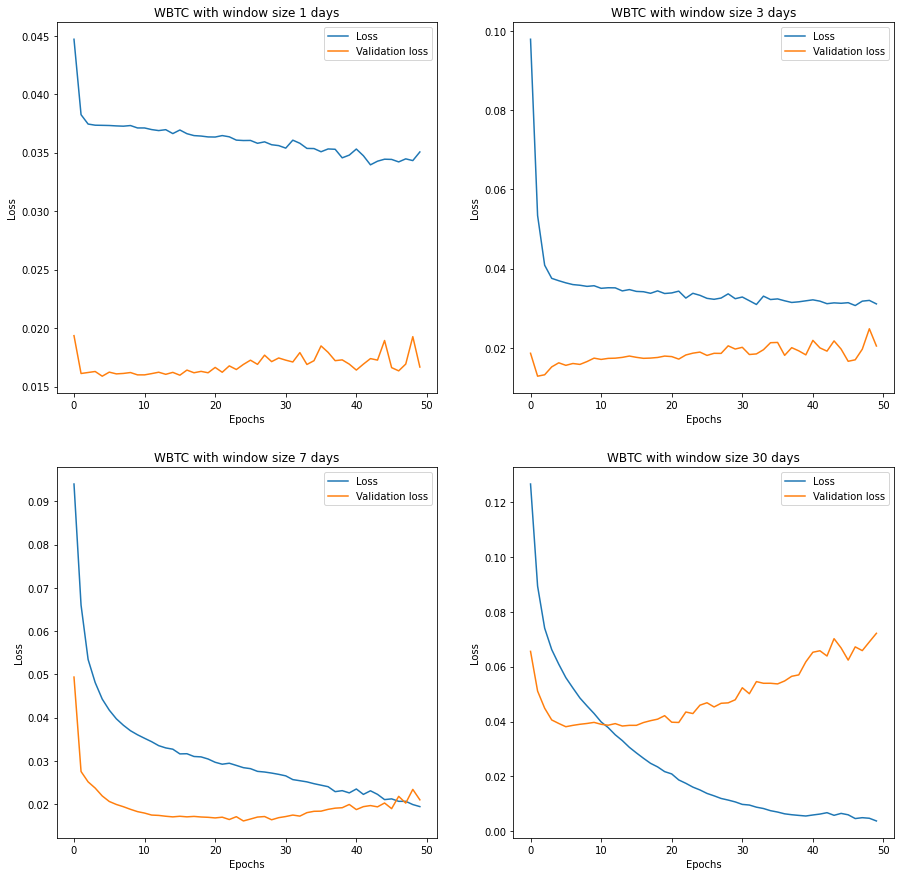

In [110]:
# all_models = [models,models_log,models_defi,models_final,models_final_ltc,models_defi_final,models_defi_prefinal,models_final_final]
all_models = [models,models_log,models_final_ltc,models_defi_final,models_defi_prefinal,models_final_final,models_final]
model_names = ['Davidson','Davidson+Livieris','Davidson+Livieris May 2021','Custom+DeFI','modified Davidson+Livieris','Final','WBTC']
# labels = ['Davidson','Davidson+Livieris','Davidson+Livieris May 2021','Custom+DeFI','modified Davidson+Livieris','Final']
'''
Livieris = log returns first diff
DeFI = WBTC data

Davidson et al. LTC price prediction    <-- no log returns
Davidson et al. + Livieris LTC prediction
Livieris + custom model with DeFI WBTC May 2021
Davidson et al. + Livieris WBTC prediction May 2021
Davidson et al. + Livieris LTC prediction May 2021
Davidson et al. modified + Livieris LTC prediction May 2021
Davidson et al. + Livieris with DeFI LTC prediction May 2021
'''
k = 0
for m in all_models:
  fig, axs = plt.subplots(2, 2)
  name = model_names[k]
  i = 0
  j = 0
  for model_num in range(4):
    if model_num == 0:
      i,j=0,0
      w_size=1
    elif model_num == 1:
      i,j=0,1
      w_size=3
    elif model_num == 2:
      i,j=1,0
      w_size=7
    elif model_num == 3:
      i,j=1,1
      w_size=30
    model = m[model_num]
    loss, val_loss = model[-2],model[-1]
    # w_size = model[-3]
    axs[i, j].plot(loss)
    axs[i, j].plot(val_loss)
    axs[i,j].legend(['Loss','Validation loss'])
    axs[i, j].set_xlabel('Epochs')
    axs[i, j].set_ylabel('Loss')
    axs[i, j].set_title(f'{name} with window size '+str(w_size)+' days')
  k+=1


In [111]:
k = 0
losses1 = []
val_losses1 = []
losses3 = []
val_losses3 = []
losses7 = []
val_losses7 = []
losses30 = []
val_losses30 = []
for m in all_models:
  name = model_names[k]
  i = 0
  j = 0

  for model_num in range(4):
    model = m[model_num]
    loss, val_loss = np.array(model[-2]),np.array(model[-1])
    min_loss,min_loss_arg,min_val_loss,min_val_loss_arg = np.min(loss), np.argmin(loss),np.min(val_loss), np.argmin(val_loss)
    if model_num == 0:
      losses1.append(min_loss)
      val_losses1.append(min_val_loss)
      w_size=1
    elif model_num == 1:
      losses3.append(min_loss)
      val_losses3.append(min_val_loss)
      w_size=3
    elif model_num == 2:
      losses7.append(min_loss)
      val_losses7.append(min_val_loss)
      w_size=7
    elif model_num == 3:
      losses30.append(min_loss)
      val_losses30.append(min_val_loss)
      w_size=30
    
    
losses1 = np.array(losses1)
val_losses1 = np.array(val_losses1)

losses3 = np.array(losses3)
val_losses3 = np.array(val_losses3)

losses7 = np.array(losses7)
val_losses7 = np.array(val_losses7)

losses30 = np.array(losses30)
val_losses30 = np.array(val_losses30)

In [112]:
len(labels)

1

In [113]:
np.arange(0,14,2)

array([ 0,  2,  4,  6,  8, 10, 12])

[Text(0, 0, 'Davidson'),
 Text(0, 0, 'Davidson+Livieris'),
 Text(0, 0, 'Davidson+Livieris May 2021'),
 Text(0, 0, 'Custom+DeFI'),
 Text(0, 0, 'modified Davidson+Livieris'),
 Text(0, 0, 'Final'),
 Text(0, 0, 'WBTC')]

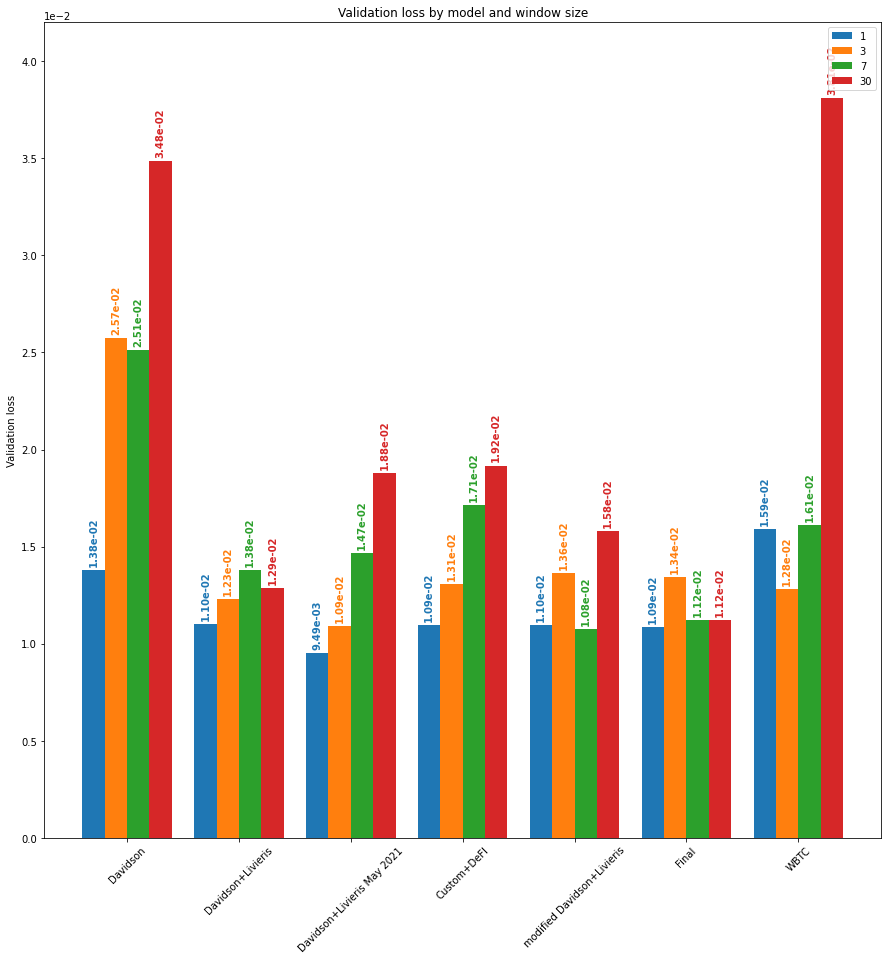

In [114]:
def addlabels(x,bars):
    bar_color = bars[0].get_facecolor()
    for bar in bars:
      ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.0003,
        # round(bar.get_height(), 1),
        '{:.2e}'.format(bar.get_height()),
        horizontalalignment='center',
        color=bar_color,
        weight='bold',
        rotation=90
    )

# model_names = ['Davidson','Davidson + Livieris','Custom + DeFI WBTC','Davidson + Livieris WBTC','Davidson + Livieris 2','custom+DeFi','modified Davidson + Livieris','final']
labels = ['Davidson','Davidson+Livieris','Davidson+Livieris May 2021','Custom+DeFI','modified Davidson+Livieris','Final','WBTC']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(0,2*len(labels),2)  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 3*width/2, val_losses1, width, label='1')
rects2 = ax.bar(x - width/2, val_losses3, width, label='3')
rects3 = ax.bar(x + width/2, val_losses7, width, label='7')
rects4 = ax.bar(x + 3*width/2, val_losses30, width, label='30')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Validation loss')
ax.set_title('Validation loss by model and window size')
ax.ticklabel_format(scilimits=[0,0])
ax.set_xticks(x)
ax.set_ylim(top=0.042)
plt.xticks(rotation=45)
addlabels(x,rects1)
addlabels(x,rects2)
addlabels(x,rects3)
addlabels(x,rects4)
ax.legend()

ax.set_xticklabels(labels)
# plt.tight_layout()
# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)
# ax.bar_label(rects4, padding=3)

In [115]:
!lscpu |grep 'Model name'

Model name:          AMD EPYC 7B12


In [116]:
models_log[0][-1]

[0.011173052713274956,
 0.011310605332255363,
 0.011245941743254662,
 0.011281360872089863,
 0.011149820871651173,
 0.011125287972390652,
 0.011116626672446728,
 0.011114269495010376,
 0.011107276193797588,
 0.011099444702267647,
 0.011102421209216118,
 0.011120874434709549,
 0.011102207936346531,
 0.011114356108009815,
 0.011057296767830849,
 0.01108024176210165,
 0.011144902557134628,
 0.011110677383840084,
 0.011103889904916286,
 0.011143391020596027,
 0.01112329214811325,
 0.011130919679999352,
 0.011113683693110943,
 0.011151749640703201,
 0.011080041527748108,
 0.011073963716626167,
 0.011110467836260796,
 0.011195695027709007,
 0.011136284098029137,
 0.011080748401582241,
 0.011031268164515495,
 0.01111751887947321,
 0.011113036423921585,
 0.011093289591372013,
 0.011071604676544666,
 0.011048480868339539,
 0.01105458103120327,
 0.011065240018069744,
 0.011125560849905014,
 0.011081610806286335,
 0.011068487539887428,
 0.011100078001618385,
 0.011054598726332188,
 0.011059658601

*   Davidson LTC May
 *   1day w_size
  ** Best Epoch 2 - loss: 0.0288 - mean_squared_error: 0.0288 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
  ** Last - loss: 0.0268 - mean_squared_error: 0.0268 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
 *   3day w_size
  ** Best Epoch 1 - loss: 0.0319 - mean_squared_error: 0.0319 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
  ** Last - loss: 0.0246 - mean_squared_error: 0.0246 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
 *   7day w_size
  ** Best Epoch 11 - loss: 0.0246 - mean_squared_error: 0.0246 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
  ** Last - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.0231 - val_mean_squared_error: 0.0231
 *   30day w_size
  ** Best Epoch 10 - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
  ** Last - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0132 - val_mean_squared_error: 0.0132


*   DeFI-only LTC May
  *   1day w_size
  ** Best Epoch 4 - loss: 0.0284 - mean_squared_error: 0.0284 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
  ** Last - loss: 0.0255 - mean_squared_error: 0.0255 - val_loss: 0.0157 - val_mean_squared_error: 0.0157
 *   3day w_size
  ** Best Epoch 4 - 0s 8ms/step - loss: 0.0281 - mean_squared_error: 0.0281 - val_loss: 0.0143 - val_mean_squared_error: 0.0143
  ** Last - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0170 - val_mean_squared_error: 0.0170
 *   7day w_size
  ** Best Epoch 18 - 0s 10ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - val_loss: 0.0225 - val_mean_squared_error: 0.0225
  ** Last - loss: 0.0177 - mean_squared_error: 0.0177 - val_loss: 0.0233 - val_mean_squared_error: 0.0233
 *   30day w_size
  ** Best Epoch 1 - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0347 - val_mean_squared_error: 0.0347
  ** Last - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0347 - val_mean_squared_error: 0.0347


*   Davidson LTC + DeFI May
  *   1day w_size
  ** Best Epoch 7 - loss: 0.0284 - mean_squared_error: 0.0284 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
  ** Last - loss: 0.0258 - mean_squared_error: 0.0258 - val_loss: 0.0149 - val_mean_squared_error: 0.0149
 *   3day w_size
  ** Best Epoch 6 - loss: 0.0284 - mean_squared_error: 0.0284 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
  ** Last - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.0155 - val_mean_squared_error: 0.0155
 *   7day w_size
  ** Best Epoch 3  - loss: 0.0277 - mean_squared_error: 0.0277 - val_loss: 0.0143 - val_mean_squared_error: 0.0143
  ** Last - loss: 0.0175 - mean_squared_error: 0.0175 - val_loss: 0.0181 - val_mean_squared_error: 0.0181
 *   30day w_size
  ** Best Epoch 5 - 0s 23ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
  ** Last- loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0223 - val_mean_squared_error: 0.0223
 